Please run those two cells before running the Notebook!

As those plotting settings are standard throughout the book, we do not show them in the book every time we plot something.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# feel free to modify, for example, change the context to "notebook"
sns.set_theme(context="talk", style="whitegrid", 
              palette="colorblind", color_codes=True, 
              rc={"figure.figsize": [12, 8]})

# Chapter 13 - Applied Machine Learning: Identifying Credit Default

## 13.0 Getting and preparing the data

This is a part not covered in the book. We download the considered dataset from the website of the [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients). The dataset originally does not contain missing values and the categorical variables are already encoded as numbers. To show the entire pipeline of working and preparing potentially messy data, we apply some transformations:

* we encoded the gender, education and marital status related variables to strings
* we introduced missing values to some observations (0.5% of the entire sample, selected randomly per column - the total percentage of rows with at least one missing value will be higher)
* some observed values for features such as level of education, payment status, etc. are outside of the range of possible categories defined by the authors. As this problem affects many observations, we encode new, undescribed categories as either 'Others' (when there was already such a category) or 'Unknown' (in the case of payment status).

The reason for selecting only a small fraction of values to be missing is that we do not want to significantly change the underlying structure/patterns in the data.

In [ ]:
import pandas as pd
import numpy as np
import random

In [ ]:
# downloading the data 
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls

In [ ]:
# load the data from Excel
df = pd.read_excel("default of credit card clients.xls", skiprows=1, index_col=0)

# rename columns
df.columns = df.columns.str.lower().str.replace(" ", "_")

months = ["sep", "aug", "jul", "jun", "may", "apr"]
variables = ["payment_status", "bill_statement", "previous_payment"]
new_column_names = [x + "_" + y for x in variables for y in months]
rename_dict = {x: y for x, y in zip(df.loc[:, "pay_0":"pay_amt6"].columns, new_column_names)}
df.rename(columns=rename_dict, inplace=True)


# create dicts to map number to strings
gender_dict = {1: "Male", 
               2: "Female"}
education_dict = {0: "Others",
                  1: "Graduate school", 
                  2: "University", 
                  3: "High school", 
                  4: "Others",
                  5: "Others",
                  6: "Others"}
marital_status_dict = {0: "Others", 
                       1: "Married", 
                       2: "Single", 
                       3: "Others"}
payment_status = {-2: "Unknown",
                  -1: "Payed duly",
                  0: "Unknown",
                  1: "Payment delayed 1 month",
                  2: "Payment delayed 2 months",
                  3: "Payment delayed 3 months",
                  4: "Payment delayed 4 months",
                  5: "Payment delayed 5 months",
                  6: "Payment delayed 6 months",
                  7: "Payment delayed 7 months",
                  8: "Payment delayed 8 months",
                  9: "Payment delayed >= 9 months"}

# map numbers to strings
df["sex"] = df["sex"].map(gender_dict)
df["education"] = df["education"].map(education_dict)
df["marriage"] = df["marriage"].map(marital_status_dict)

for column in [x for x in df.columns if ("status" in x)]:
    df[column] = df[column].map(payment_status)

# define the ratio of missing values
RATIO_MISSING = 0.005

# input missing values to selected columns
random_state = np.random.RandomState(42)
for column in ["sex", "education", "marriage", "age"]:
    df.loc[df.sample(frac=RATIO_MISSING, random_state=random_state).index, column] = ""

# reset index
df.reset_index(drop=True, inplace=True)

# save to csv
df.to_csv("../Datasets/credit_card_default.csv", index=False)

## 13.1 Loading data and managing data types

### How to do it...

1. Import the libraries:

In [3]:
import pandas as pd

2. Load the data from the CSV file:

In [4]:
df = pd.read_csv("../Datasets/credit_card_default.csv", 
                 na_values="")
df

limit_bal     sex    education marriage   age  \
0          20000  Female   University  Married  24.0   
1         120000  Female   University   Single  26.0   
2          90000  Female   University   Single  34.0   
3          50000  Female   University  Married  37.0   
4          50000    Male   University  Married  57.0   
...          ...     ...          ...      ...   ...   
29995     220000     NaN  High school  Married  39.0   
29996     150000    Male  High school   Single  43.0   
29997      30000    Male   University   Single  37.0   
29998      80000    Male  High school  Married  41.0   
29999      50000    Male   University  Married  46.0   

             payment_status_sep        payment_status_aug  \
0      Payment delayed 2 months  Payment delayed 2 months   
1                    Payed duly  Payment delayed 2 months   
2                       Unknown                   Unknown   
3                       Unknown                   Unknown   
4                    Payed duly                   Unknown   
...                         ...                       ...   
29995                   Unknown                   Unknown   
29996                Payed duly                Payed duly   
29997  Payment delayed 4 months  Payment delayed 3 months   
29998   Payment delayed 1 month                Payed duly   
29999                   Unknown                   Unknown   

             payment_status_jul payment_status_jun payment_status_may  ...  \
0                    Payed duly         Payed duly            Unknown  ...   
1                       Unknown            Unknown            Unknown  ...   
2                       Unknown            Unknown            Unknown  ...   
3                       Unknown            Unknown            Unknown  ...   
4                    Payed duly            Unknown            Unknown  ...   
...                         ...                ...                ...  ...   
29995                   Unknown            Unknown            Unknown  ...   
29996                Payed duly         Payed duly            Unknown  ...   
29997  Payment delayed 2 months         Payed duly            Unknown  ...   
29998                   Unknown            Unknown            Unknown  ...   
29999                   Unknown            Unknown            Unknown  ...   

      bill_statement_jun  bill_statement_may  bill_statement_apr  \
0                      0                   0                   0   
1                   3272                3455                3261   
2                  14331               14948               15549   
3                  28314               28959               29547   
4                  20940               19146               19131   
...                  ...                 ...                 ...   
29995              88004               31237               15980   
29996               8979                5190                   0   
29997              20878               20582               19357   
29998              52774               11855               48944   
29999              36535               32428               15313   

       previous_payment_sep  previous_payment_aug  previous_payment_jul  \
0                         0                   689                     0   
1                         0                  1000                  1000   
2                      1518                  1500                  1000   
3                      2000                  2019                  1200   
4                      2000                 36681                 10000   
...                     ...                   ...                   ...   
29995                  8500                 20000                  5003   
29996                  1837                  3526                  8998   
29997                     0                     0                 22000   
29998                 85900                  3409                  1178   
29999                 

3. View the summary of the DataFrame: 

In [ ]:
df.info()

4. Define a function for inspecting the exact memory usage of a DataFrame:

In [ ]:
def get_df_memory_usage(df, top_columns=5):
    """
    Function for quick analysis of a pandas DataFrame's memory usage.
    It prints the top `top_columns` columns in terms of memory usage 
    and the total usage of the DataFrame.
    
    Parameters
    ------------
    df : pd.DataFrame
        DataFrame to be inspected
    top_columns : int
        Number of top columns (in terms of memory used) to display
    """
    print("Memory usage ----")
    memory_per_column = df.memory_usage(deep=True) / (1024 ** 2)
    print(f"Top {top_columns} columns by memory (MB):")
    print(memory_per_column.sort_values(ascending=False) \
                           .head(top_columns))
    print(f"Total size: {memory_per_column.sum():.2f} MB")

In [ ]:
get_df_memory_usage(df, 5)

5. Convert the columns with `object` data type into `category` type:

In [ ]:
object_columns = df.select_dtypes(include="object").columns
df[object_columns] = df[object_columns].astype("category")

get_df_memory_usage(df)

6. Downcast the numeric columns to integers:

In [ ]:
numeric_columns = df.select_dtypes(include="number").columns
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], downcast="integer")

get_df_memory_usage(df)

In [ ]:
df.info()

7. Downcast the `age` column using the `float` data type:

In [ ]:
df["age"] = pd.to_numeric(df["age"], downcast="float")

get_df_memory_usage(df)

### There's more

Assign the data types to columns while loading the data using the `pd.read_csv`` method.

In [ ]:
column_dtypes = {
    "education": "category", 
    "marriage": "category", 
    "sex": "category"
}
df_cat = pd.read_csv("../Datasets/credit_card_default.csv", 
                     na_values="", dtype=column_dtypes)

get_df_memory_usage(df_cat)

## 13.2 Exploratory data analysis

### Getting ready

In [3]:
import pandas as pd
df = pd.read_csv("../Datasets/credit_card_default.csv", na_values="")

### How to do it...

1. Import the libraries:

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import plotly.io as pio

2. Get summary statistics of the numeric variables: 

In [5]:
df.describe().transpose().round(2)

count       mean        std       min       25%  \
limit_bal                   30000.0  167484.32  129747.66   10000.0  50000.00   
age                         29850.0      35.49       9.22      21.0     28.00   
bill_statement_sep          30000.0   51223.33   73635.86 -165580.0   3558.75   
bill_statement_aug          30000.0   49179.08   71173.77  -69777.0   2984.75   
bill_statement_jul          30000.0   47013.15   69349.39 -157264.0   2666.25   
bill_statement_jun          30000.0   43262.95   64332.86 -170000.0   2326.75   
bill_statement_may          30000.0   40311.40   60797.16  -81334.0   1763.00   
bill_statement_apr          30000.0   38871.76   59554.11 -339603.0   1256.00   
previous_payment_sep        30000.0    5663.58   16563.28       0.0   1000.00   
previous_payment_aug        30000.0    5921.16   23040.87       0.0    833.00   
previous_payment_jul        30000.0    5225.68   17606.96       0.0    390.00   
previous_payment_jun        30000.0    4826.08   15666.16       0.0    296.00   
previous_payment_may        30000.0    4799.39   15278.31       0.0    252.50   
previous_payment_apr        30000.0    5215.50   17777.47       0.0    117.75   
default_payment_next_month  30000.0       0.22       0.42       0.0      0.00   

                                 50%        75%        max  
limit_bal                   140000.0  240000.00  1000000.0  
age                             34.0      41.00       79.0  
bill_statement_sep           22381.5   67091.00   964511.0  
bill_statement_aug           21200.0   64006.25   983931.0  
bill_statement_jul           20088.5   60164.75  1664089.0  
bill_statement_jun           19052.0   54506.00   891586.0  
bill_statement_may           18104.5   50190.50   927171.0  
bill_statement_apr           17071.0   49198.25   961664.0  
previous_payment_sep          2100.0    5006.00   873552.0  
previous_payment_aug          2009.0    5000.00  1684259.0  
previous_payment_jul          1800.0    4505.00   896040.0  
previous_payment_jun          1500.0    4013.25   621000.0  
previous_payment_may          1500.0    4031.50   426529.0  
previous_payment_apr          1500.0    4000.00   528666.0  
default_payment_next_month       0.0       0.00        1.0

3. Get summary statistics of the categorical variables: 

In [6]:
df.describe(include="object").transpose()

count unique         top   freq
sex                 29850      2      Female  18027
education           29850      4  University  13960
marriage            29850      3      Single  15891
payment_status_sep  30000     10     Unknown  17496
payment_status_aug  30000     10     Unknown  19512
payment_status_jul  30000     10     Unknown  19849
payment_status_jun  30000     10     Unknown  20803
payment_status_may  30000      9     Unknown  21493
payment_status_apr  30000      9     Unknown  21181

Alternatively, we can get the summary statistics of all columns in one table using the following snippet:

In [7]:
df.describe(include="all").transpose()

count unique         top   freq           mean  \
limit_bal                   30000.0    NaN         NaN    NaN  167484.322667   
sex                           29850      2      Female  18027            NaN   
education                     29850      4  University  13960            NaN   
marriage                      29850      3      Single  15891            NaN   
age                         29850.0    NaN         NaN    NaN      35.490117   
payment_status_sep            30000     10     Unknown  17496            NaN   
payment_status_aug            30000     10     Unknown  19512            NaN   
payment_status_jul            30000     10     Unknown  19849            NaN   
payment_status_jun            30000     10     Unknown  20803            NaN   
payment_status_may            30000      9     Unknown  21493            NaN   
payment_status_apr            30000      9     Unknown  21181            NaN   
bill_statement_sep          30000.0    NaN         NaN    NaN     51223.3309   
bill_statement_aug          30000.0    NaN         NaN    NaN   49179.075167   
bill_statement_jul          30000.0    NaN         NaN    NaN     47013.1548   
bill_statement_jun          30000.0    NaN         NaN    NaN   43262.948967   
bill_statement_may          30000.0    NaN         NaN    NaN   40311.400967   
bill_statement_apr          30000.0    NaN         NaN    NaN     38871.7604   
previous_payment_sep        30000.0    NaN         NaN    NaN      5663.5805   
previous_payment_aug        30000.0    NaN         NaN    NaN      5921.1635   
previous_payment_jul        30000.0    NaN         NaN    NaN      5225.6815   
previous_payment_jun        30000.0    NaN         NaN    NaN    4826.076867   
previous_payment_may        30000.0    NaN         NaN    NaN    4799.387633   
previous_payment_apr        30000.0    NaN         NaN    NaN    5215.502567   
default_payment_next_month  30000.0    NaN         NaN    NaN         0.2212   

                                      std       min      25%       50%  \
limit_bal                   129747.661567   10000.0  50000.0  140000.0   
sex                                   NaN       NaN      NaN       NaN   
education                             NaN       NaN      NaN       NaN   
marriage                              NaN       NaN      NaN       NaN   
age                              9.217852      21.0     28.0      34.0   
payment_status_sep                    NaN       NaN      NaN       NaN   
payment_status_aug                    NaN       NaN      NaN       NaN   
payment_status_jul                    NaN       NaN      NaN       NaN   
payment_status_jun                    NaN       NaN      NaN       NaN   
payment_status_may                    NaN       NaN      NaN       NaN   
payment_status_apr                    NaN       NaN      NaN       NaN   
bill_statement_sep           73635.860576 -165580.0  3558.75   22381.5   
bill_statement_aug           71173.768783  -69777.0  2984.75   21200.0   
bill_statement_jul           69349.387427 -157264.0  2666.25   20088.5   
bill_statement_jun           64332.856134 -170000.0  2326.75   19052.0   
bill_statement_may            60797.15577  -81334.0   1763.0   18104.5   
bill_statement_apr           59554.107537 -339603.0   1256.0   17071.0   
previous_payment_sep         16563.280354       0.0   1000.0    2100.0   
previous_payment_aug         23040.870402       0.0    833.0    2009.0   
previous_payment_jul          17606.96147       0.0    390.0    1800.0   
previous_payment_jun         15666.159744       0.0    296.0    1500.0   
previous_payment_may         15278.305679       0.0    252.5    1500.0   
previous_payment_apr         17777.465775       0.0   117.75    1500.0   
default_payment_next_month       0.415062       0.0      0.0       0.0   

                                 75%        max  
limit_bal                   240000.0  1000000.0  
sex                              NaN        NaN  
education                   

4. Plot the distribution of age and, additionally, split it by gender: 

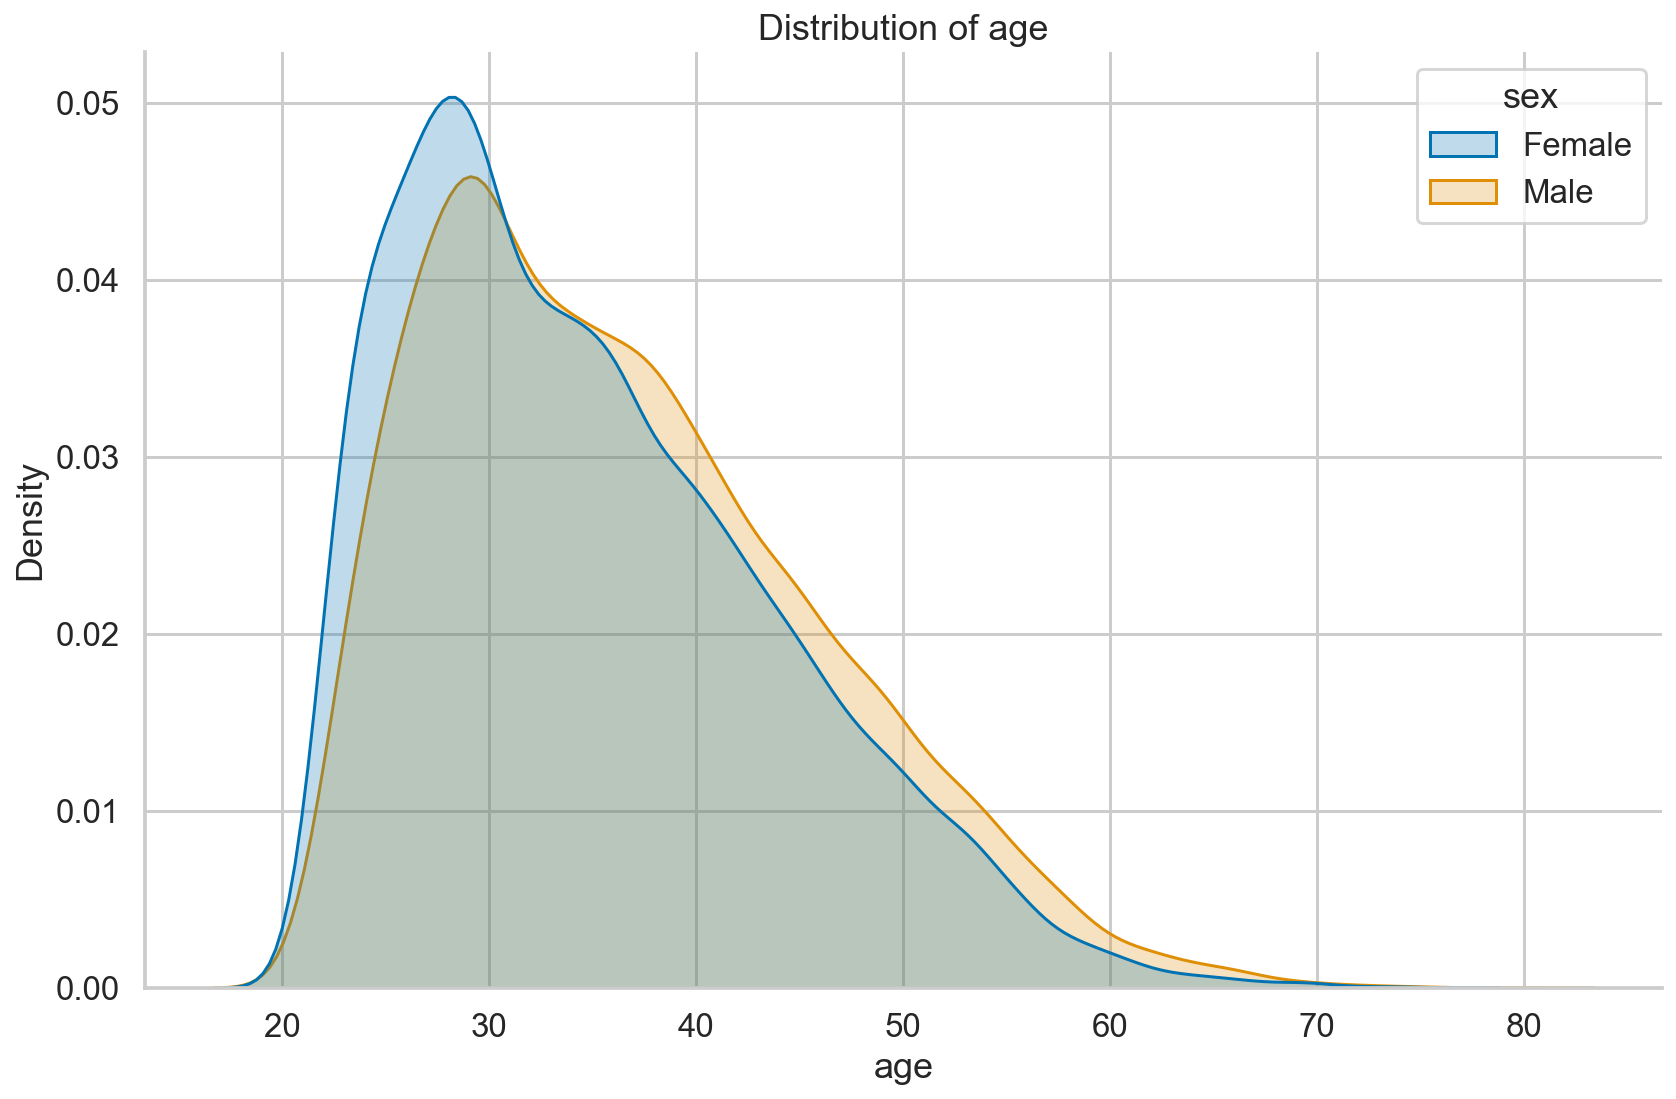

In [8]:
ax = sns.kdeplot(data=df, x="age", 
                 hue="sex", common_norm=False, 
                 fill=True)
ax.set_title("Distribution of age")

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_13_1", dpi=200)

As mentioned in the text, we can create a histogram (together with the KDE), by running:

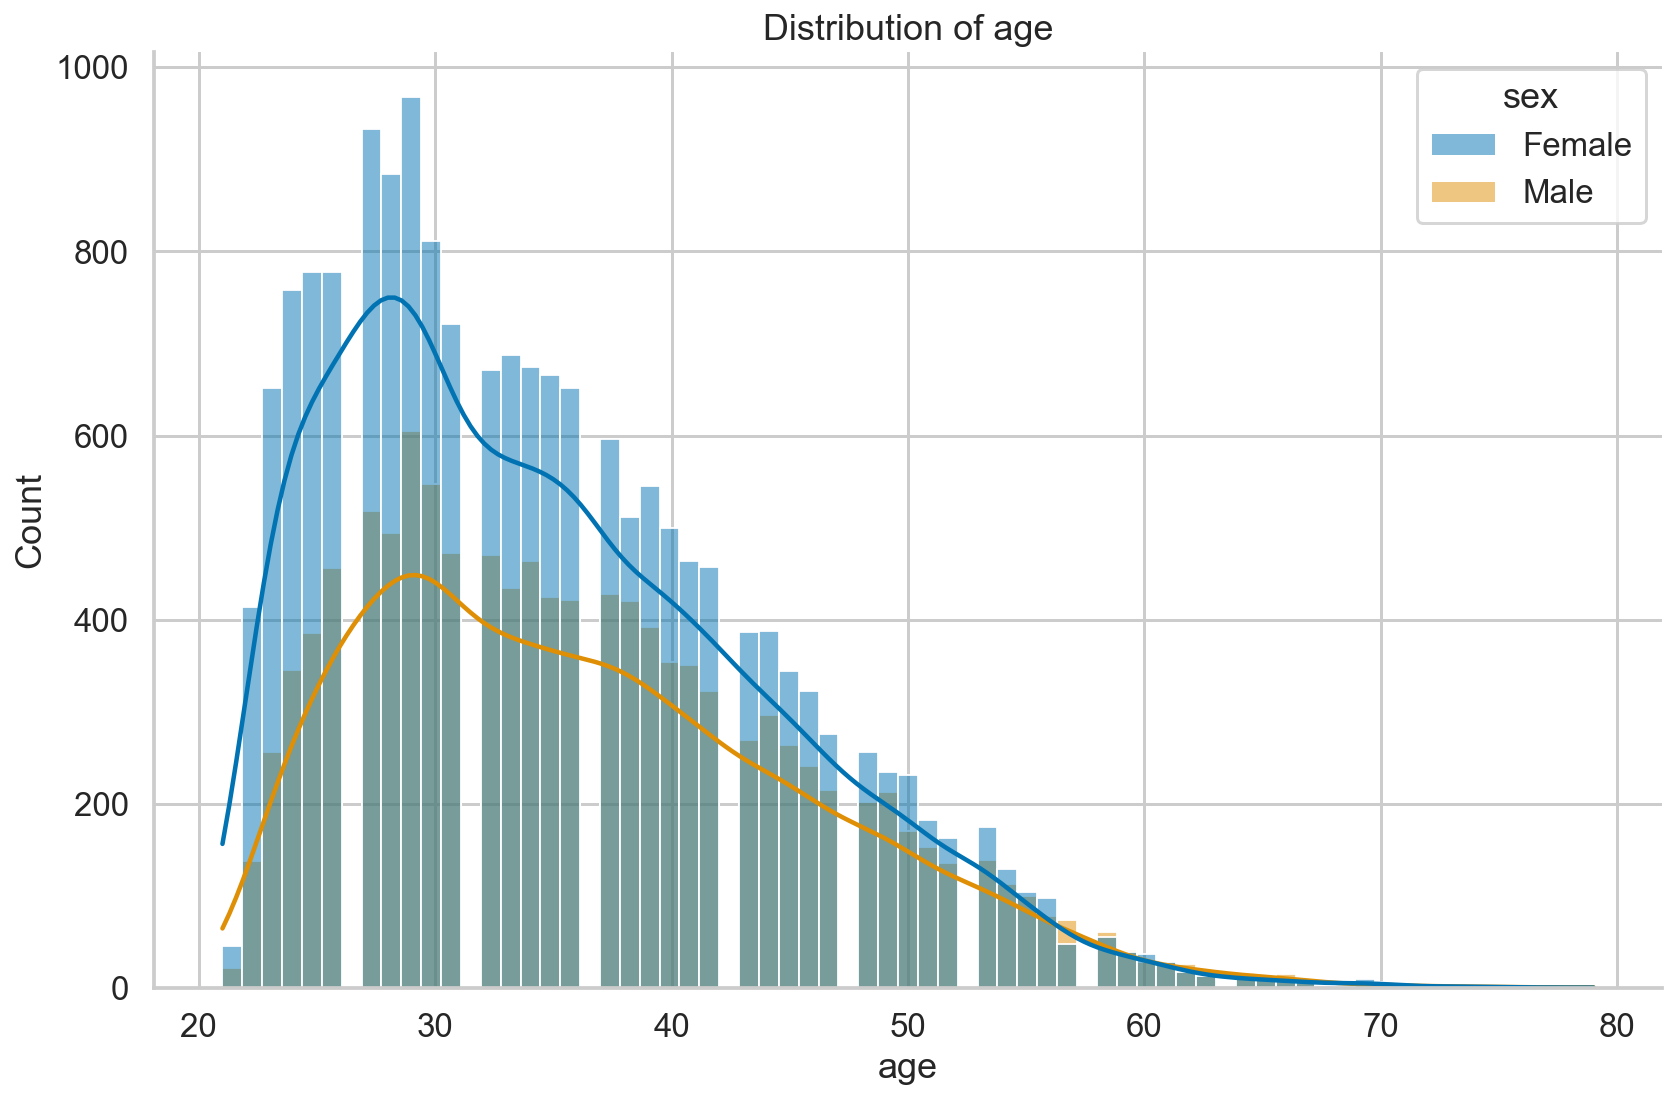

In [9]:
ax = sns.histplot(data=df.dropna(), x="age", hue="sex", kde=True)
ax.set_title("Distribution of age");

sns.despine()
plt.tight_layout()

We noticed some gaps in the plot and the reason for this is the binning. Below, we created the same histogram using `sns.countplot` and `plotly_express`. By doing so, each value of age has a separate bin and we can inspect the plot in detail. There are no such spikes in the following plots:

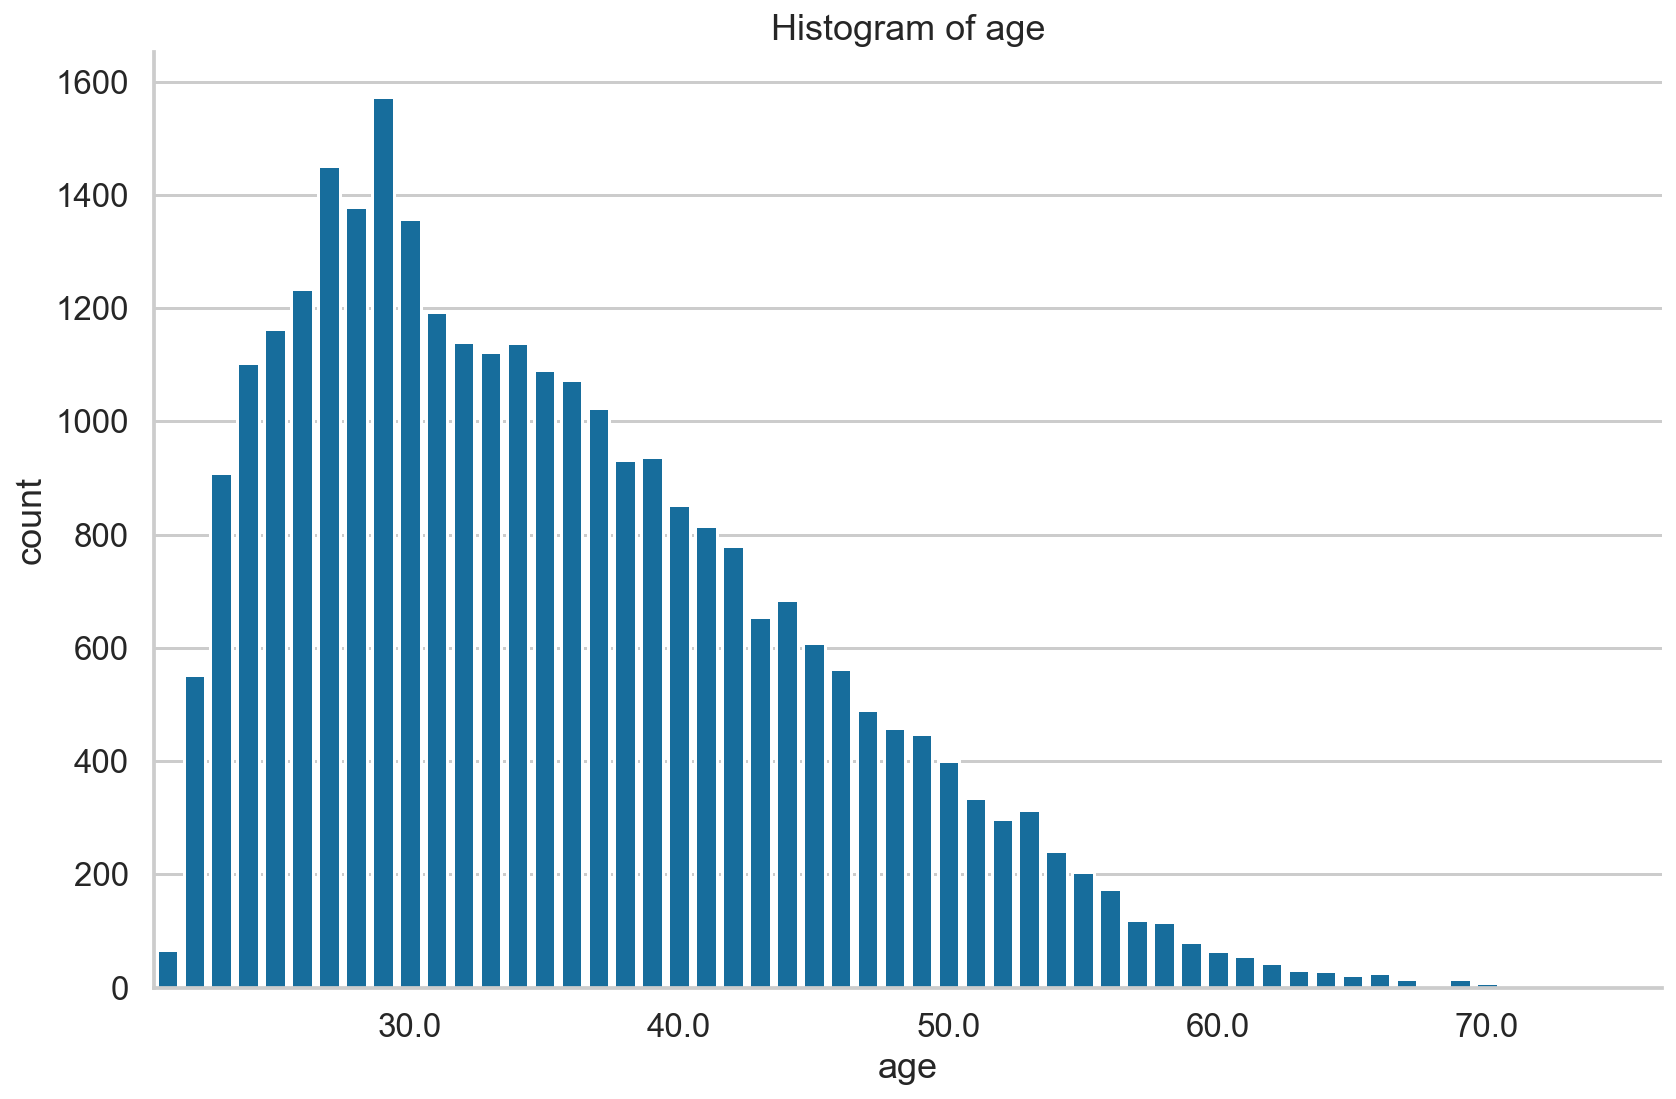

In [10]:
ax = sns.countplot(data=df.dropna(), x="age", color="b")

for ind, label in enumerate(ax.get_xticklabels()):
    if int(float(label.get_text())) % 10 == 0:
        label.set_visible(True)
    else:
        label.set_visible(False)

ax.set_title("Histogram of age")

sns.despine()
plt.tight_layout()

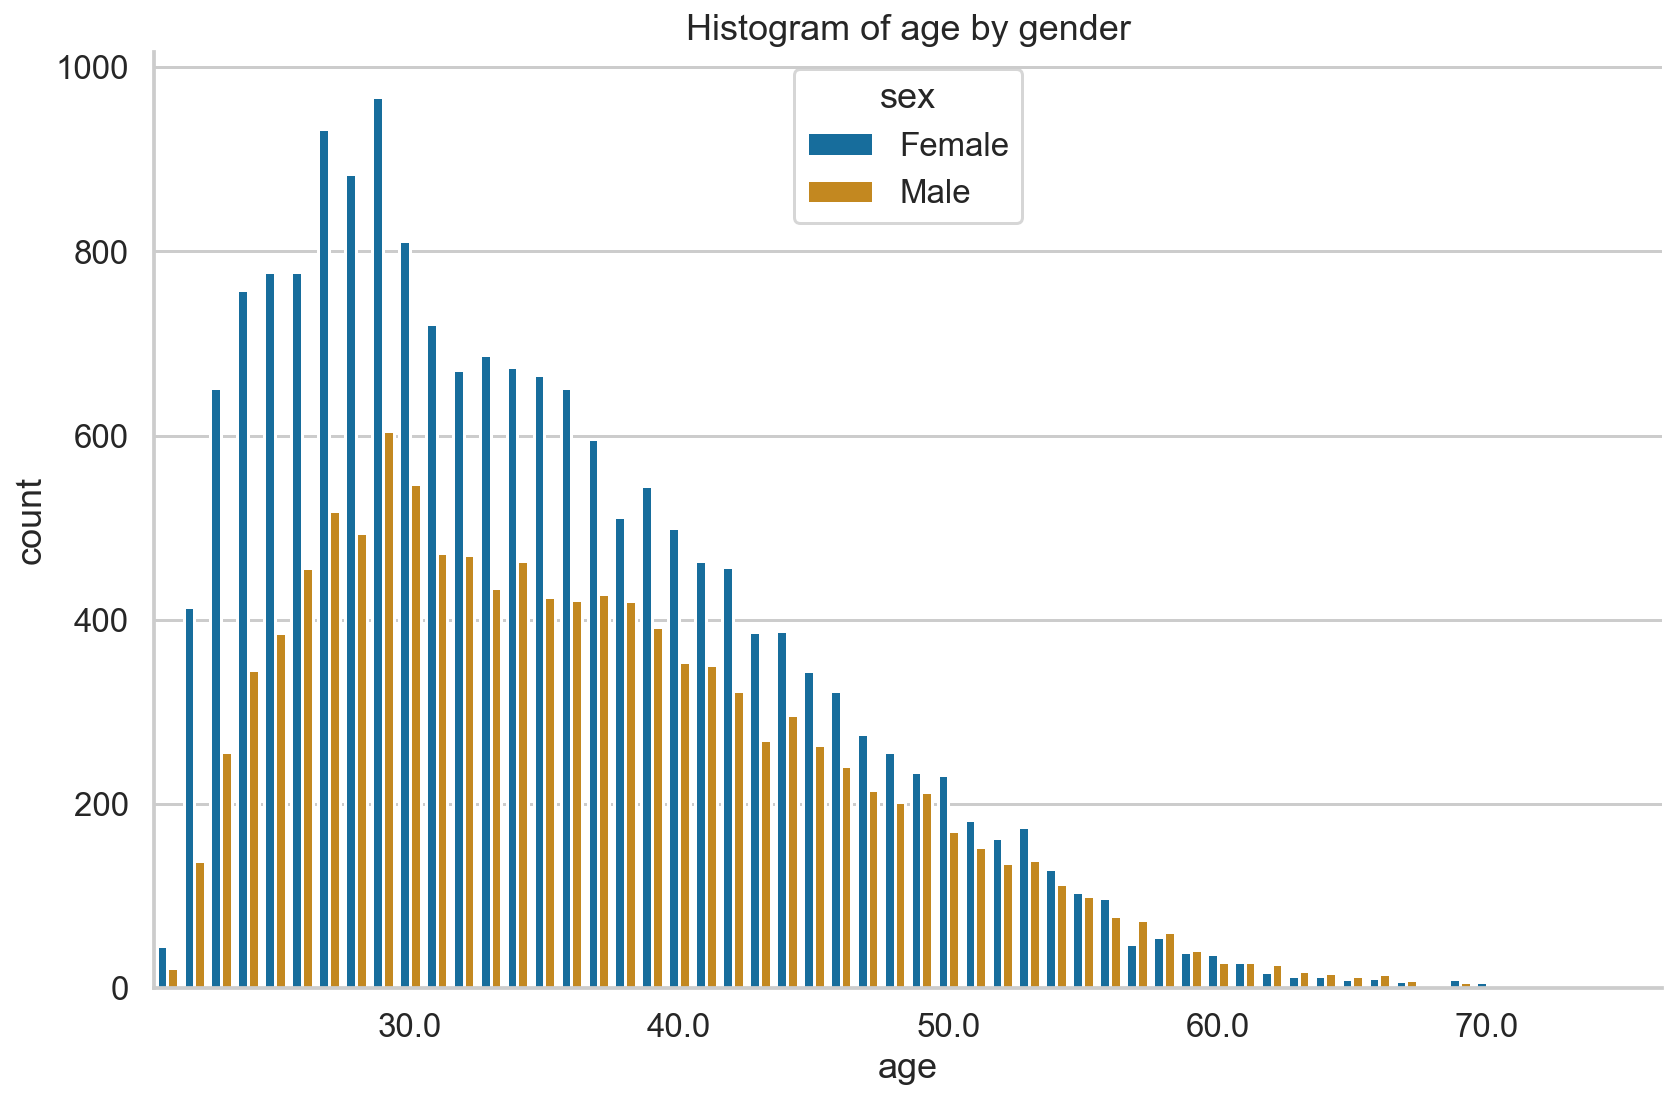

In [11]:
ax = sns.countplot(data=df.dropna(), x="age", hue="sex")

for ind, label in enumerate(ax.get_xticklabels()):
    if int(float(label.get_text())) % 10 == 0:
        label.set_visible(True)
    else:
        label.set_visible(False)

ax.set_title("Histogram of age by gender")

sns.despine()
plt.tight_layout()

In [12]:
px.histogram(df.dropna(), x="age", color="sex", title = "Distribution of age")

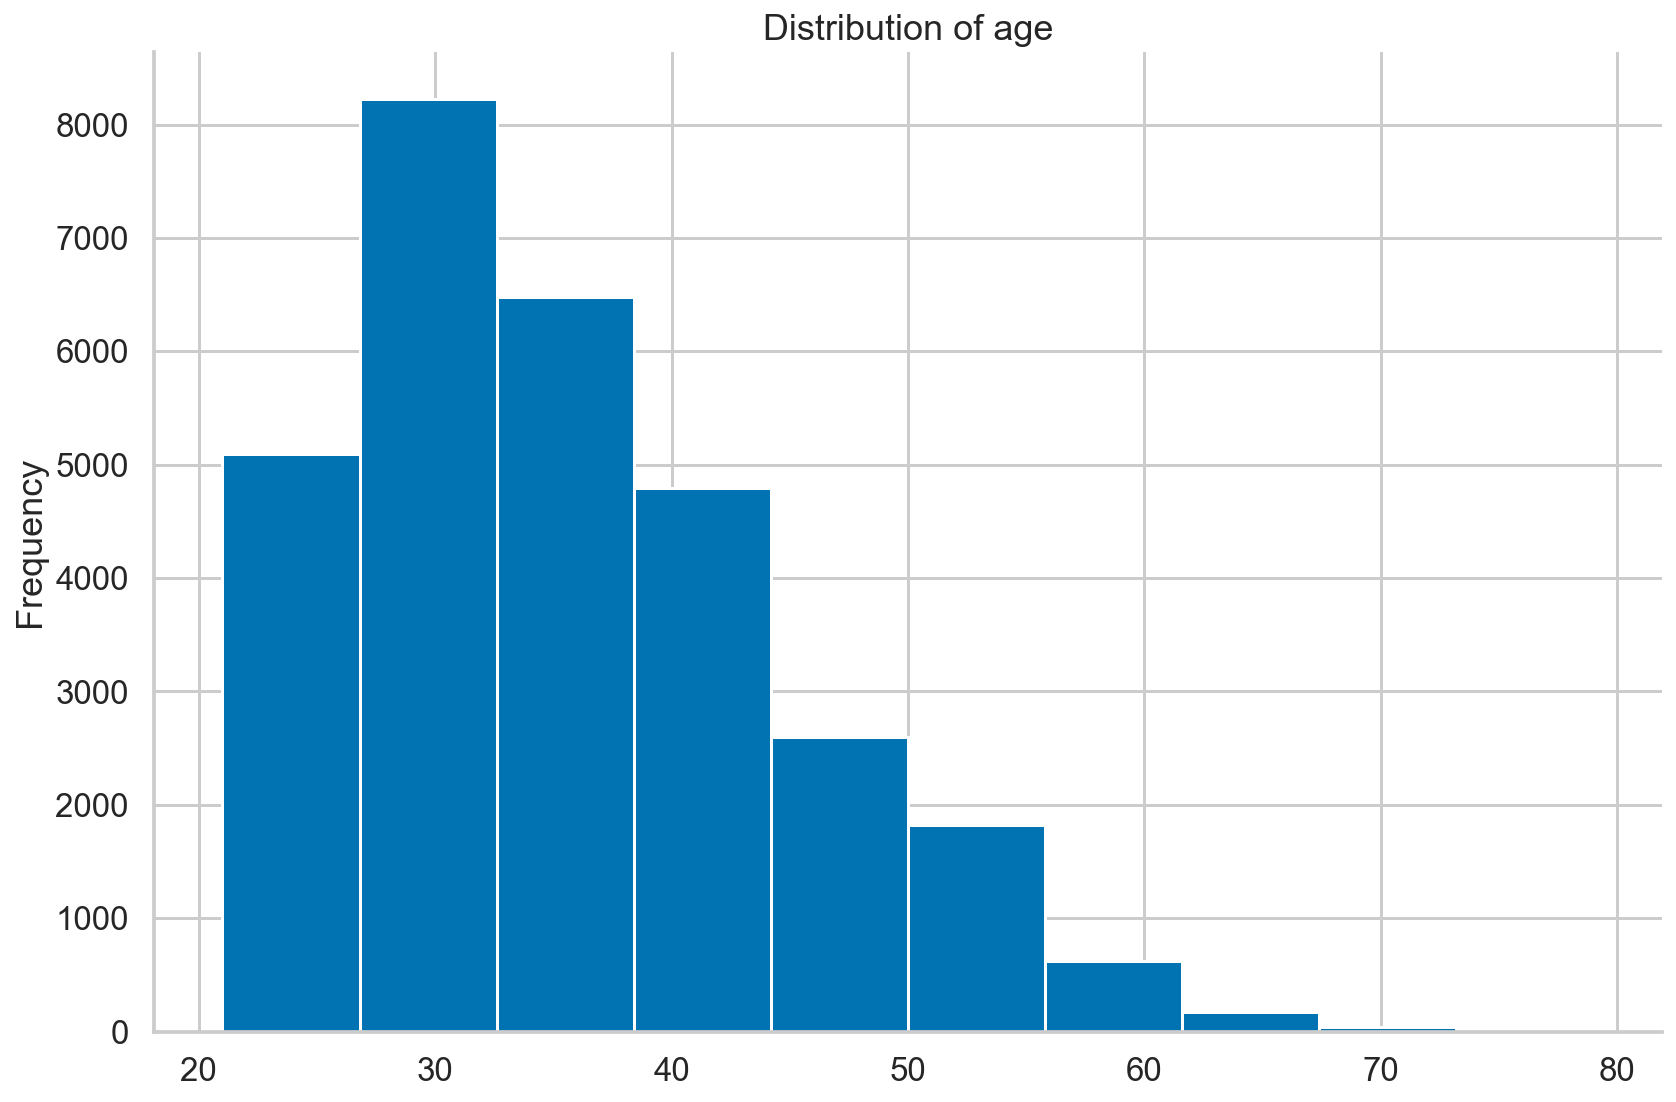

In [13]:
df["age"].plot(kind="hist", title="Distribution of age")

sns.despine()
plt.tight_layout()

5. Create a `pairplot` of selected variables:

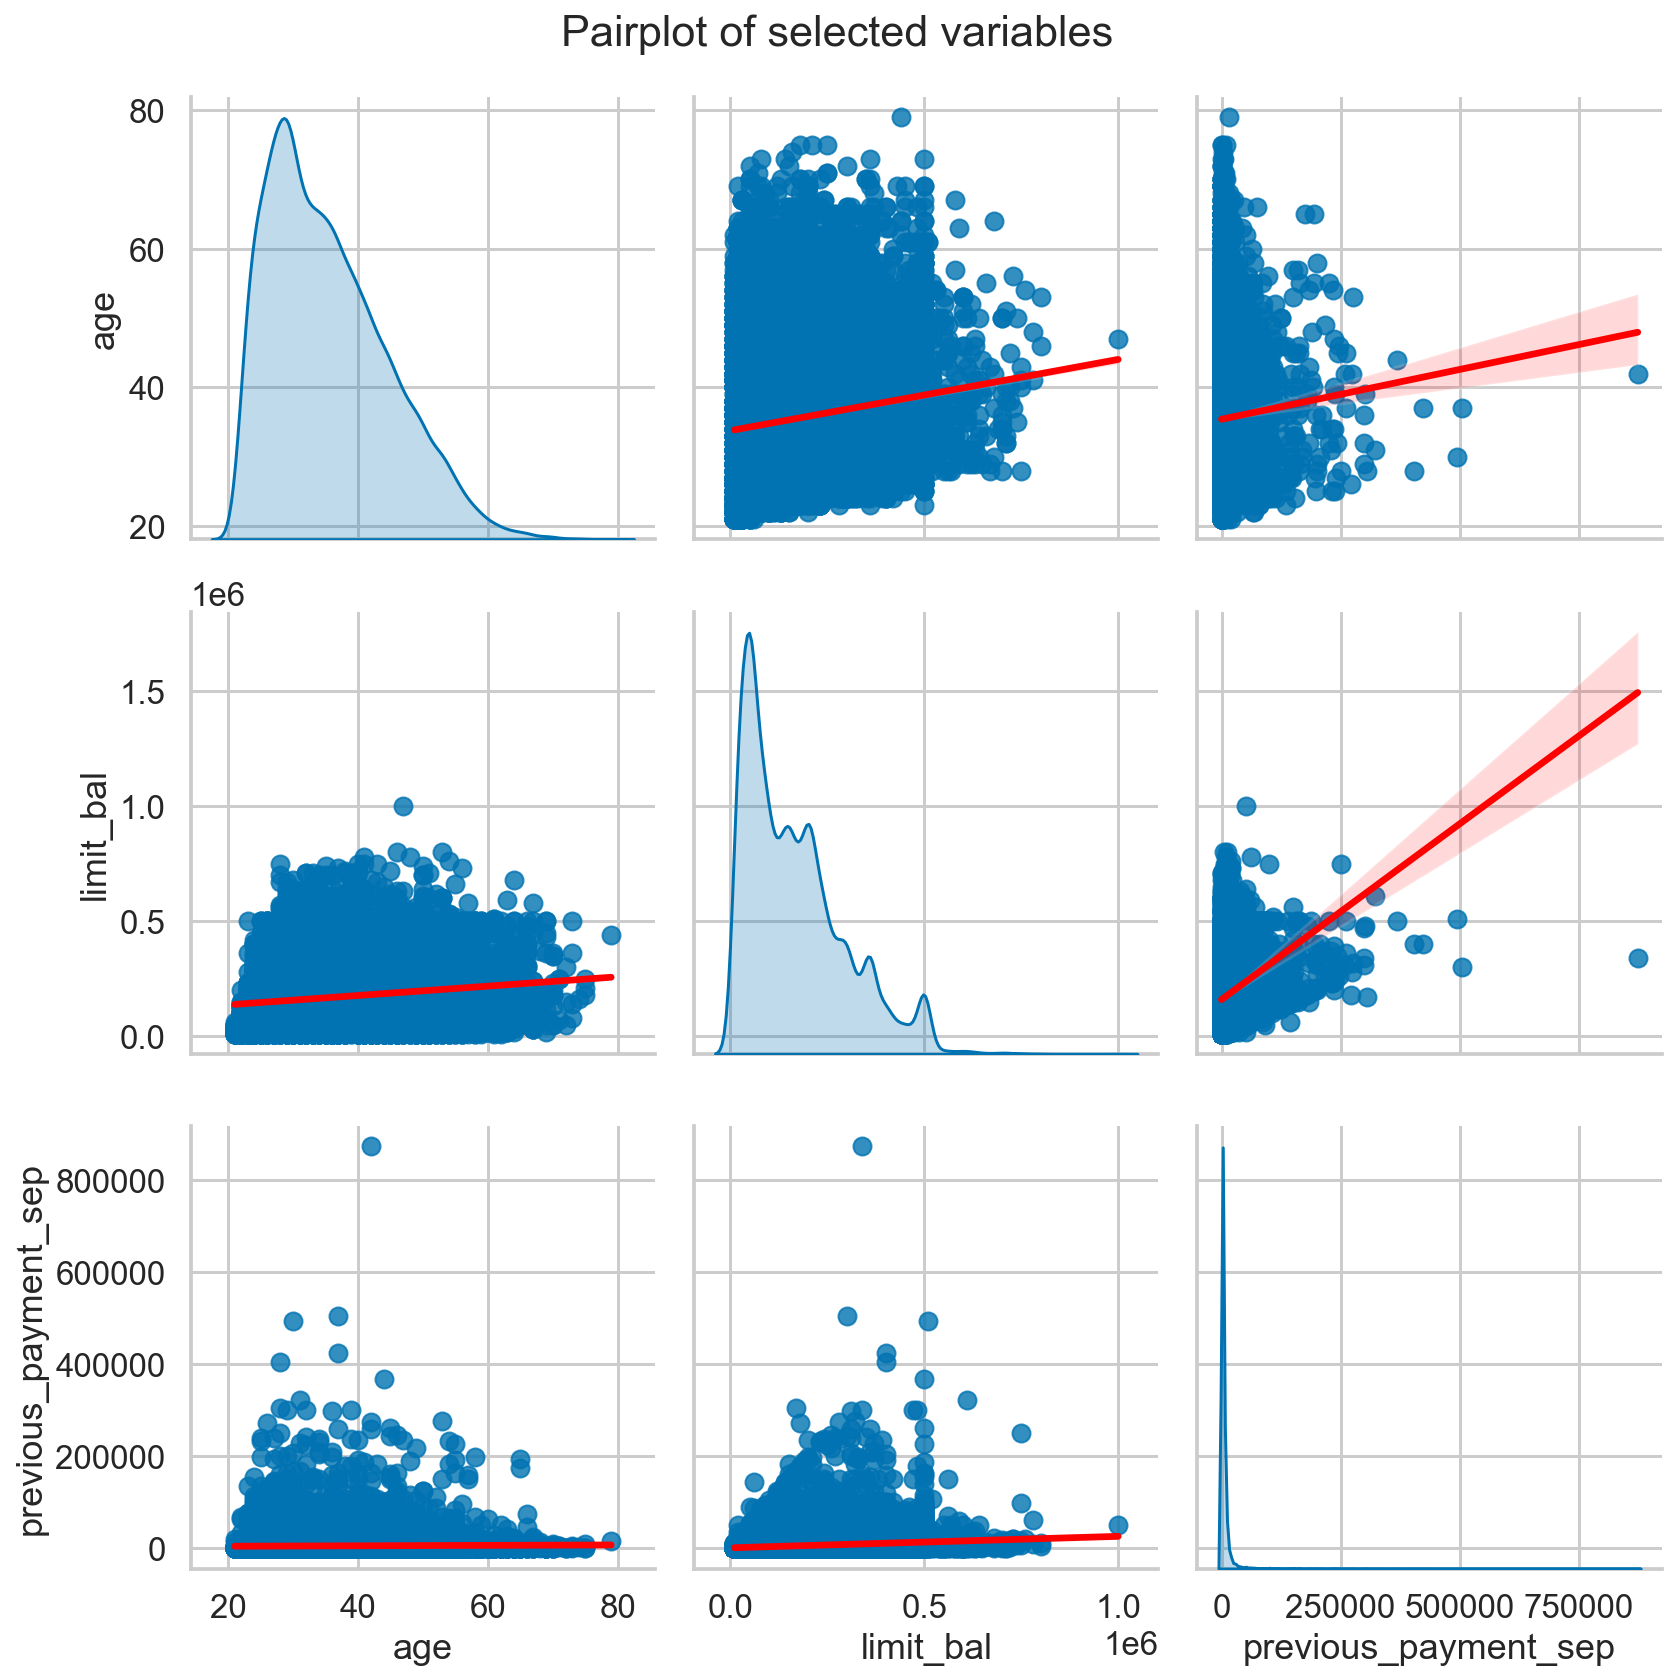

In [14]:
COLS_TO_PLOT = ["age", "limit_bal", "previous_payment_sep"]

pair_plot = sns.pairplot(df[COLS_TO_PLOT], kind="reg", 
                         diag_kind="kde", height=4,
                         plot_kws={"line_kws":{"color":"red"}})
pair_plot.fig.suptitle("Pairplot of selected variables")

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_13_2", dpi=200)

Additionally, we can separate the genders by specifying the `hue` argument:

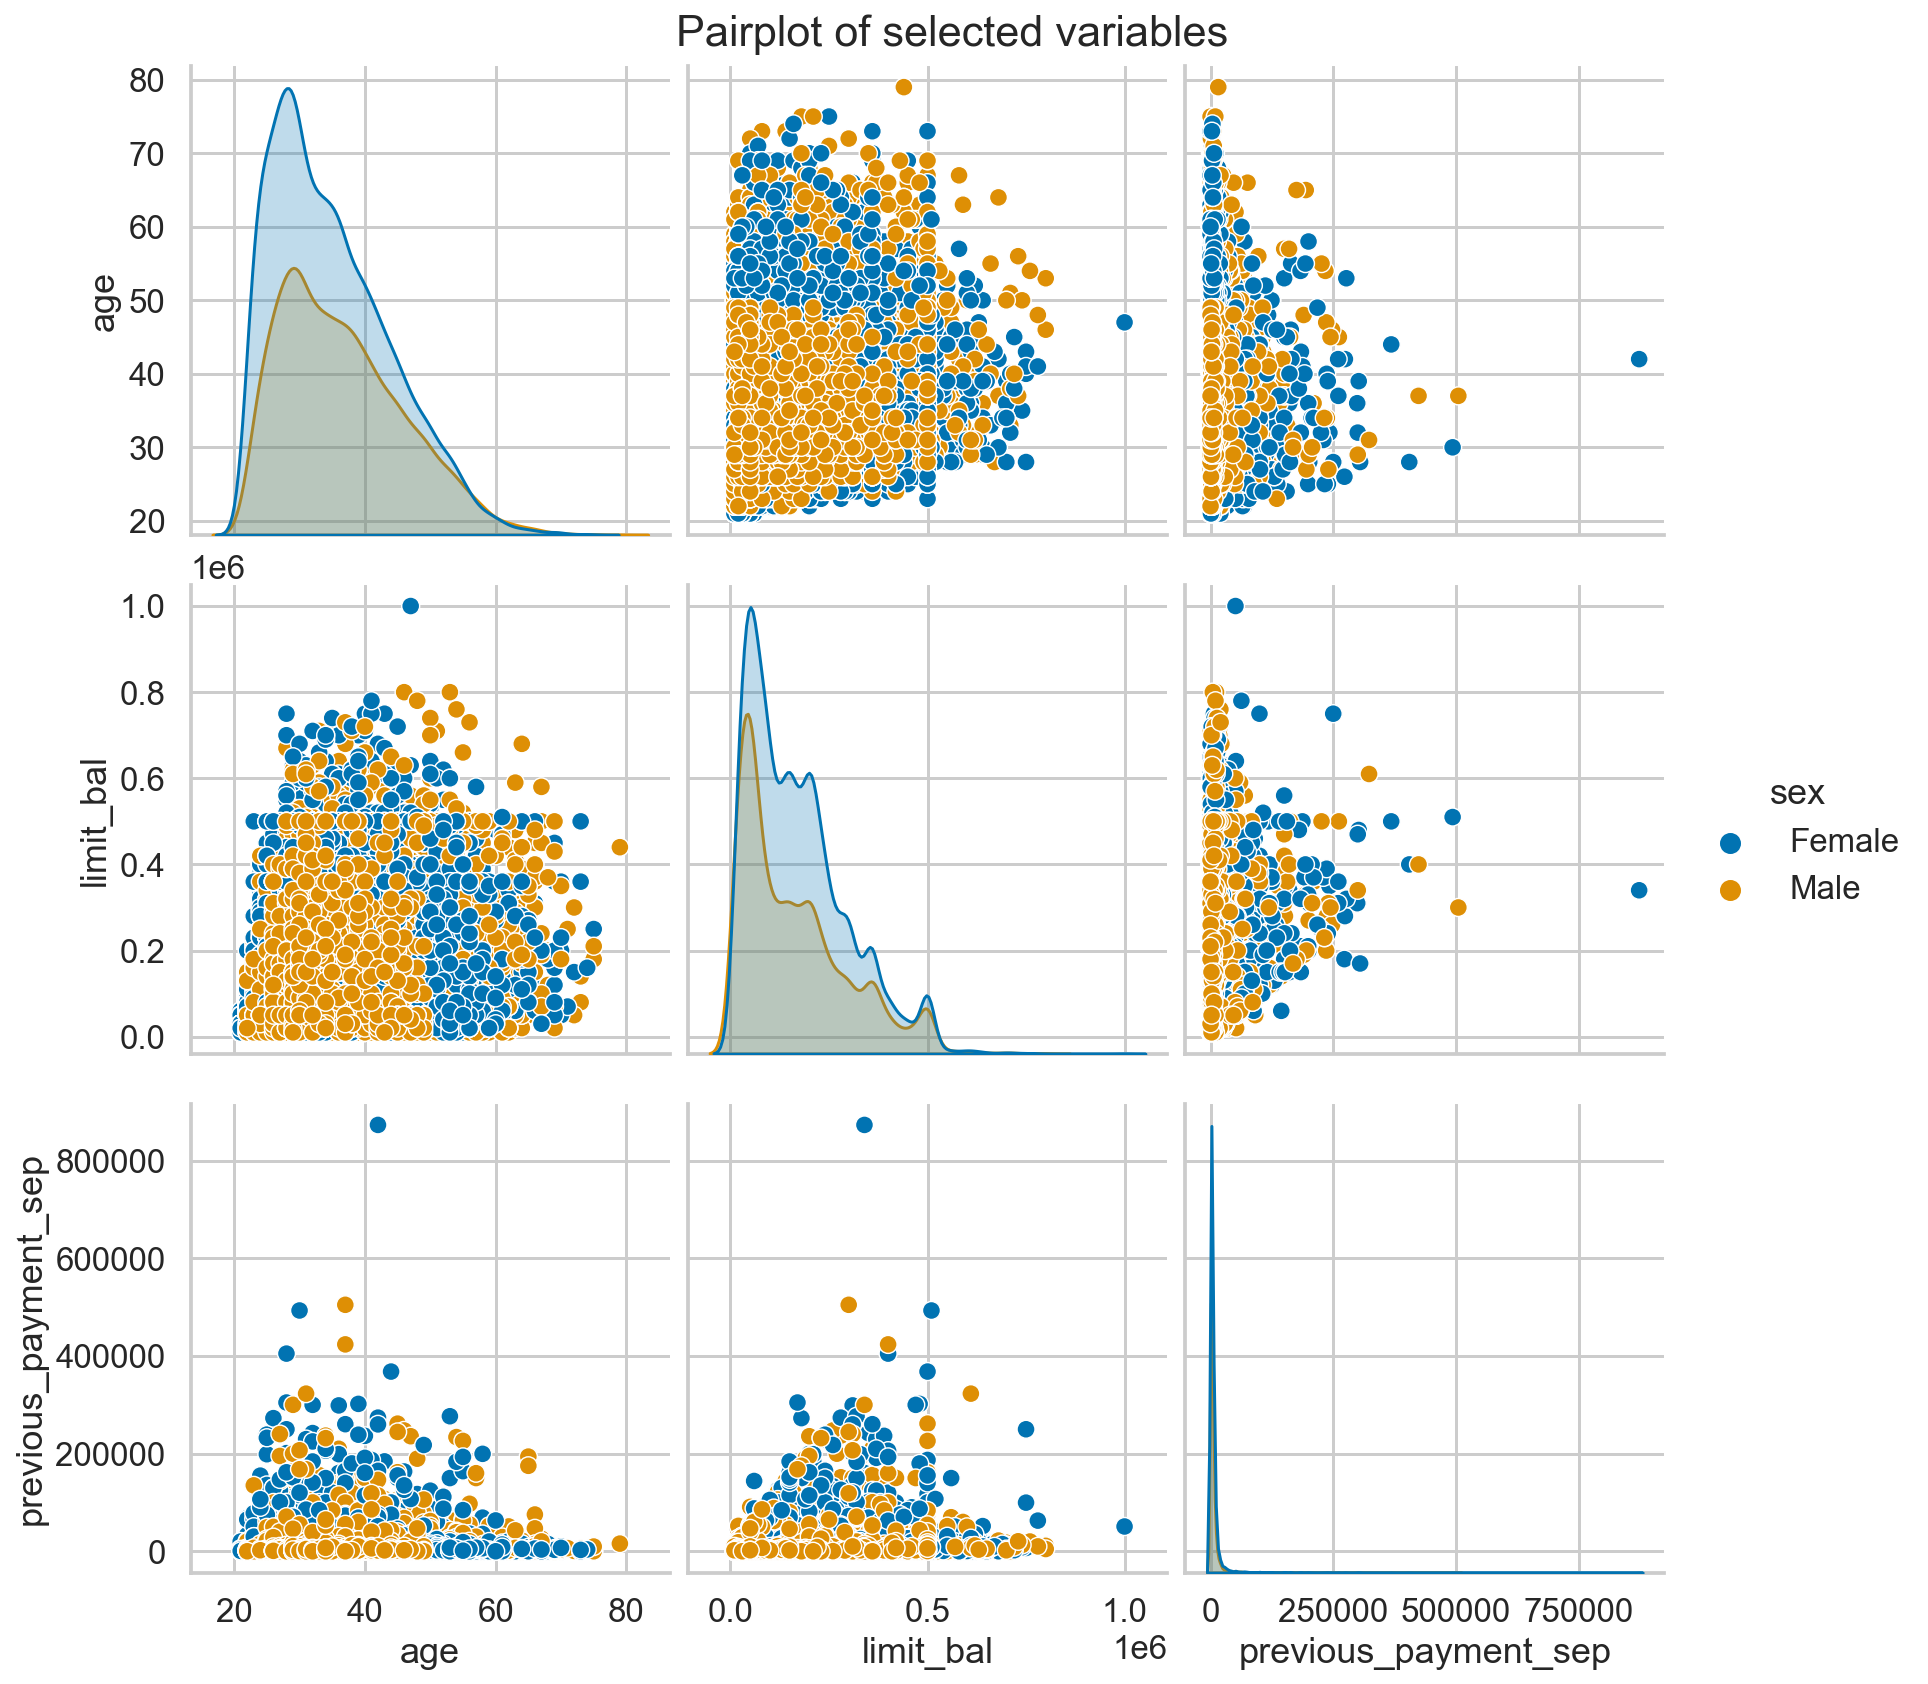

In [15]:
pair_plot = sns.pairplot(data=df, 
                         x_vars=COLS_TO_PLOT, 
                         y_vars=COLS_TO_PLOT, 
                         hue="sex", 
                         height=4)
pair_plot.fig.suptitle("Pairplot of selected variables")
plt.subplots_adjust(top=0.95)

# plt.savefig("images/figure_13_3", dpi=200)

6. Analyze the relationship between age and limit balance:

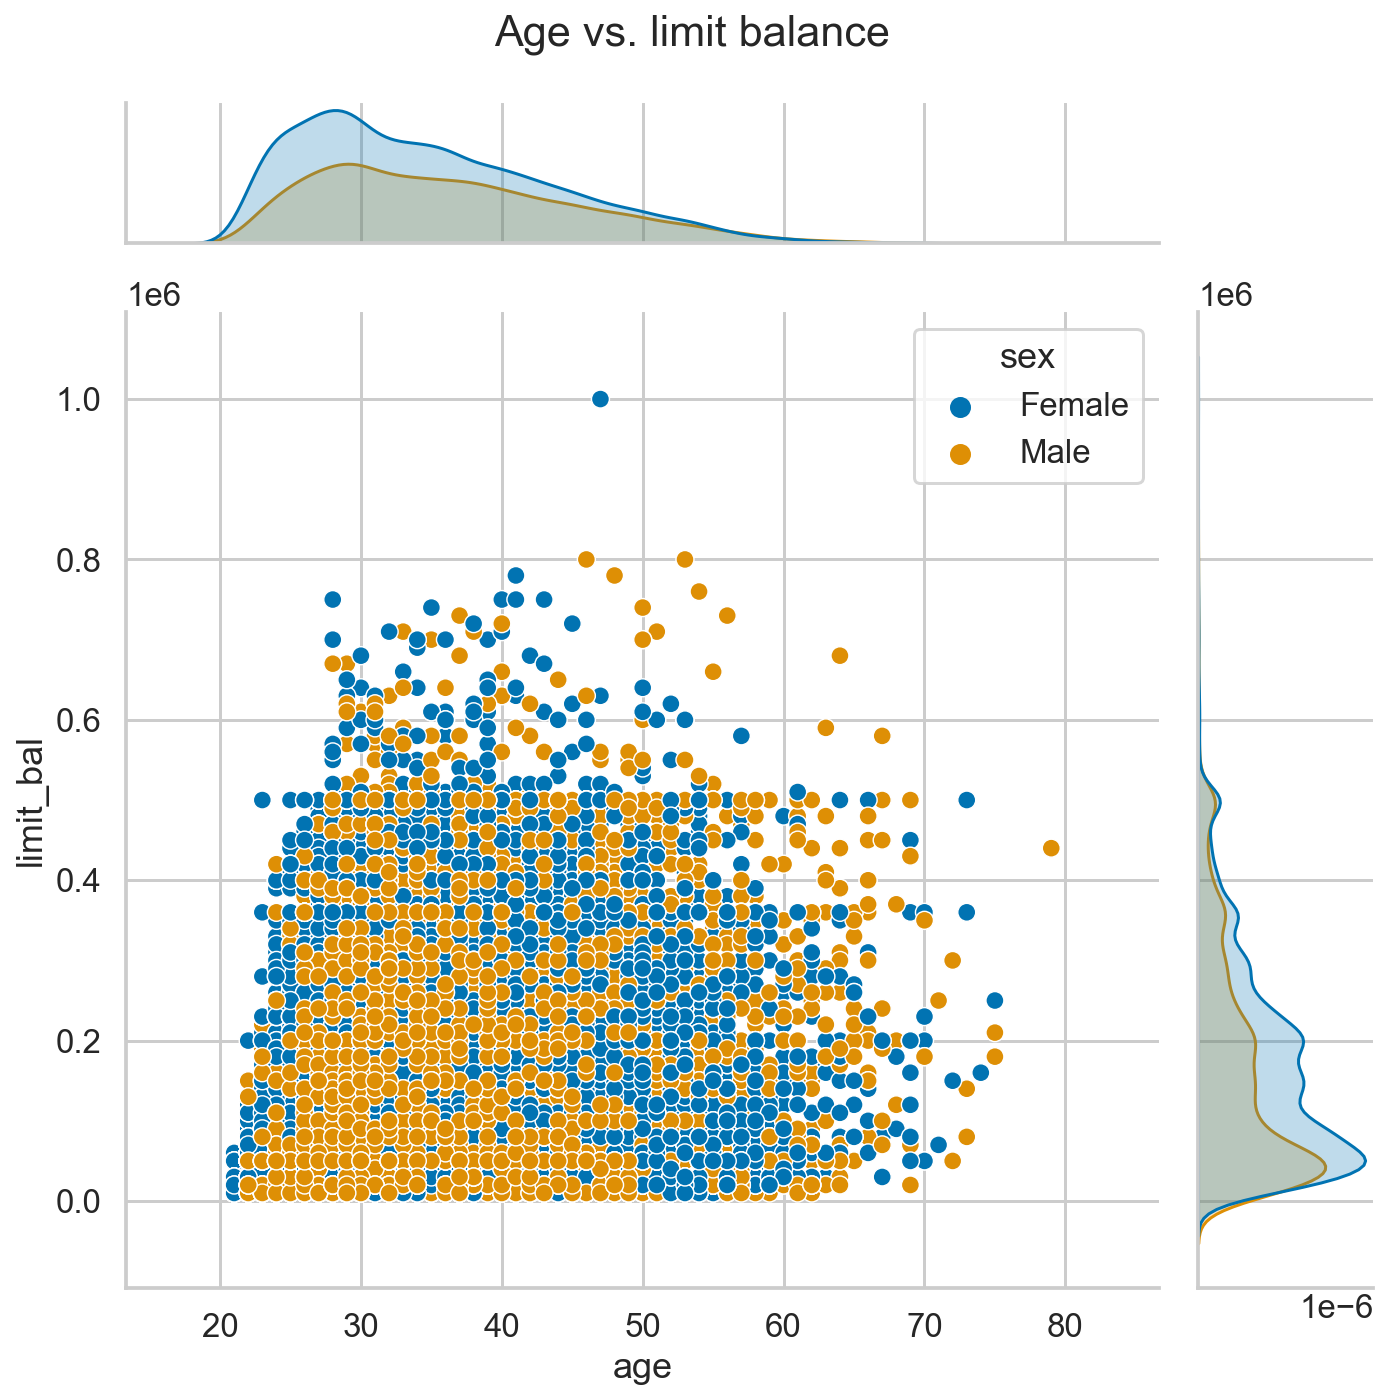

In [16]:
ax = sns.jointplot(data=df, x="age", y="limit_bal", 
                   hue="sex", height=10)
ax.fig.suptitle("Age vs. limit balance")

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_13_4", dpi=200)

7. Define and run a function for plotting the correlation heatmap:

In [17]:
def plot_correlation_matrix(corr_mat, annotate=False):
    """
    Function for plotting the correlation heatmap. It masks the irrelevant fields.
    
    Parameters
    ----------
    corr_mat : pd.DataFrame
        Correlation matrix of the features.
    """
    
    # temporarily change style
    sns.set(style="white")
    # mask the upper triangle
    mask = np.zeros_like(corr_mat, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    # set up the matplotlib figure
    fig, ax = plt.subplots()
    # set up custom diverging colormap
    cmap = sns.diverging_palette(240, 10, n=9, as_cmap=True)
    # plot the heatmap
    sns.heatmap(corr_mat, mask=mask, cmap=cmap, 
                annot=annotate, vmax=.3, 
                center=0, square=True, linewidths=.5, 
                cbar_kws={"shrink": .5}, ax=ax)
    ax.set_title("Correlation Matrix", fontsize=16)
    # change back to darkgrid style
    sns.set(style="darkgrid")

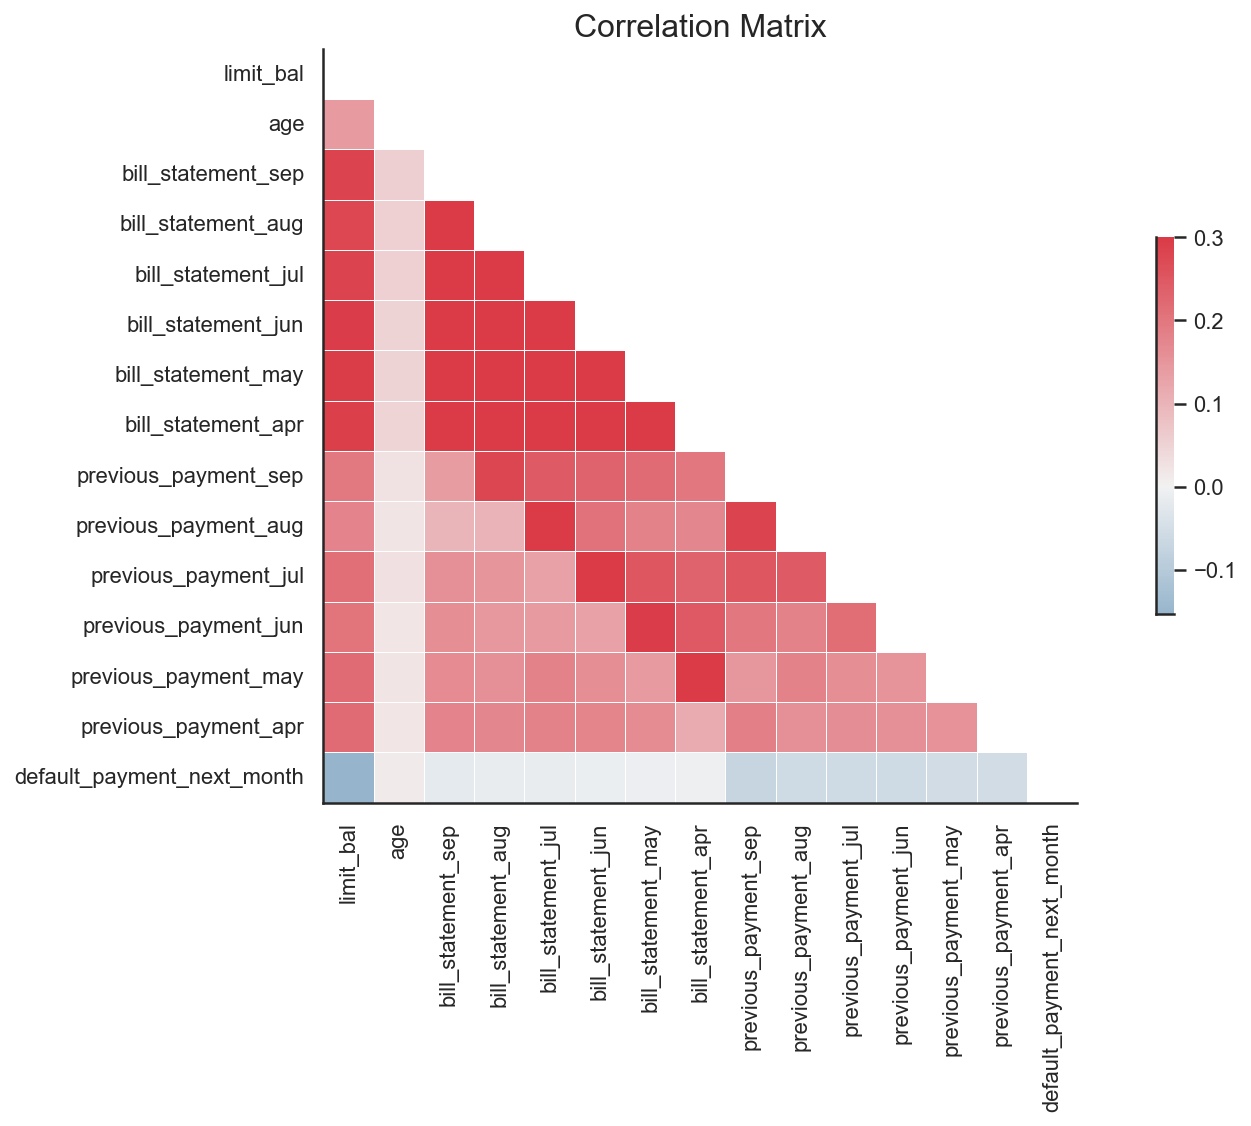

In [18]:
corr_mat = df.select_dtypes(include="number").corr()    
plot_correlation_matrix(corr_mat)

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_13_5", dpi=200)

We can also directly inspect the correlation between the features (numerical) and the target:

In [19]:
df.select_dtypes(include="number").corr()[["default_payment_next_month"]]

default_payment_next_month
limit_bal                                    -0.153520
age                                           0.014491
bill_statement_sep                           -0.019644
bill_statement_aug                           -0.014193
bill_statement_jul                           -0.014076
bill_statement_jun                           -0.010156
bill_statement_may                           -0.006760
bill_statement_apr                           -0.005372
previous_payment_sep                         -0.072929
previous_payment_aug                         -0.058579
previous_payment_jul                         -0.056250
previous_payment_jun                         -0.056827
previous_payment_may                         -0.055124
previous_payment_apr                         -0.053183
default_payment_next_month                    1.000000

8. Analyze the distribution of age in groups using boxplots:

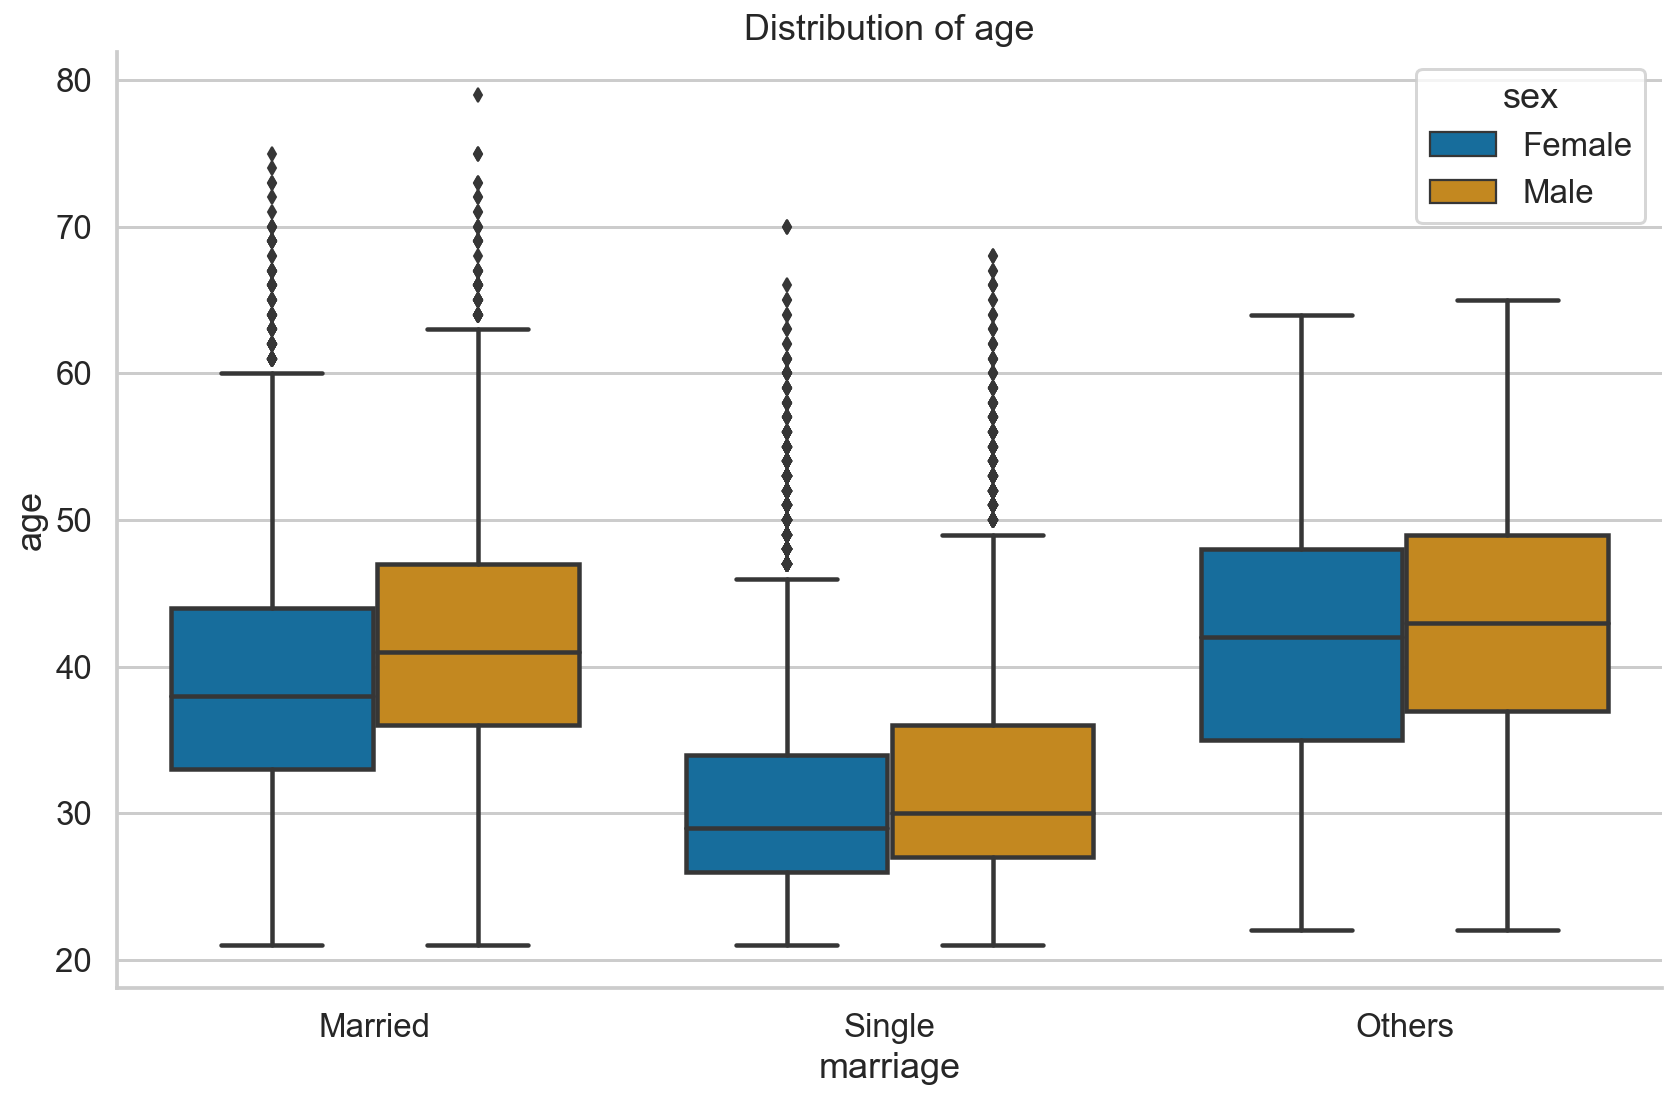

In [24]:
ax = sns.boxplot(data=df, y="age", x="marriage", hue="sex");
ax.set_title("Distribution of age")

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_13_6", dpi=200)

9. Plot the distribution of limit balance for each gender and education level:

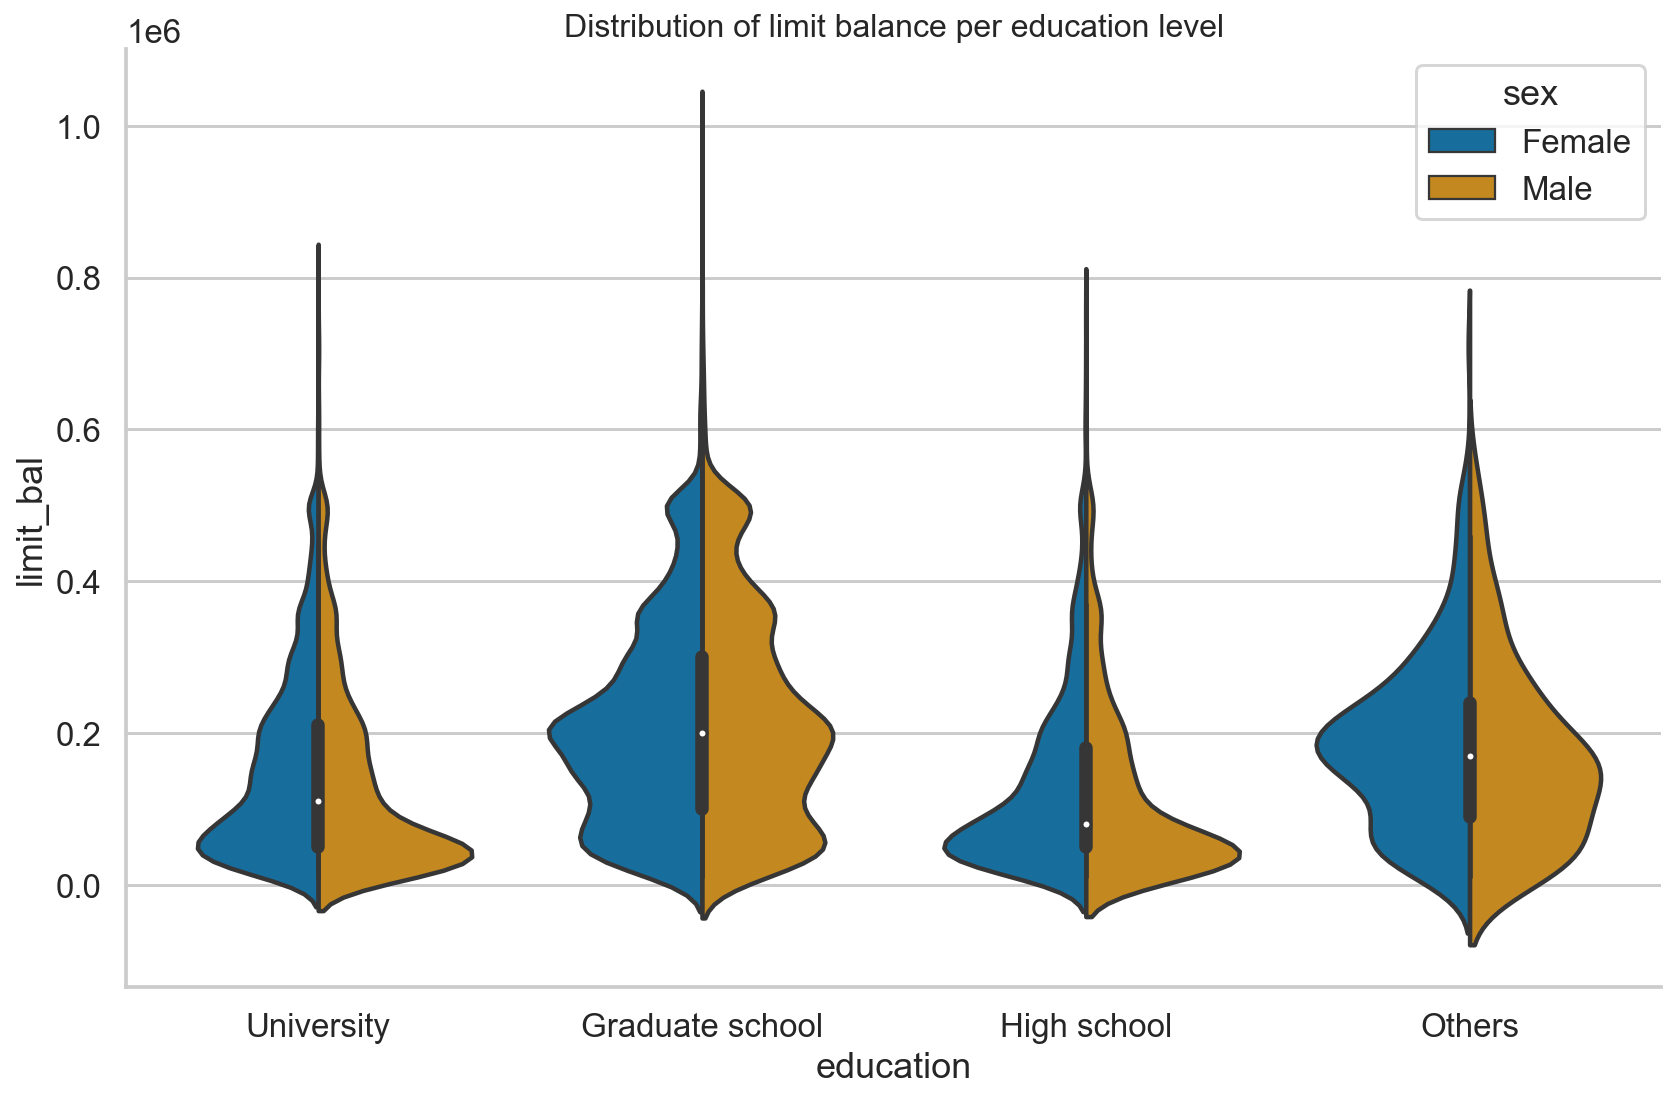

In [25]:
ax = sns.violinplot(x="education", y="limit_bal", 
                    hue="sex", split=True, data=df)
ax.set_title(
    "Distribution of limit balance per education level", 
    fontsize=16
)

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_13_7", dpi=200)

The following code plots the same information, without splitting the violin plots.

In [ ]:
ax = sns.violinplot(x="education", y="limit_bal", 
                    hue="sex", data=df)
ax.set_title("Distribution of limit balance per education level", 
             fontsize=16)

sns.despine()
plt.tight_layout()

10. Investigate the distribution of the target variable per gender and education level:

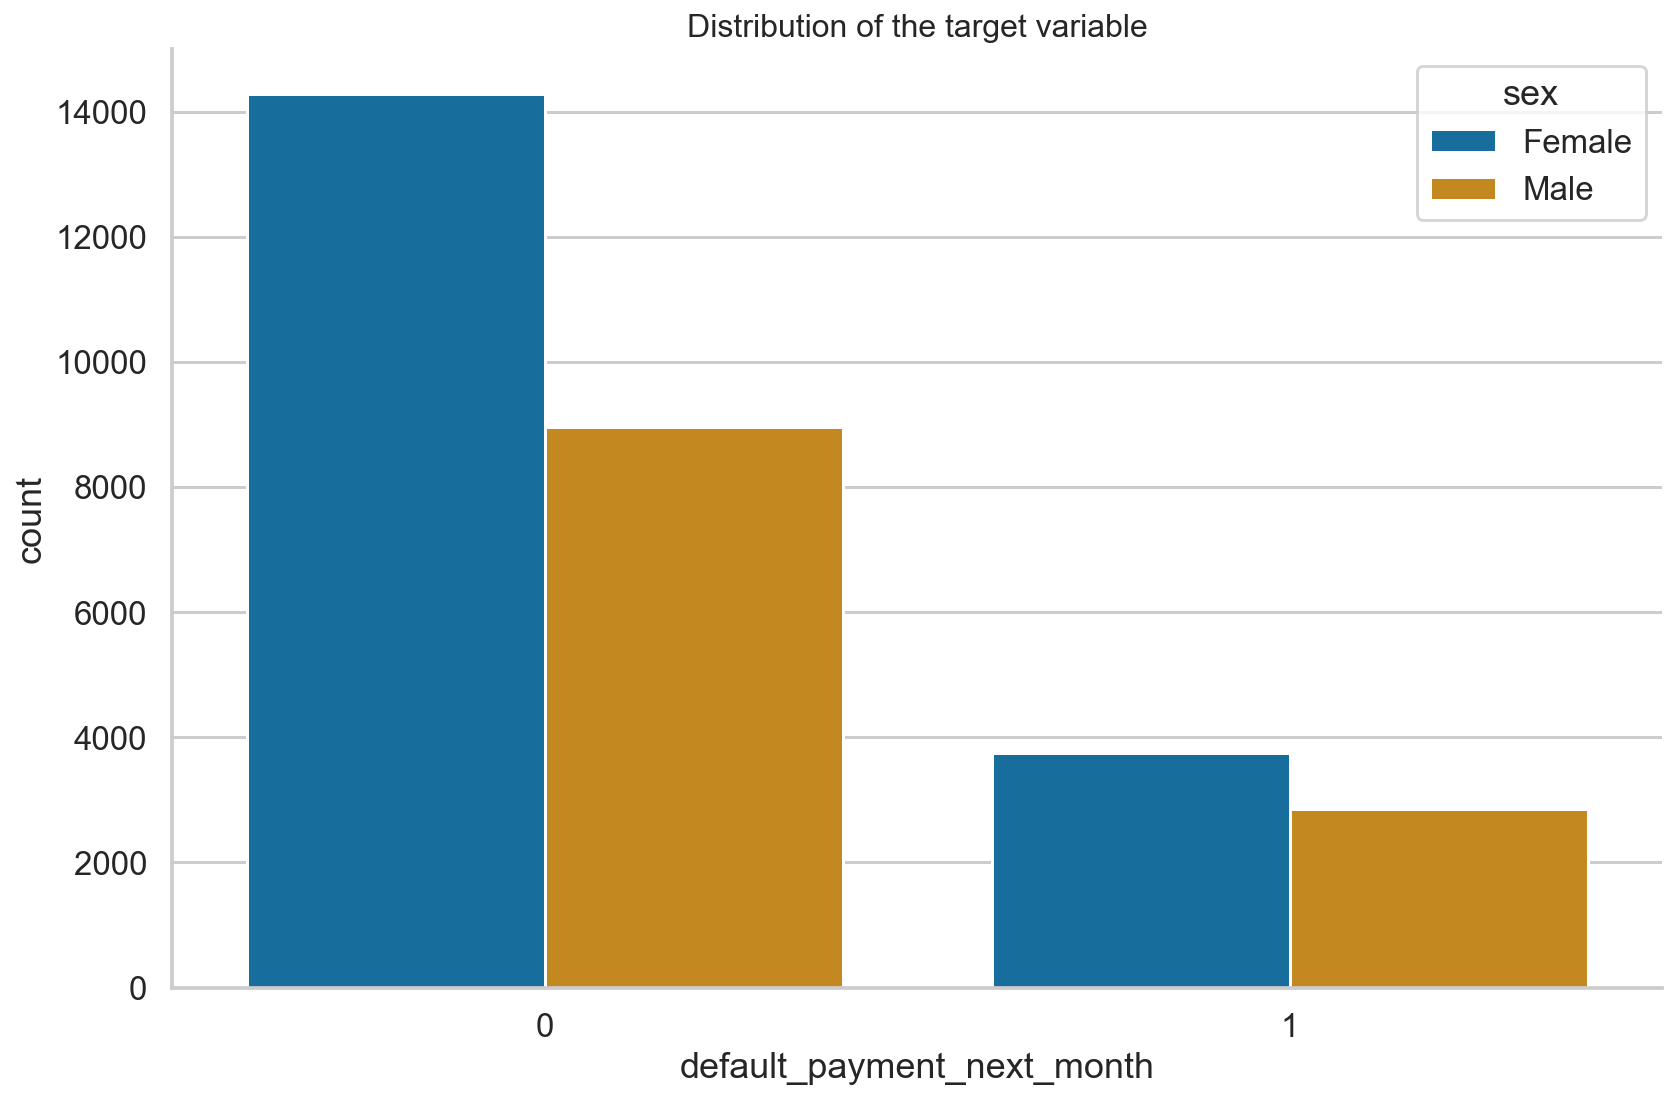

In [26]:
ax = sns.countplot("default_payment_next_month", hue="sex", 
                   data=df, orient="h")
ax.set_title("Distribution of the target variable", fontsize=16)

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_13_8", dpi=200)

11. Investigate the percentage of defaults per education level:

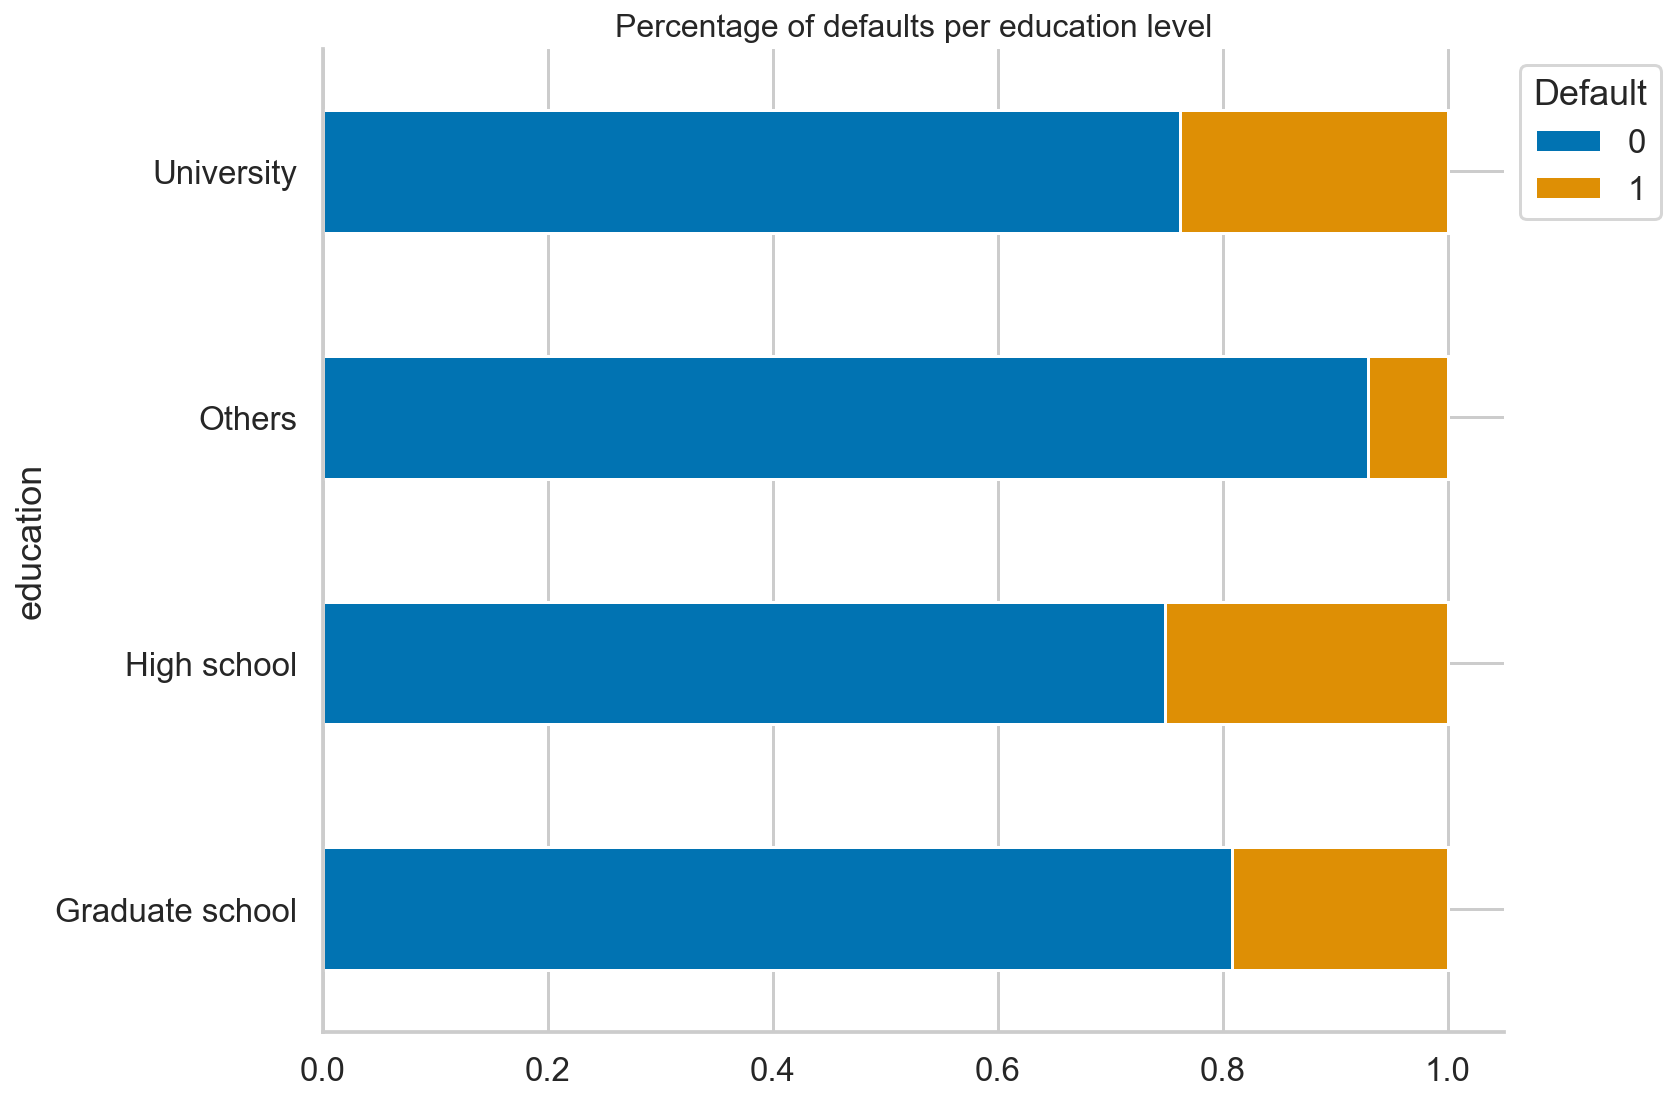

In [6]:
ax = df.groupby("education")["default_payment_next_month"] \
       .value_counts(normalize=True) \
       .unstack() \
       .plot(kind="barh", stacked=True)
ax.set_title("Percentage of defaults per education level", 
             fontsize=16)
ax.legend(title="Default", bbox_to_anchor=(1,1)) 

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_13_9", dpi=200)

### There's more

In [ ]:
from pandas_profiling import ProfileReport
profile = ProfileReport(df, title="Loan Default Dataset EDA")
profile

In [ ]:
profile.to_file("loan_default_eda.html")

## 13.3 Splitting the data into training and test sets

### Getting ready

In [3]:
import pandas as pd
df = pd.read_csv("../Datasets/credit_card_default.csv", na_values="")

### How to do it...

1. Import the libraries:

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

2. Separate the target from the features:

In [5]:
X = df.copy()
y = X.pop("default_payment_next_month")

3. Split the data into training and test sets:

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

4. Split the data into training and test sets without shuffling:

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

5. Split the data into training and test sets with stratification:

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

6. Verify that the ratio of the target is preserved:

In [9]:
print("Target distribution - train")
print(y_train.value_counts(normalize=True).values)
print("Target distribution - test")
print(y_test.value_counts(normalize=True).values)

Target distribution - train
[0.77879167 0.22120833]
Target distribution - test
[0.77883333 0.22116667]


### There's more

In [ ]:
import numpy as np

# define the size of the validation and test sets
VALID_SIZE = 0.1
TEST_SIZE = 0.2

# create the initial split - training and temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, 
    test_size=(VALID_SIZE + TEST_SIZE), 
    stratify=y, 
    random_state=42
)

# calculate the new test size
new_test_size = np.around(TEST_SIZE / (VALID_SIZE + TEST_SIZE), 2)

# create the valid and test sets
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, 
    test_size=new_test_size, 
    stratify=y_temp, 
    random_state=42
)

In [ ]:
print("Percentage of data in each set ----")
print(f"Train: {100 * len(X_train) / len(X):.2f}%")
print(f"Valid: {100 * len(X_valid) / len(X):.2f}%")
print(f"Test: {100 * len(X_test) / len(X):.2f}%")
print("")
print("Class distribution in each set ----")
print(f"Train: {y_train.value_counts(normalize=True).values}")
print(f"Valid: {y_valid.value_counts(normalize=True).values}")
print(f"Test: {y_test.value_counts(normalize=True).values}")

## 13.4 Identifying and dealing with missing values

### How to do it...

1. Import the libraries:

In [8]:
import pandas as pd 
import missingno as msno
from sklearn.impute import SimpleImputer

2. Inspect the information about the DataFrame:

In [9]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   limit_bal             30000 non-null  int64  
 1   sex                   29850 non-null  object 
 2   education             29850 non-null  object 
 3   marriage              29850 non-null  object 
 4   age                   29850 non-null  float64
 5   payment_status_sep    30000 non-null  object 
 6   payment_status_aug    30000 non-null  object 
 7   payment_status_jul    30000 non-null  object 
 8   payment_status_jun    30000 non-null  object 
 9   payment_status_may    30000 non-null  object 
 10  payment_status_apr    30000 non-null  object 
 11  bill_statement_sep    30000 non-null  int64  
 12  bill_statement_aug    30000 non-null  int64  
 13  bill_statement_jul    30000 non-null  int64  
 14  bill_statement_jun    30000 non-null  int64  
 15  bill_statement_may 

In [10]:
X.isnull().sum()

limit_bal                 0
sex                     150
education               150
marriage                150
age                     150
payment_status_sep        0
payment_status_aug        0
payment_status_jul        0
payment_status_jun        0
payment_status_may        0
payment_status_apr        0
bill_statement_sep        0
bill_statement_aug        0
bill_statement_jul        0
bill_statement_jun        0
bill_statement_may        0
bill_statement_apr        0
previous_payment_sep      0
previous_payment_aug      0
previous_payment_jul      0
previous_payment_jun      0
previous_payment_may      0
previous_payment_apr      0
dtype: int64

3. Visualize the nullity of the DataFrame:

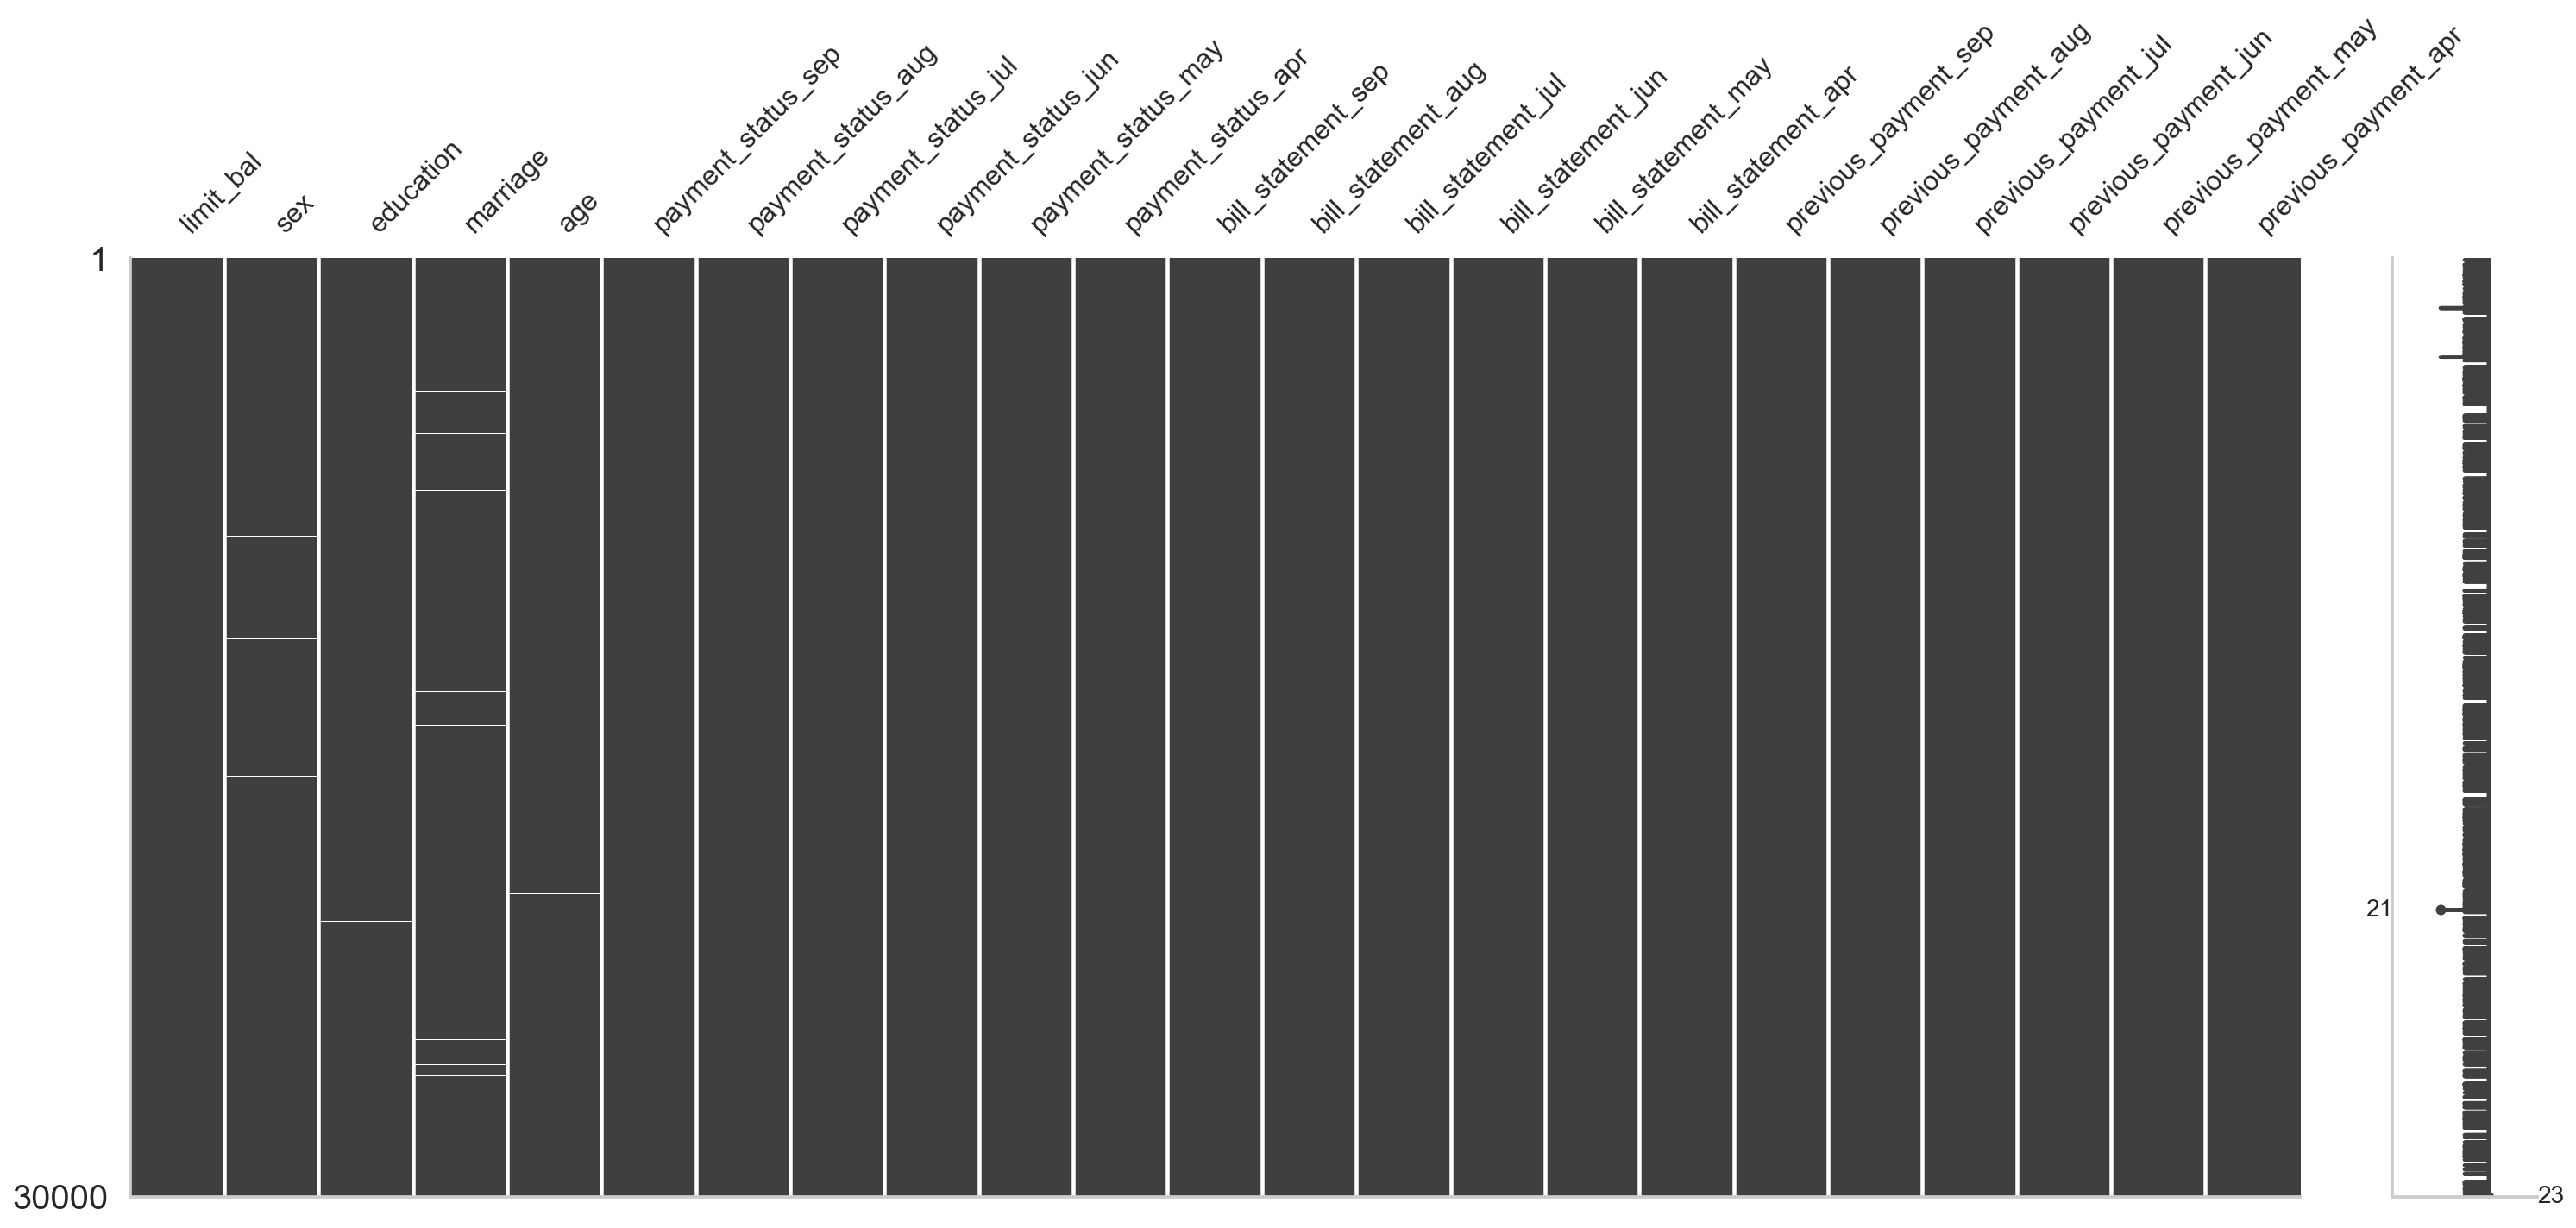

In [11]:
msno.matrix(X)

sns.despine()
# plt.savefig("images/figure_13_12", dpi=200)

4. Define columns with missing values per data type:

In [12]:
NUM_FEATURES = ["age"]
CAT_FEATURES = ["sex", "education", "marriage"]

5. Impute the numerical feature:

In [13]:
for col in NUM_FEATURES:
    num_imputer = SimpleImputer(strategy="median")
    num_imputer.fit(X_train[[col]])
    X_train.loc[:, col] = num_imputer.transform(X_train[[col]])
    X_test.loc[:, col] = num_imputer.transform(X_test[[col]])

In [14]:
# alternative method using pandas

# for feature in NUM_FEATURES:
#     median_value = X_train[feature].median()
#     X_train.loc[:, feature].fillna(median_value, inplace=True)
#     X_test.loc[:, feature].fillna(median_value, inplace=True)

6. Impute the categorical features:

In [15]:
for col in CAT_FEATURES:
    cat_imputer = SimpleImputer(strategy="most_frequent")
    cat_imputer.fit(X_train[[col]])
    X_train.loc[:, col] = cat_imputer.transform(X_train[[col]])
    X_test.loc[:, col] = cat_imputer.transform(X_test[[col]])

In [16]:
# alternative method using pandas

# for feature in CAT_FEATURES:
#     mode_value = X_train[feature].mode().values[0]
#     X_train.loc[:, feature].fillna(mode_value, inplace=True)
#     X_test.loc[:, feature].fillna(mode_value, inplace=True)

7. Verify that there are no missing values:

In [17]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24000 entries, 22788 to 27126
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   limit_bal             24000 non-null  int64  
 1   sex                   24000 non-null  object 
 2   education             24000 non-null  object 
 3   marriage              24000 non-null  object 
 4   age                   24000 non-null  float64
 5   payment_status_sep    24000 non-null  object 
 6   payment_status_aug    24000 non-null  object 
 7   payment_status_jul    24000 non-null  object 
 8   payment_status_jun    24000 non-null  object 
 9   payment_status_may    24000 non-null  object 
 10  payment_status_apr    24000 non-null  object 
 11  bill_statement_sep    24000 non-null  int64  
 12  bill_statement_aug    24000 non-null  int64  
 13  bill_statement_jul    24000 non-null  int64  
 14  bill_statement_jun    24000 non-null  int64  
 15  bill_statement_

### There's more

We also look into the other types of visualizations offered by `missingno`.

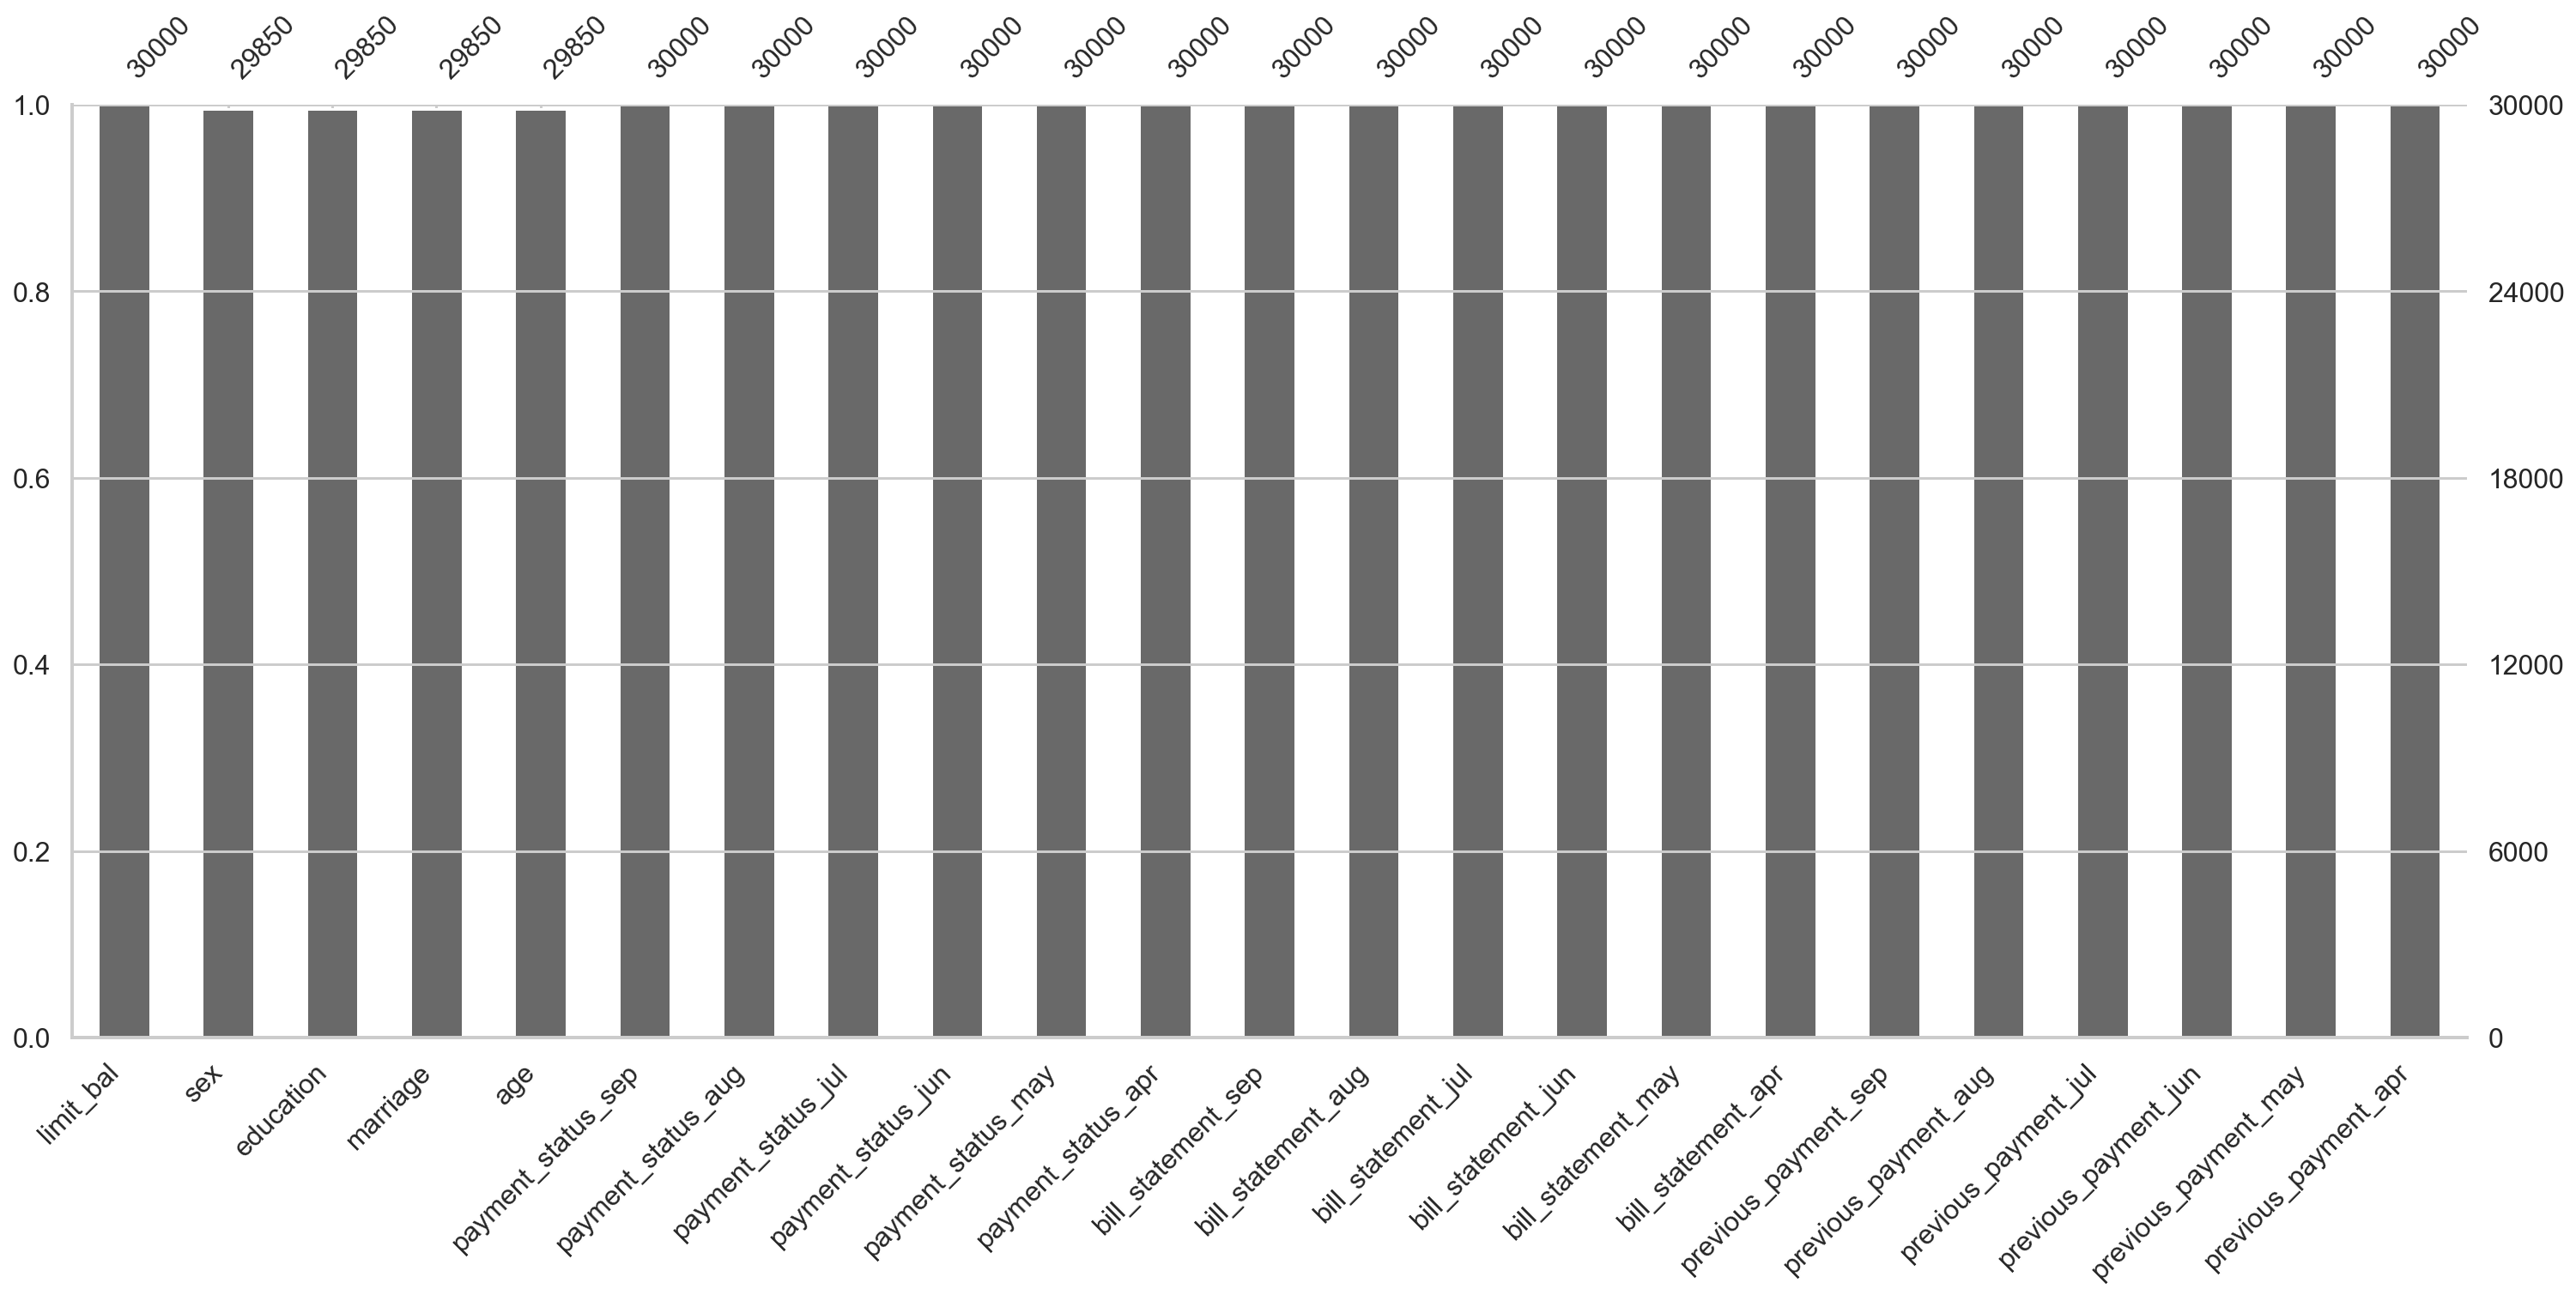

In [18]:
msno.bar(X)

sns.despine()
plt.show()

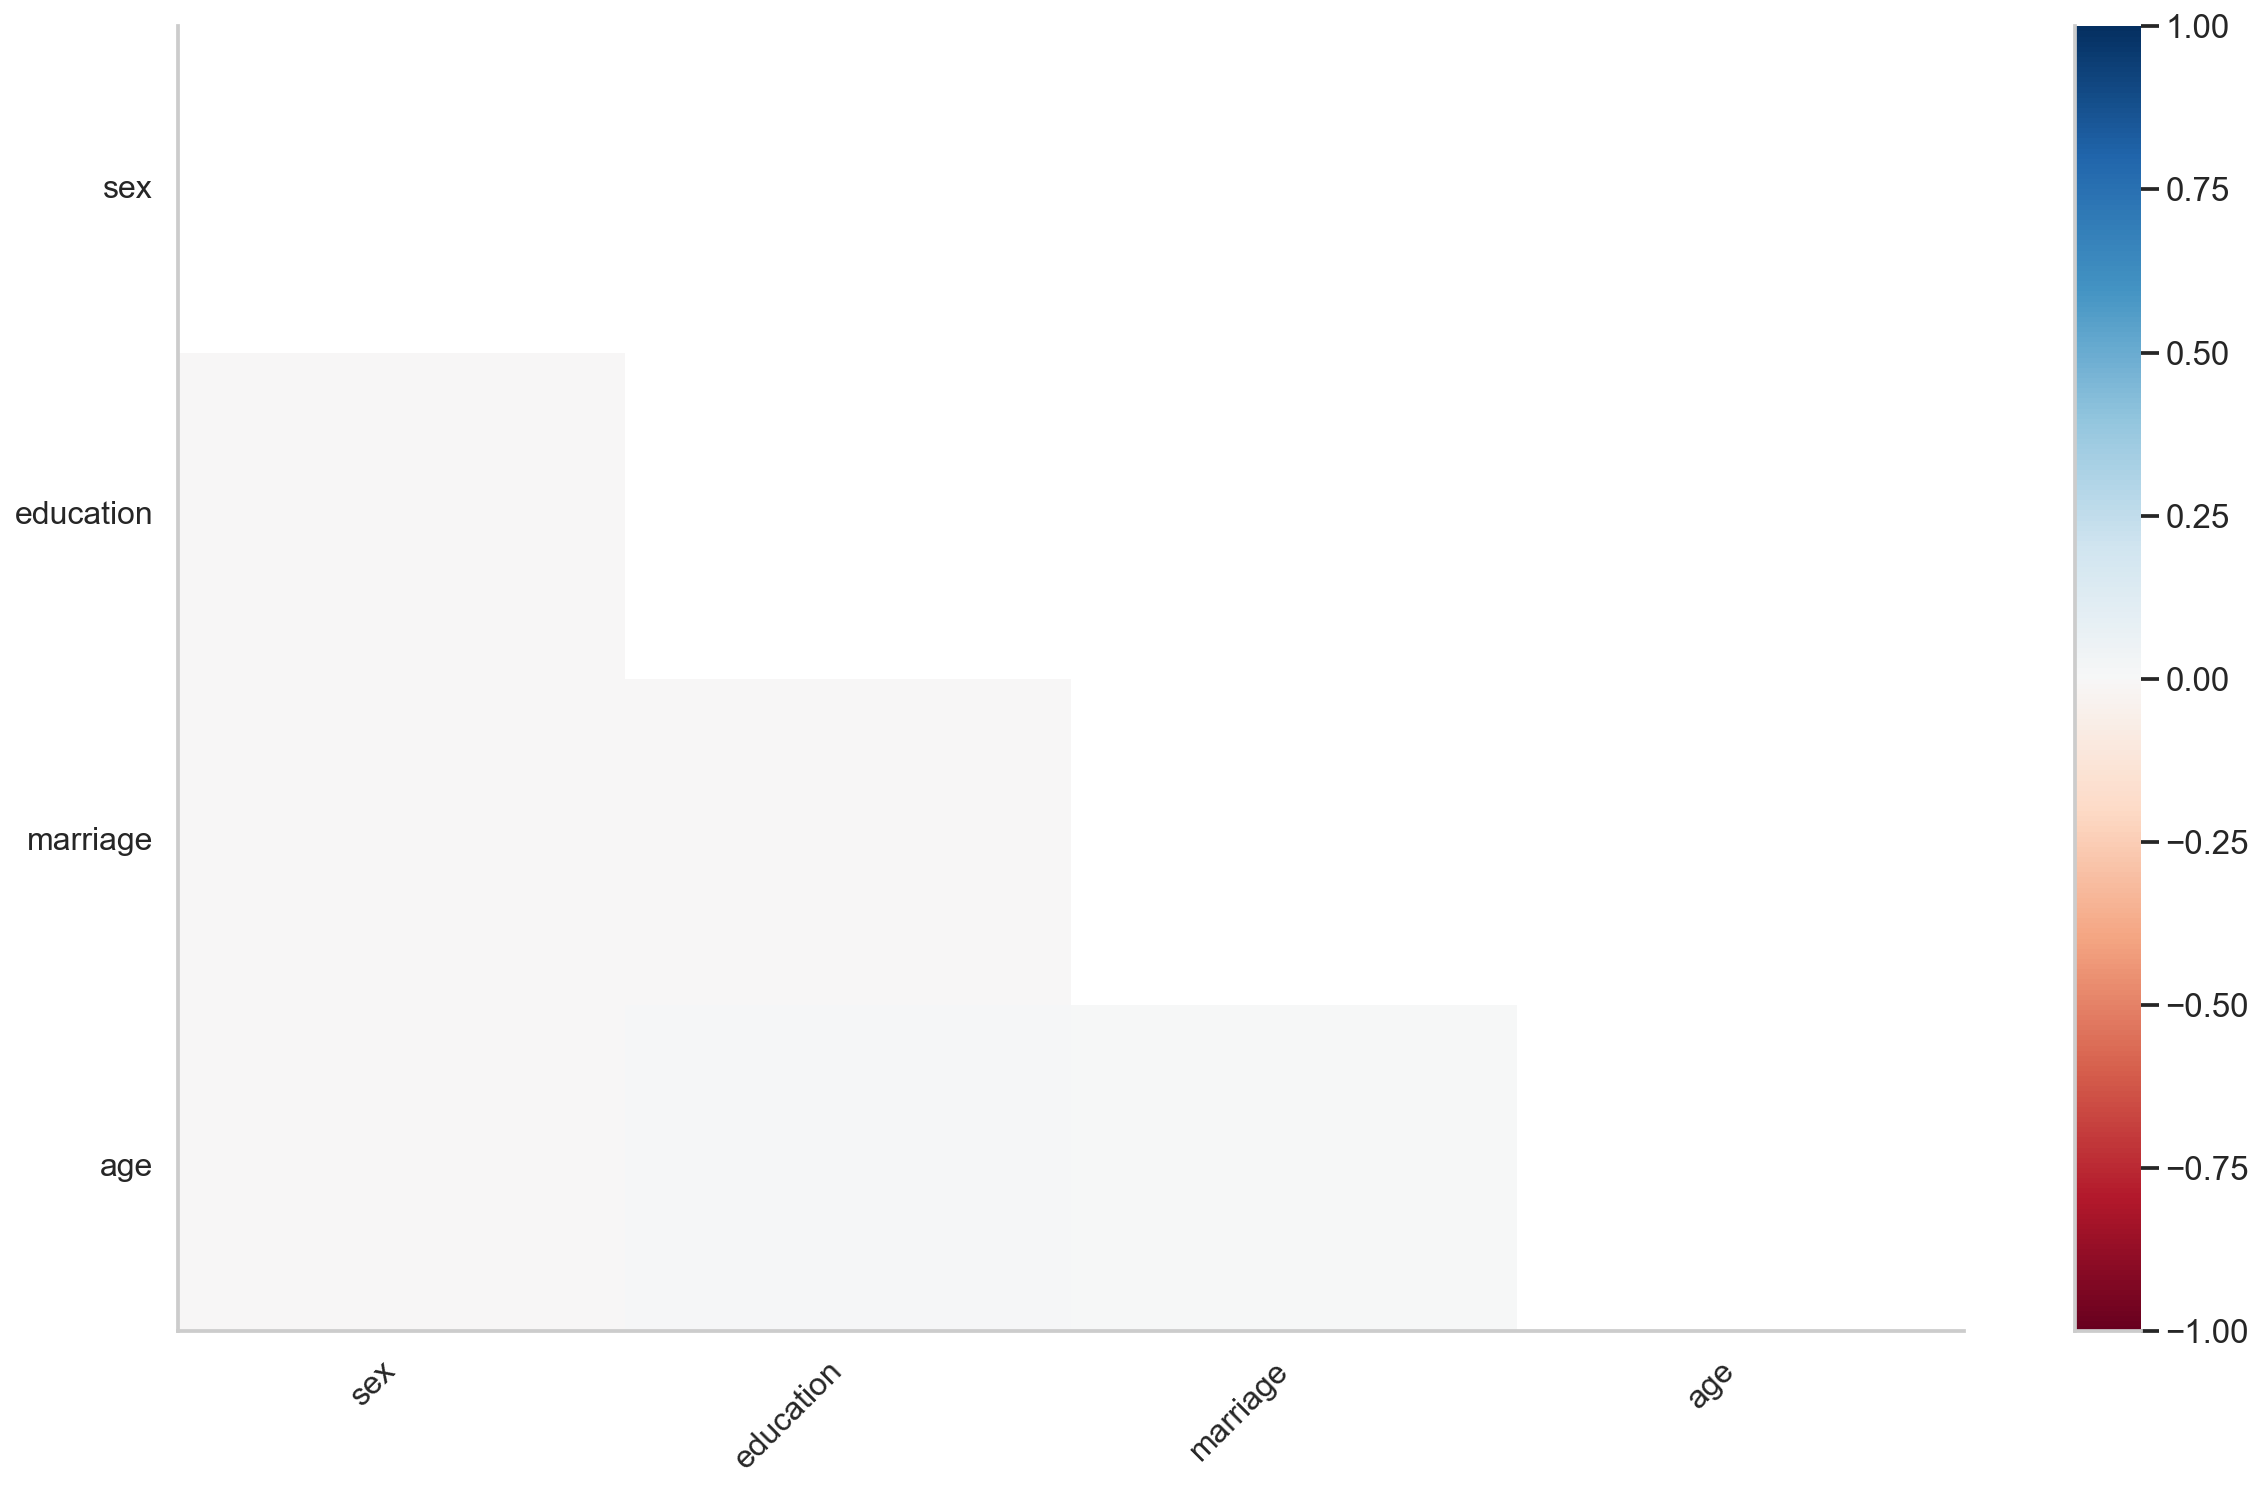

In [19]:
msno.heatmap(X)

sns.despine()
plt.show()

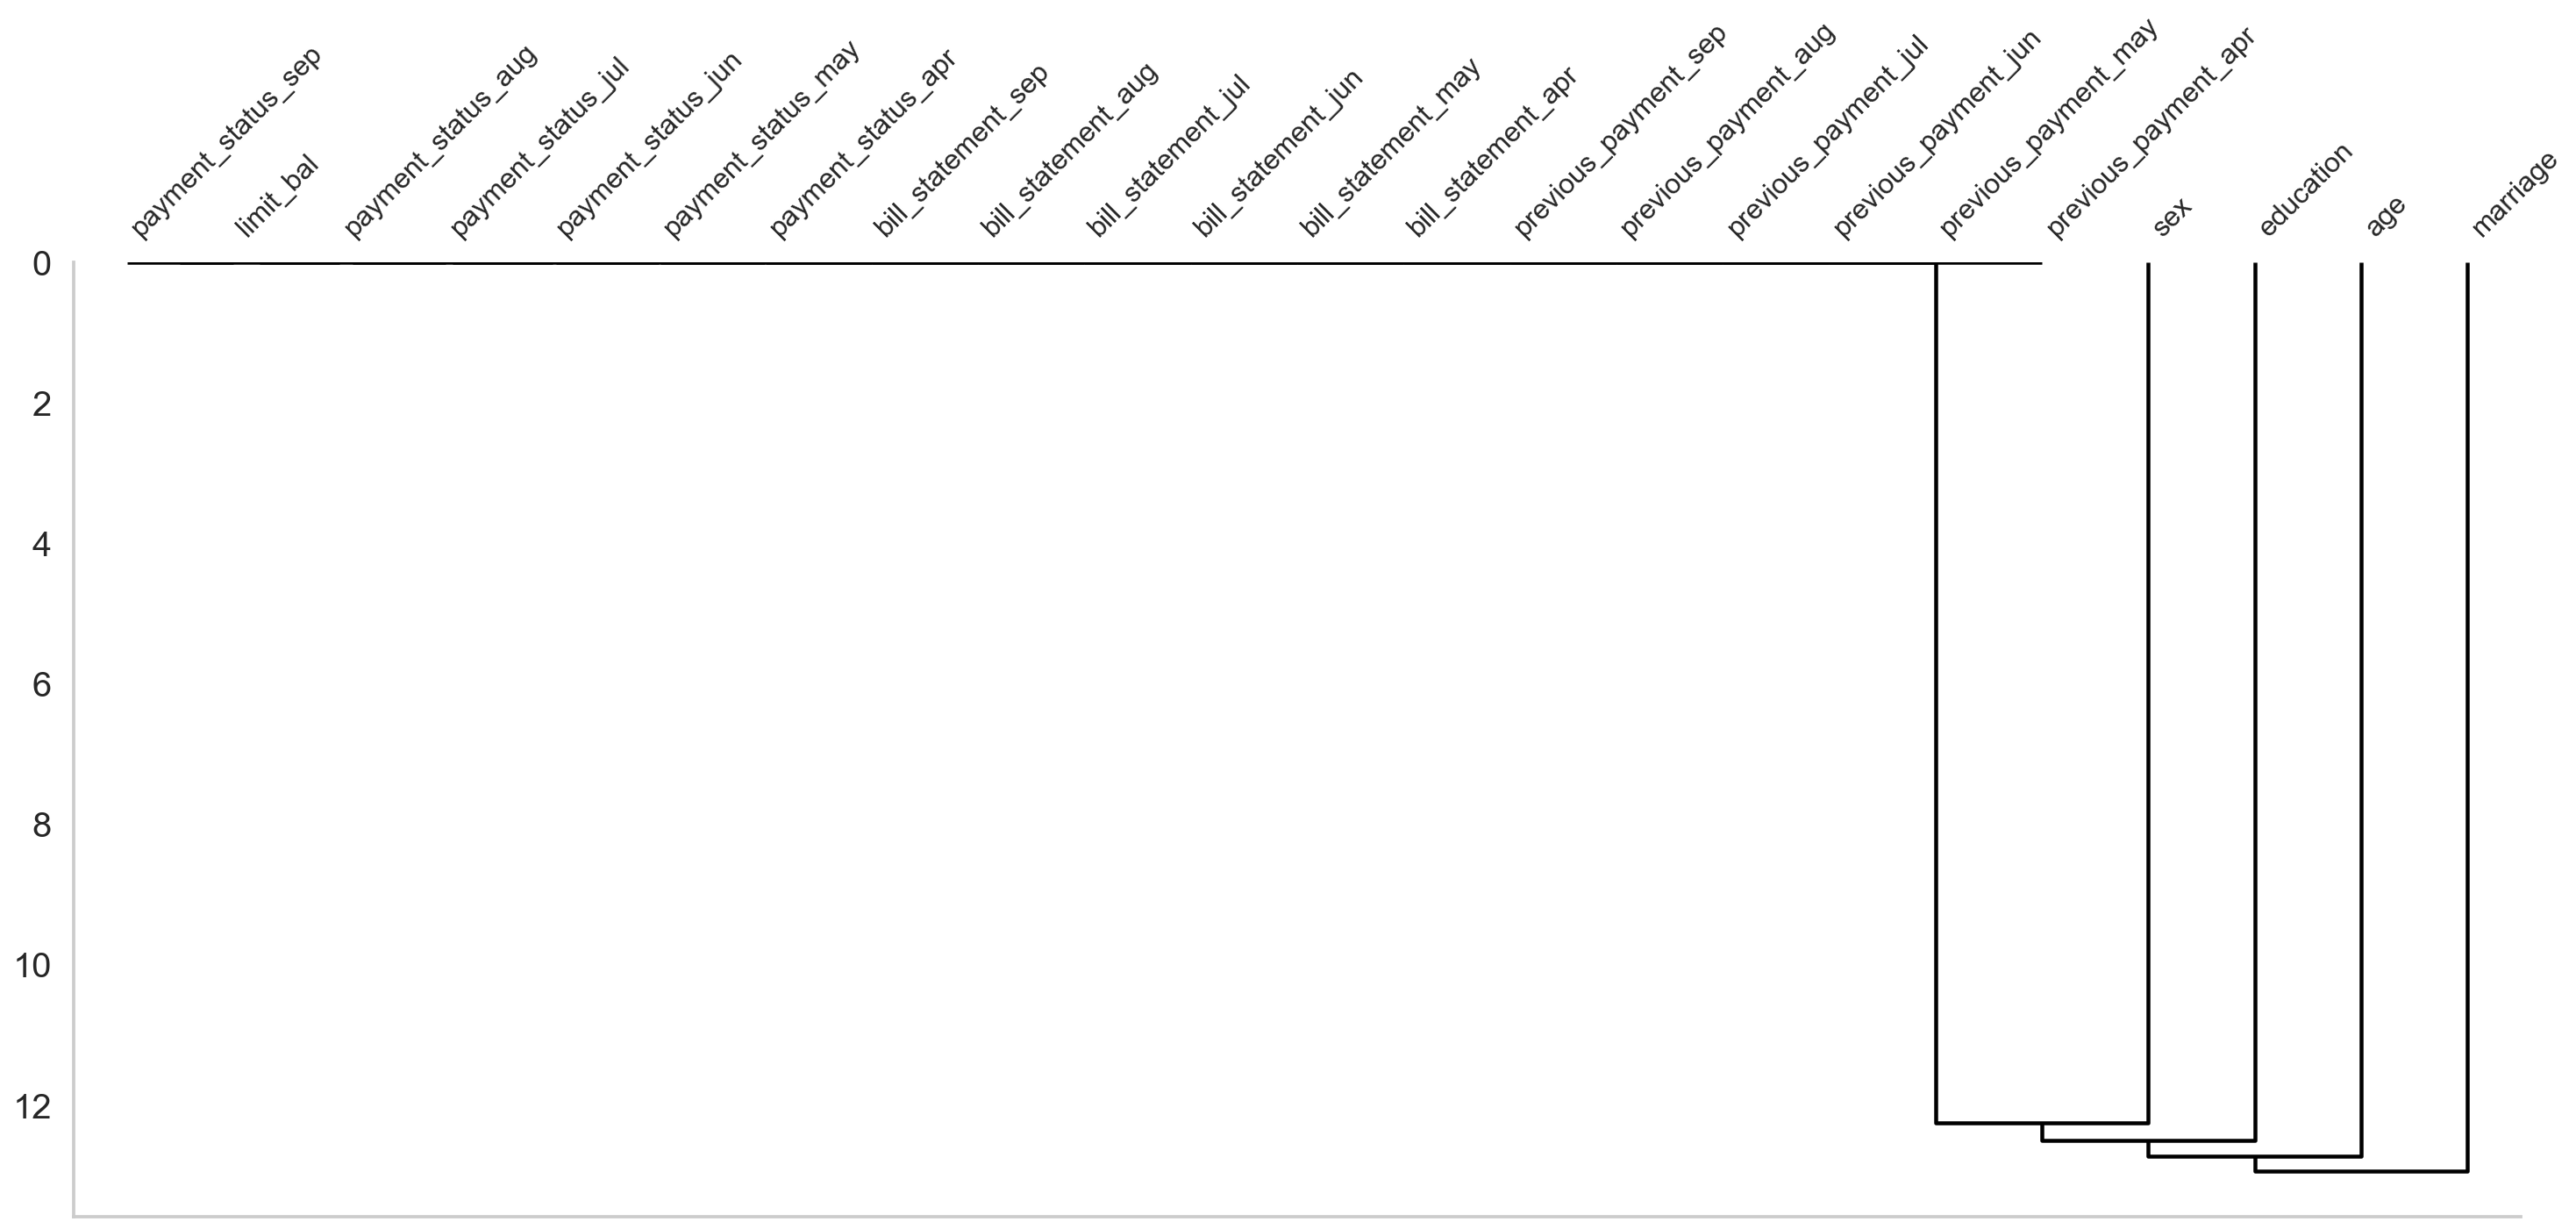

In [20]:
msno.dendrogram(X)

sns.despine()
# plt.savefig("images/figure_13_13", dpi=200)

## 13.5 Encoding categorical variables

### How to do it...

1. Import the libraries:

In [21]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

2. Use Label Encoder to encode a selected column:

In [22]:
COL = "education"

X_train_copy = X_train.copy()
X_test_copy = X_test.copy()

label_enc = LabelEncoder()
label_enc.fit(X_train_copy[COL])
X_train_copy.loc[:, COL] = label_enc.transform(X_train_copy[COL])
X_test_copy.loc[:, COL] = label_enc.transform(X_test_copy[COL])

X_test_copy[COL].head()

6907     3
24575    0
26766    3
2156     0
3179     3
Name: education, dtype: int64

In [23]:
label_enc.classes_

array(['Graduate school', 'High school', 'Others', 'University'],
      dtype=object)

3. Select categorical features for one-hot encoding:

In [24]:
cat_features = X_train.select_dtypes(include="object") \
                      .columns \
                      .to_list()

cat_features

['sex',
 'education',
 'marriage',
 'payment_status_sep',
 'payment_status_aug',
 'payment_status_jul',
 'payment_status_jun',
 'payment_status_may',
 'payment_status_apr']

4. Instantiate the `OneHotEncoder` object: 

In [25]:
one_hot_encoder = OneHotEncoder(sparse=False, 
                                handle_unknown="error", 
                                drop="first")

5. Create the column transformer using the one-hot encoder: 

In [26]:
one_hot_transformer = ColumnTransformer(
    [("one_hot", one_hot_encoder, cat_features)],
    remainder="passthrough",
    verbose_feature_names_out=False
)

6. Fit the transformer:

In [27]:
one_hot_transformer.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('one_hot',
                                 OneHotEncoder(drop='first', sparse=False),
                                 ['sex', 'education', 'marriage',
                                  'payment_status_sep', 'payment_status_aug',
                                  'payment_status_jul', 'payment_status_jun',
                                  'payment_status_may',
                                  'payment_status_apr'])],
                  verbose_feature_names_out=False)

7. Apply the transformations to both training and test sets:

In [ ]:
col_names = one_hot_transformer.get_feature_names_out()

X_train_ohe = pd.DataFrame(one_hot_transformer.transform(X_train), 
                           columns=col_names, 
                           index=X_train.index)

X_test_ohe = pd.DataFrame(one_hot_transformer.transform(X_test), 
                          columns=col_names, 
                          index=X_test.index)

Below we can see how one-hot encoding increased the shape of our DataFrame:

In [ ]:
X_train.shape

In [ ]:
X_train_ohe.shape

In [ ]:
X_train_ohe.to_csv("X_train_ohe.csv", index=True)
X_test_ohe.to_csv("X_test_ohe.csv", index=True)
y_train.to_csv("y_train.csv", index=True)
y_test.to_csv("y_test.csv", index=True)

### There's more

#### Using `pandas` for one-hot encoding

In [ ]:
pd.get_dummies(X_train, prefix_sep="_", drop_first=True)

#### Specifying possible categories for OneHotEncoder

In [ ]:
one_hot_encoder = OneHotEncoder(
    categories=[["Male", "Female", "Unknown"]], 
    sparse=False, 
    handle_unknown="error", 
    drop="first"
)

one_hot_transformer = ColumnTransformer(
    [("one_hot", one_hot_encoder, ["sex"])]
)

one_hot_transformer.fit(X_train)
one_hot_transformer.get_feature_names_out()

#### Category Encoders library

In [ ]:
import category_encoders as ce

In [ ]:
one_hot_encoder_ce = ce.OneHotEncoder(use_cat_names=True)

In [ ]:
one_hot_encoder_ce.fit(X_train)
X_train_ce = one_hot_encoder_ce.transform(X_train)
X_train_ce.head()

#### Accessing the `category` encoding

In [ ]:
column_dtypes = {
    "education": "category", 
    "marriage": "category", 
    "sex": "category"
}
df_cat = pd.read_csv("../Datasets/credit_card_default.csv", 
                     na_values="", dtype=column_dtypes)

In [ ]:
df_cat["education"].cat.codes

In [ ]:
dict(zip(df_cat["education"].cat.codes, df_cat["education"]))

## 13.6 Fitting a decision tree classifier

### Getting ready

In [3]:
import pandas as pd
X_train_ohe = pd.read_csv("X_train_ohe.csv", index_col=0)
X_test_ohe = pd.read_csv("X_test_ohe.csv", index_col=0)
y_train = pd.read_csv("y_train.csv", index_col=0)["default_payment_next_month"]
y_test = pd.read_csv("y_test.csv", index_col=0)["default_payment_next_month"]

### How to do it...

1. Import the libraries:

In [4]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import metrics

from chapter_13_utils import performance_evaluation_report

2. Create the instance of the model, fit it to the training data and create prediction:

In [5]:
tree_classifier = DecisionTreeClassifier(random_state=42)
tree_classifier.fit(X_train_ohe, y_train)
y_pred = tree_classifier.predict(X_test_ohe)

3. Evaluate the results:

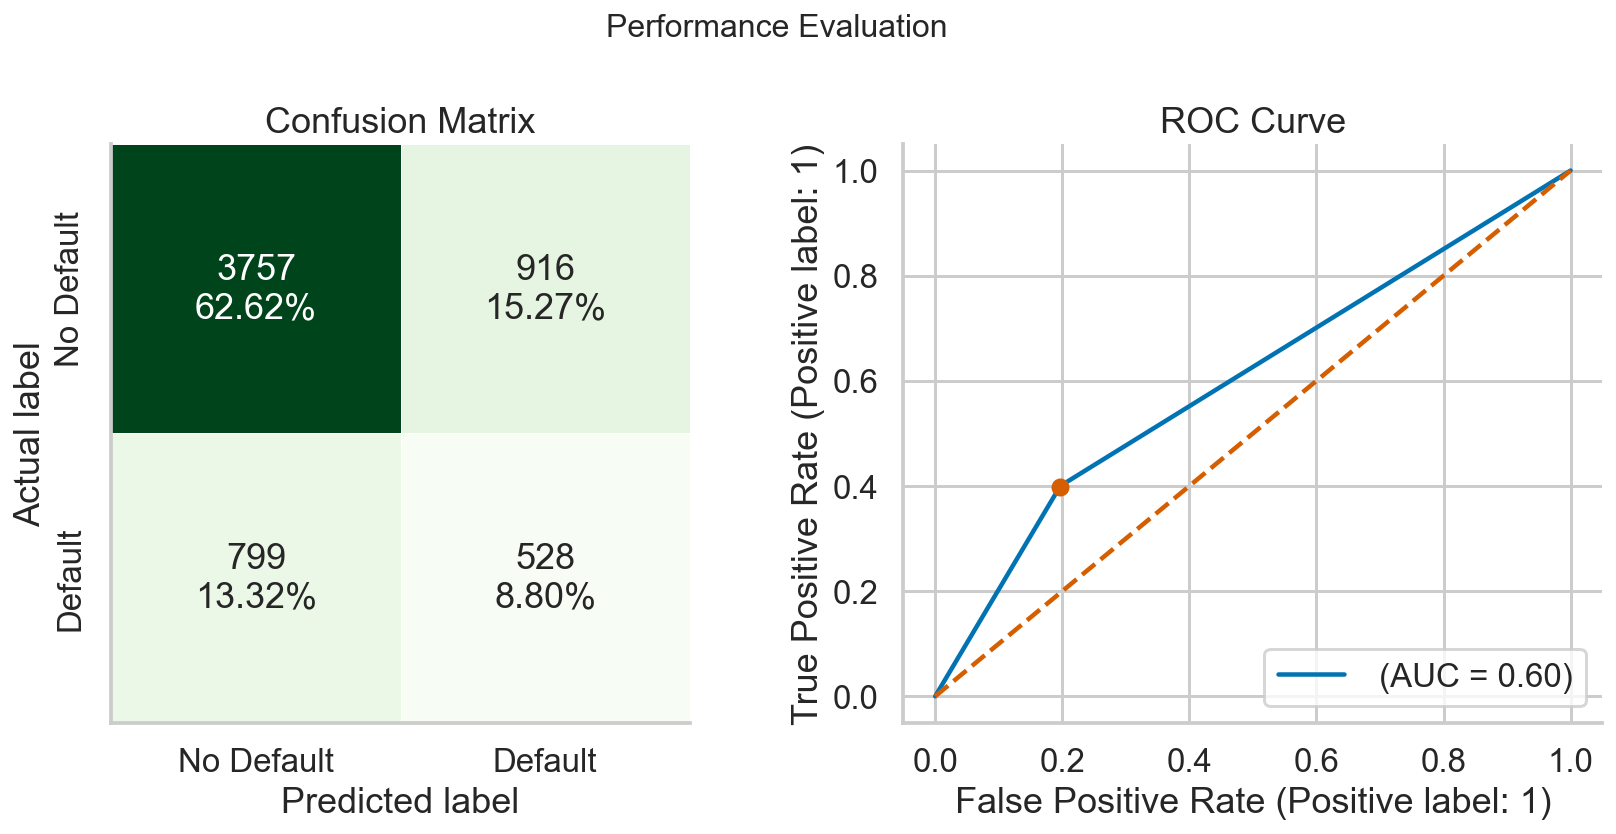

In [8]:
LABELS = ["No Default", "Default"]
tree_perf = performance_evaluation_report(tree_classifier, 
                                          X_test_ohe, 
                                          y_test, labels=LABELS, 
                                          show_plot=True)

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_13_15", dpi=200)

In [9]:
tree_perf

{'accuracy': 0.7141666666666666,
 'precision': 0.3656509695290859,
 'recall': 0.39788997739261495,
 'specificity': 0.8039803124331265,
 'f1_score': 0.3810898592565861,
 'cohens_kappa': 0.1956931046277427,
 'matthews_corr_coeff': 0.1959883714391891,
 'roc_auc': 0.601583581287813,
 'pr_auc': 0.44877724015824927,
 'average_precision': 0.2789754297204212}

4. Plot the first few levels of the fitted decision tree:

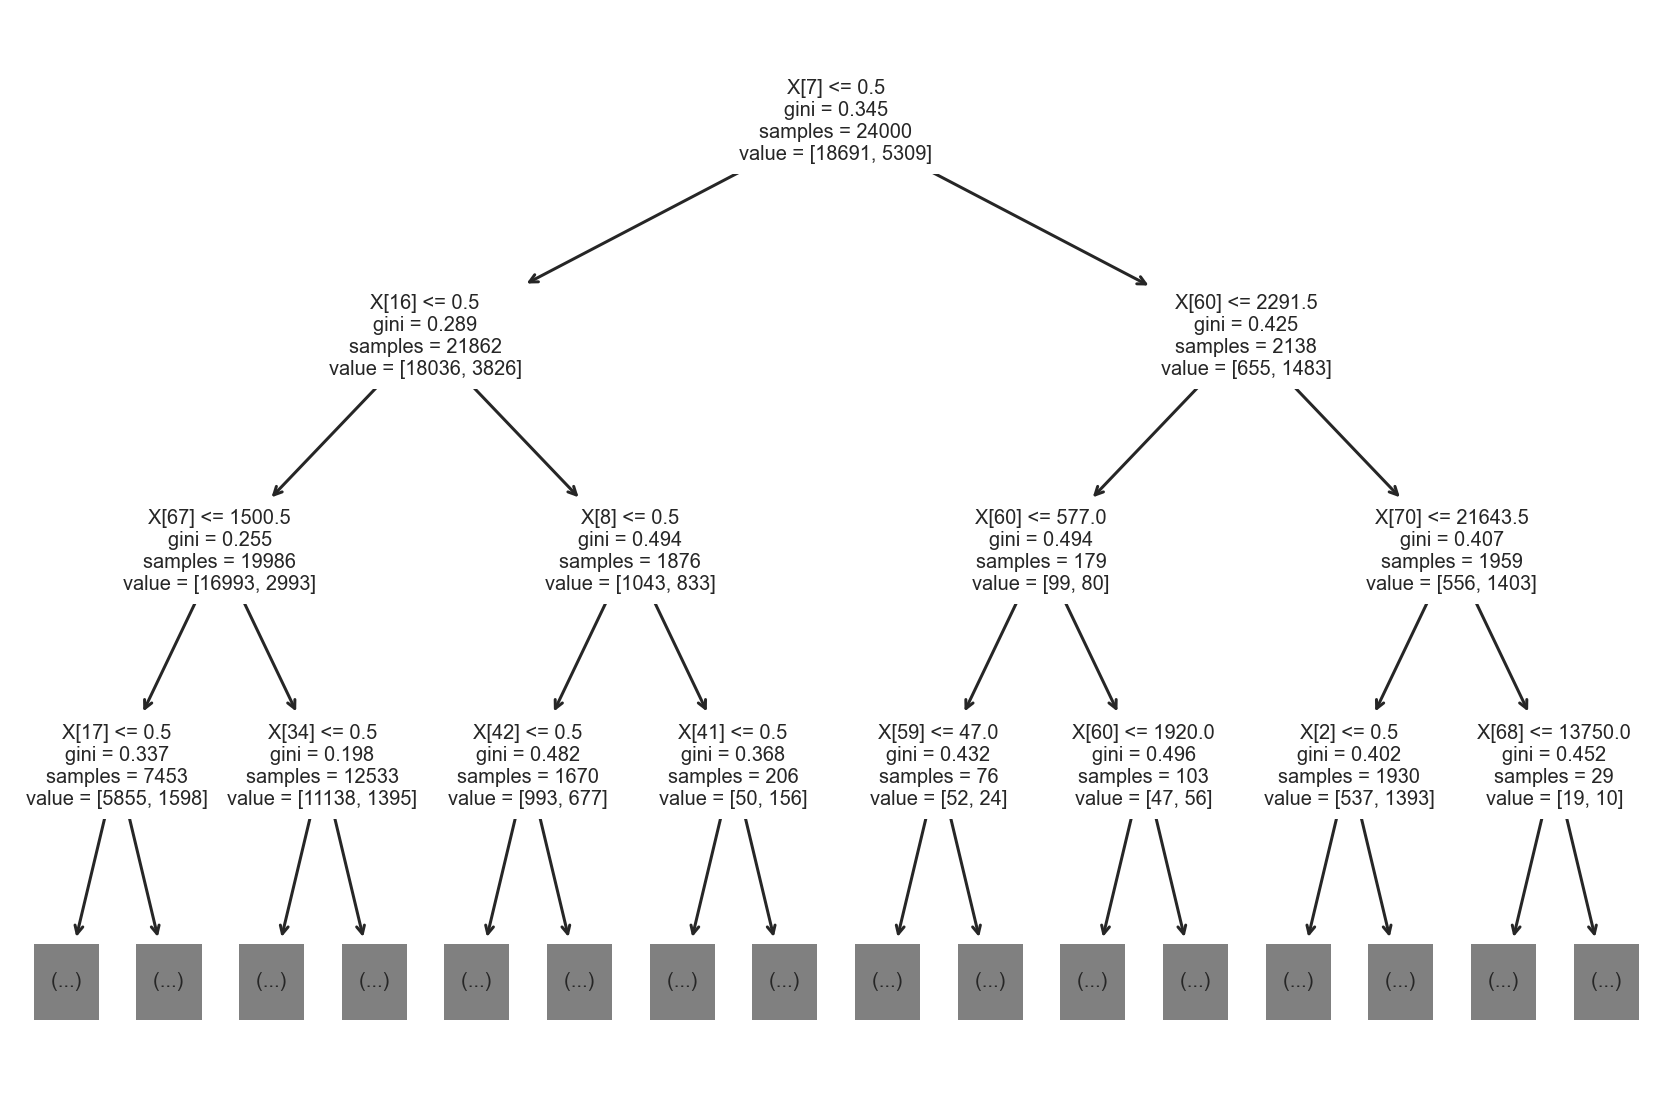

In [11]:
plot_tree(tree_classifier, max_depth=3, fontsize=10)

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_13_16", dpi=200)

In [9]:
tree_classifier.get_depth()

44

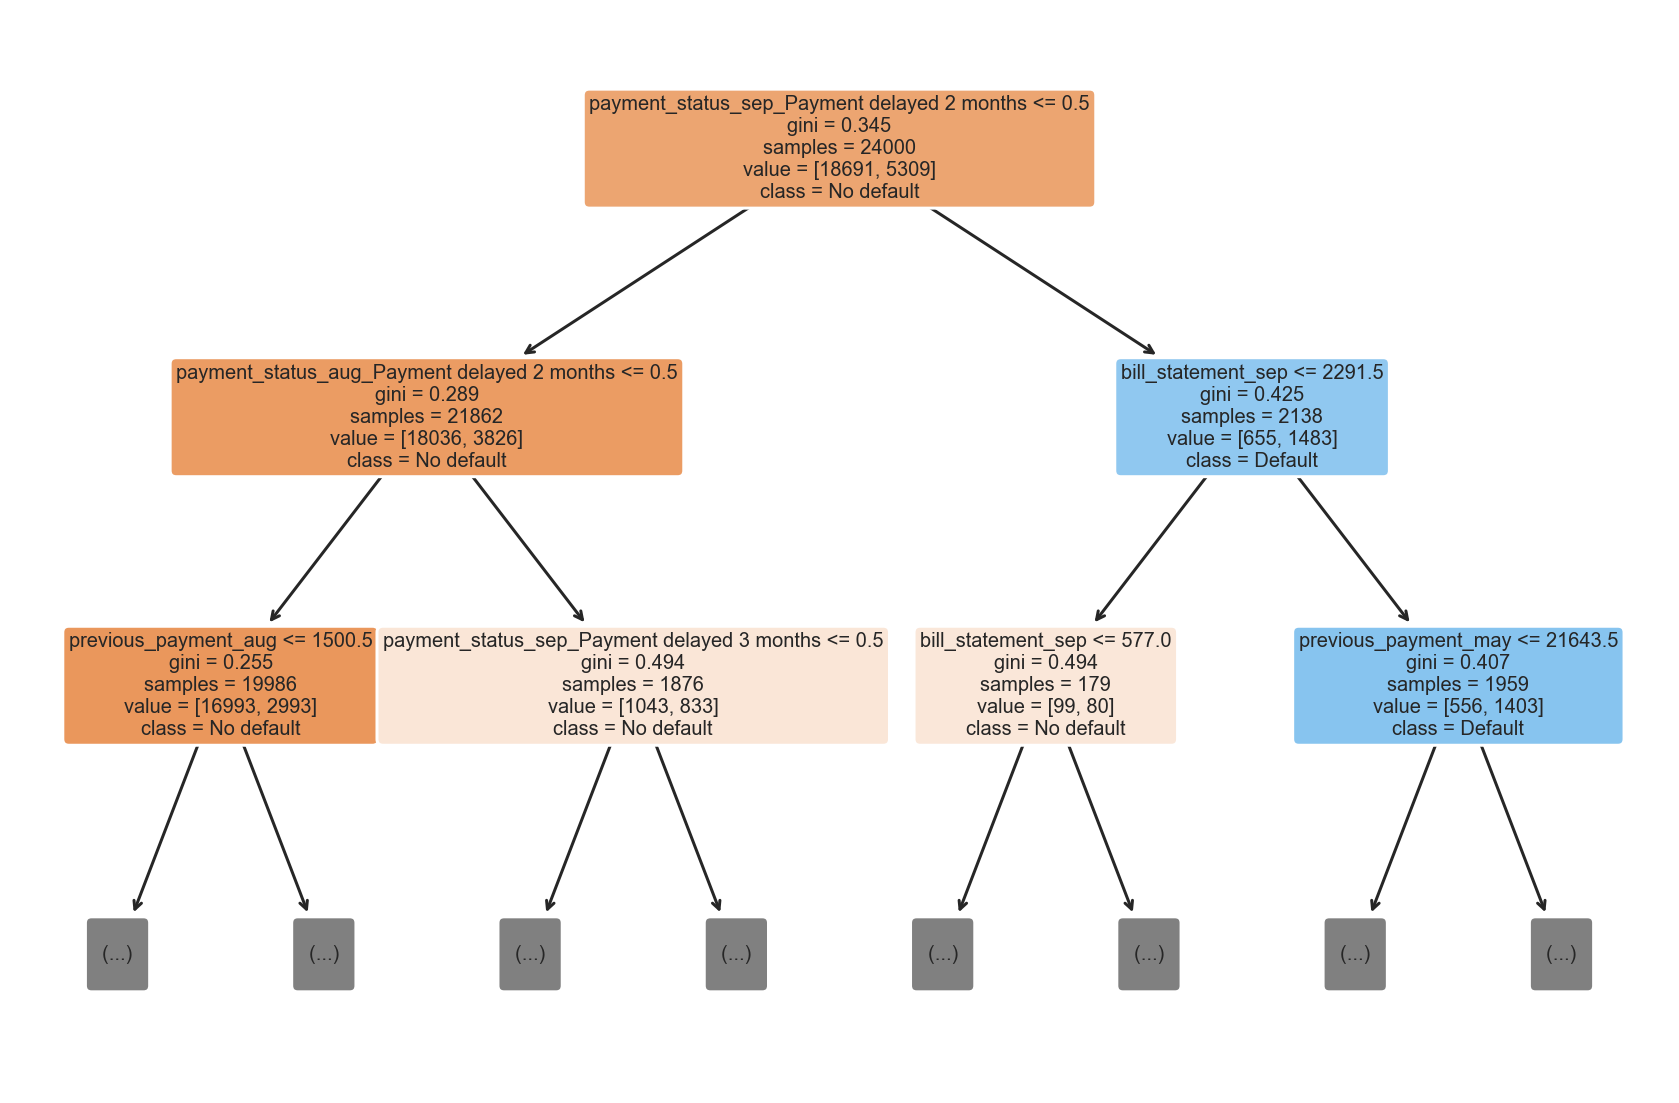

In [12]:
plot_tree(
    tree_classifier, 
    max_depth=2,
    feature_names = X_train_ohe.columns, 
    class_names=["No default", "Default"],
    rounded=True, 
    filled = True, 
    fontsize=10
)

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_13_17", dpi=200)

### There's more

**Precision-recall curve**

In [13]:
y_pred_prob = tree_classifier.predict_proba(X_test_ohe)[:, 1]

precision, recall, _ = metrics.precision_recall_curve(y_test, 
                                                      y_pred_prob)

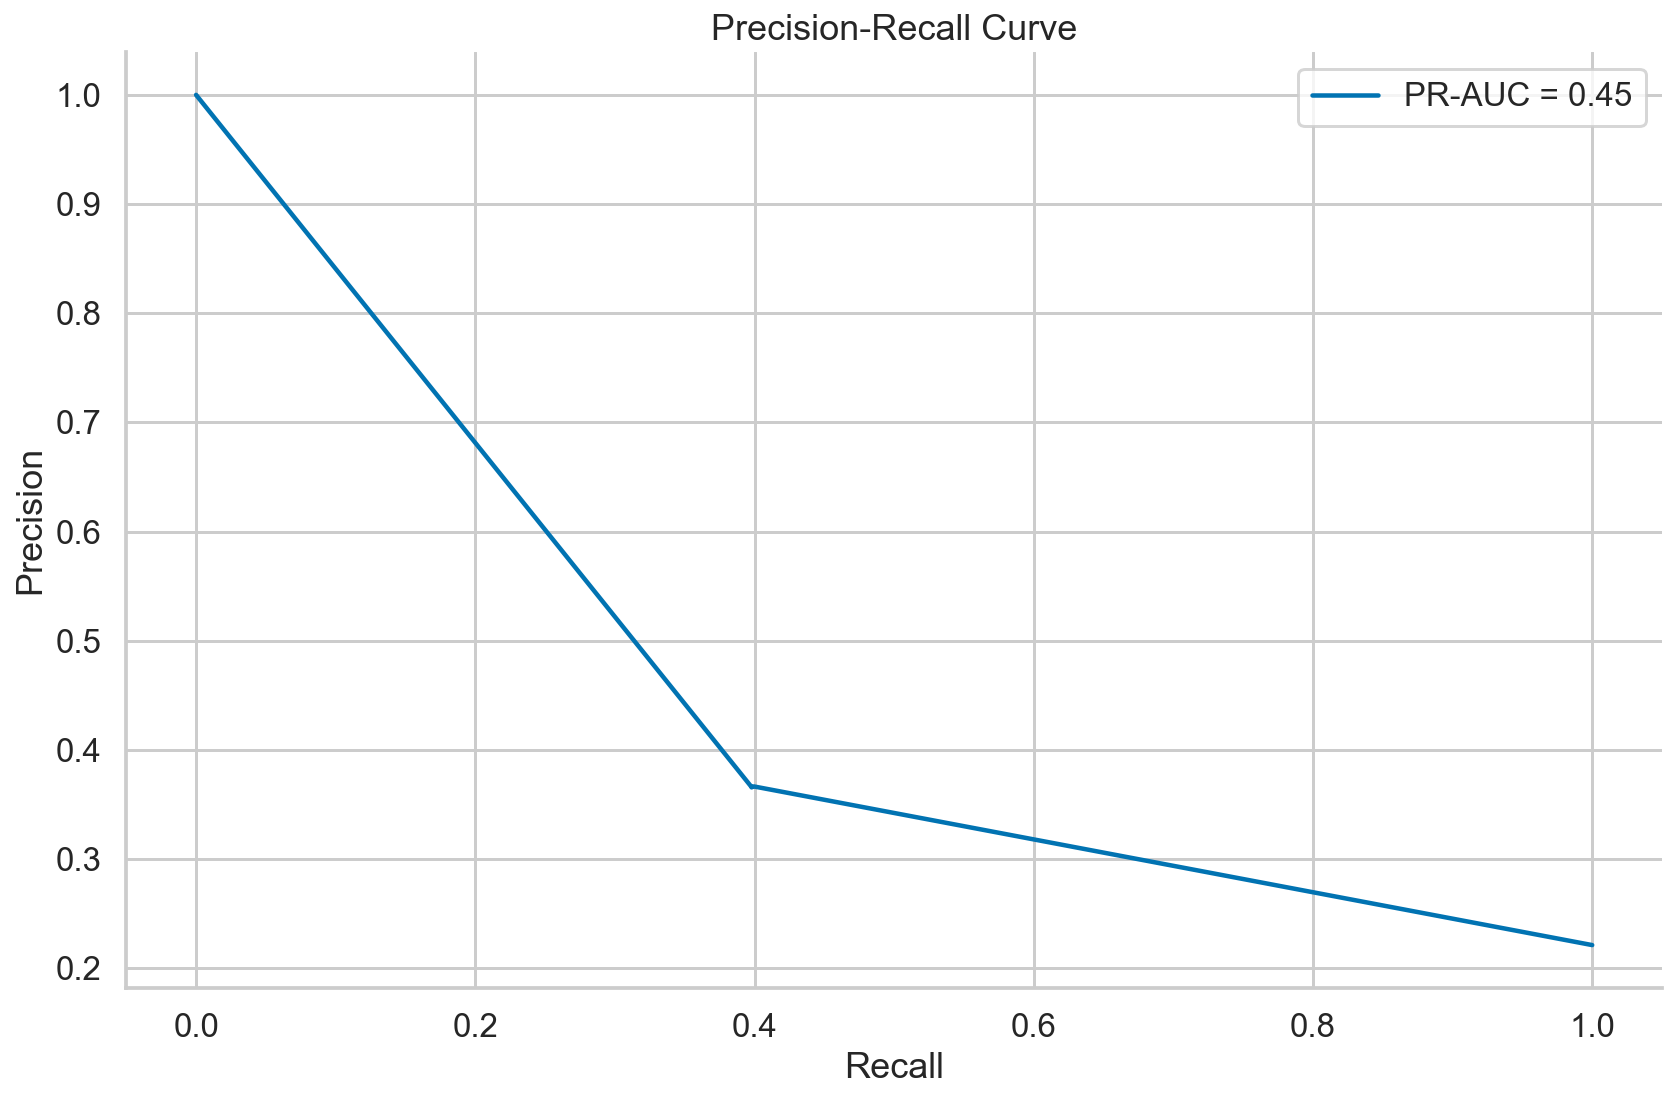

In [14]:
ax = plt.subplot()
ax.plot(recall, precision, 
        label=f"PR-AUC = {metrics.auc(recall, precision):.2f}")
ax.set(title="Precision-Recall Curve", 
       xlabel="Recall", 
       ylabel="Precision")
ax.legend()

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_13_19", dpi=200)

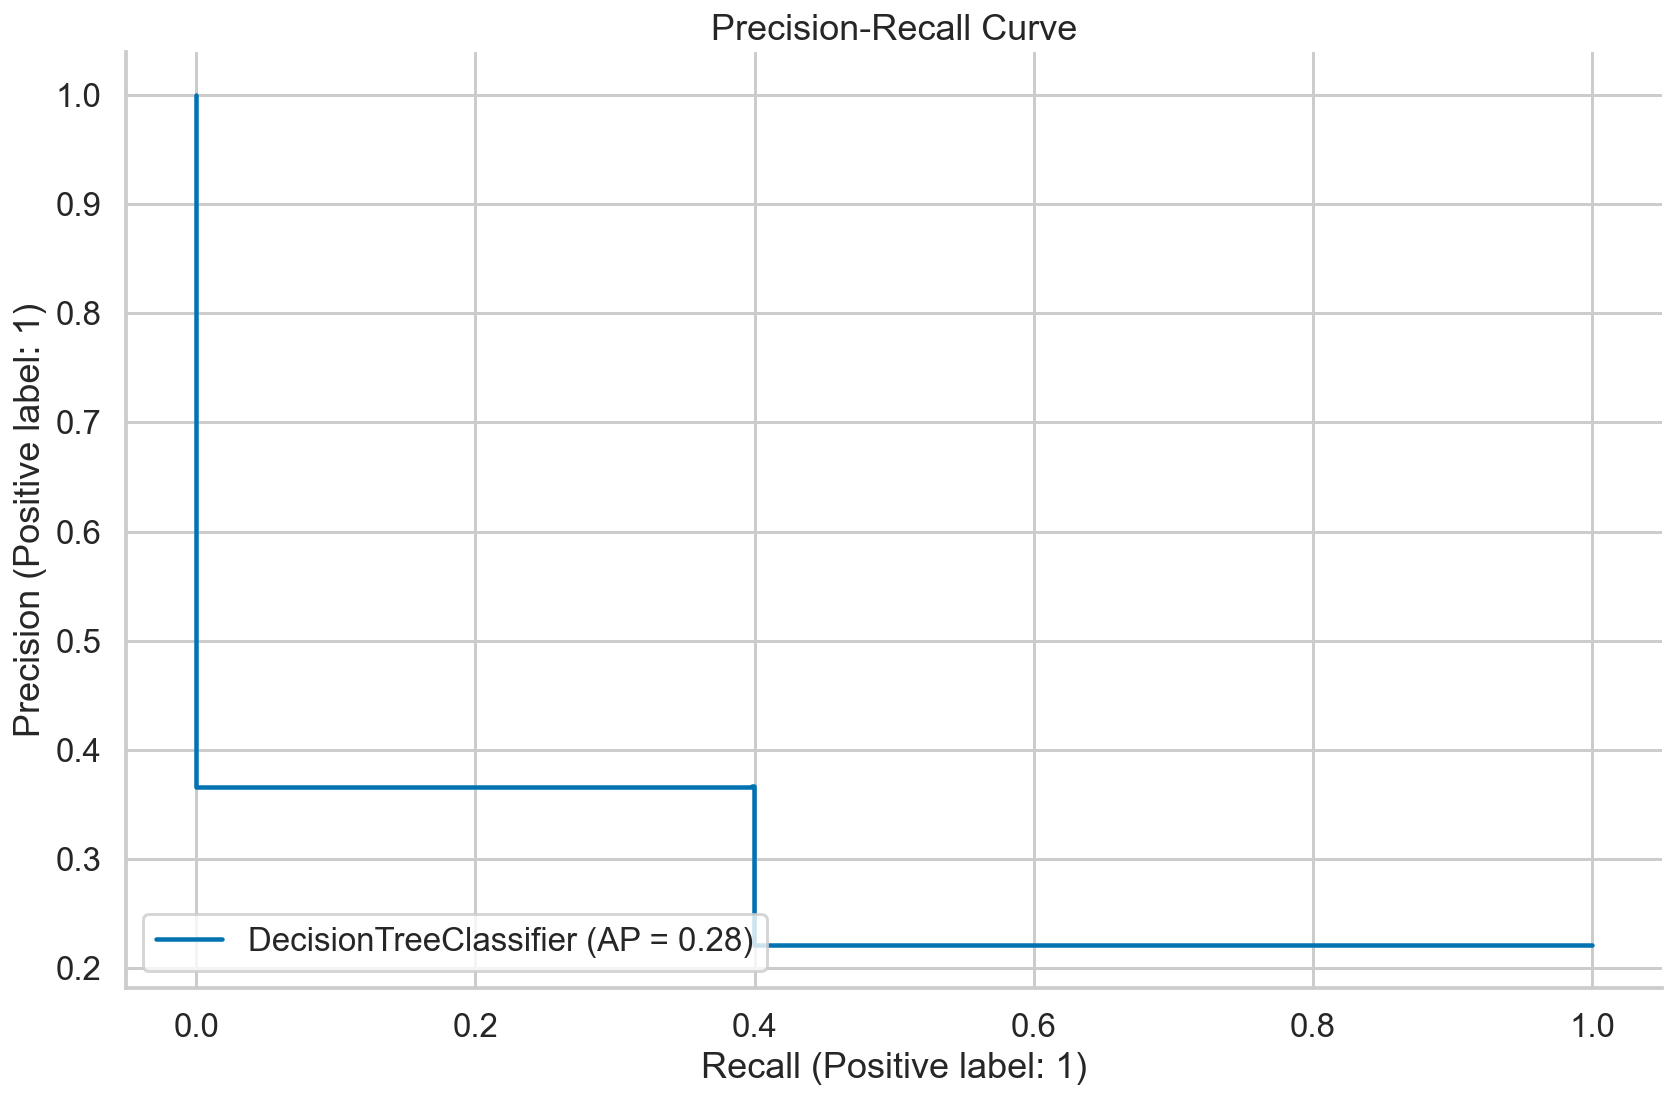

In [15]:
ax = metrics.PrecisionRecallDisplay.from_estimator(
    tree_classifier, X_test_ohe, y_test
)
ax.ax_.set_title("Precision-Recall Curve")

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_13_20", dpi=200)

**Visualizing decision trees using `dtreeviz`**

1. Import the libraries:

In [16]:
from dtreeviz.trees import *

2. Fit a small decision tree with max depth of 3:

In [17]:
small_tree = DecisionTreeClassifier(max_depth=3, 
                                    random_state=42)
small_tree.fit(X_train_ohe, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

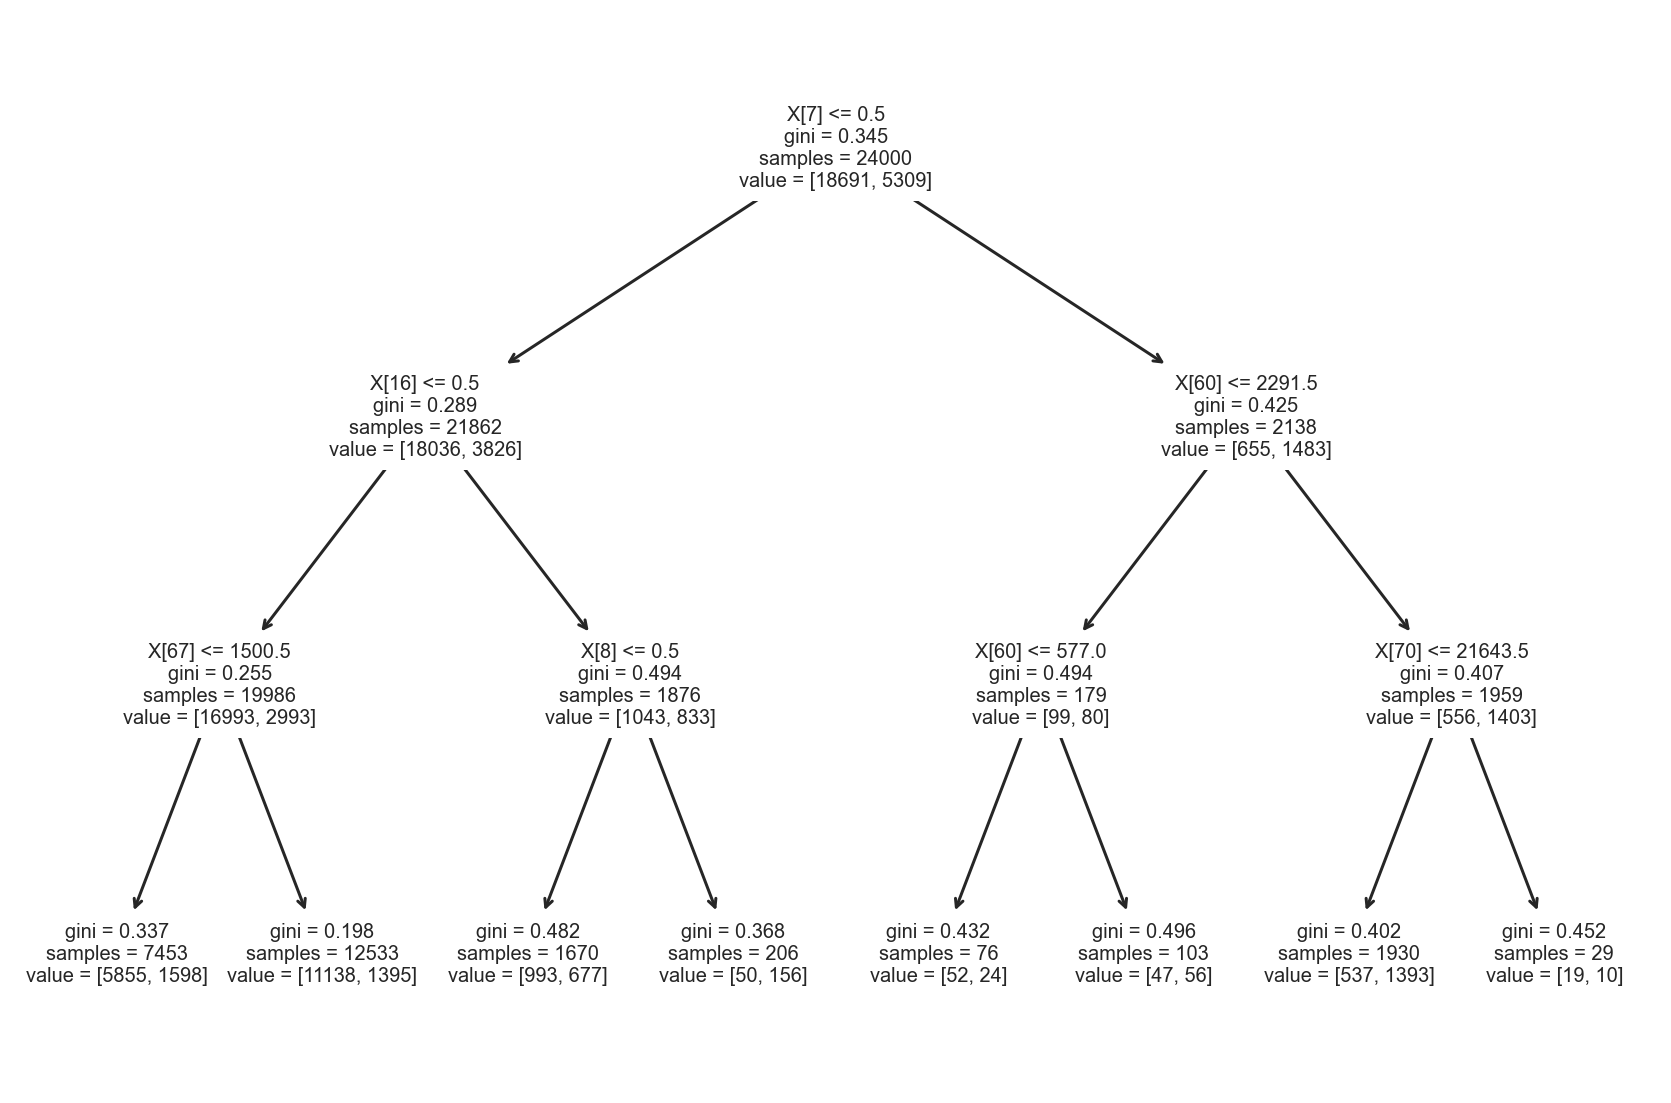

In [19]:
plot_tree(small_tree, max_depth=3, fontsize=10)

sns.despine()
plt.tight_layout()

3. Plot the decision tree using `dtreeviz`:

/opt/homebrew/Caskroom/miniforge/base/envs/pff2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


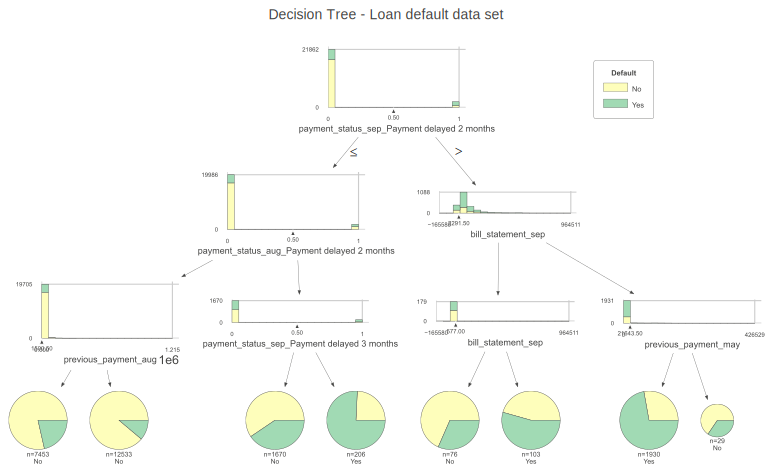

In [20]:
viz = dtreeviz(small_tree, 
               x_data=X_train_ohe,
               y_data=y_train,
               feature_names=X_train_ohe.columns, 
               target_name="Default",
               class_names=["No", "Yes"], 
               title="Decision Tree - Loan default data set")
viz

4. Plot the simplified tree representation:

In [ ]:
viz = dtreeviz(small_tree, 
               x_data=X_train_ohe,
               y_data=y_train,
               feature_names=X_train_ohe.columns, 
               target_name="Default",
               class_names=["No", "Yes"], 
               title="Decision Tree - Loan default data set",
               fancy=False)
viz

5. Plot the simplified tree representation and the decision path of the first observation from the test set:

In [ ]:
viz = dtreeviz(small_tree, 
               x_data=X_train_ohe,
               y_data=y_train,
               feature_names=X_train_ohe.columns, 
               target_name="Default",
               class_names=["No", "Yes"], 
               title="Decision Tree - Loan default data set",
               fancy=False,
               X=X_test_ohe.iloc[0])
viz

7. Print the prediction path using words:

In [ ]:
print(explain_prediction_path(small_tree, X_test_ohe.iloc[0], 
                              feature_names=X_test_ohe.columns, 
                              explanation_type="plain_english"))

## 13.7 Organizing the project with pipelines

### How to do it...

1. Import the libraries:

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from chapter_13_utils import performance_evaluation_report

2. Load the data, separate the target and create the stratified train-test split:

In [11]:
df = pd.read_csv("../Datasets/credit_card_default.csv", na_values="")

X = df.copy()
y = X.pop("default_payment_next_month")

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    stratify=y, 
                                                    random_state=42)

3. Prepare lists of numerical/categorical features:

In [12]:
num_features = X_train.select_dtypes(include="number") \
                      .columns \
                      .to_list()
cat_features = X_train.select_dtypes(include="object") \
                      .columns \
                      .to_list()

In [13]:
# sanity check that all columns are included in the lists
len(X_train.columns) == (len(num_features) + len(cat_features))

True

4. Define the numerical pipeline:

In [14]:
num_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

5. Define the categorical pipeline:

In [15]:
cat_list = [
    list(X_train[col].dropna().unique()) for col in cat_features
]

cat_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(categories=cat_list, 
                             sparse=False, 
                             handle_unknown="error", 
                             drop="first"))
])

6. Define the `ColumnTransformer` object: 

In [9]:
preprocessor = ColumnTransformer(
    transformers=[
        ("numerical", num_pipeline, num_features),
        ("categorical", cat_pipeline, cat_features)
    ], 
    remainder="drop"
)

7. Define the full pipeline including the decision tree model: 

In [10]:
dec_tree = DecisionTreeClassifier(random_state=42)

tree_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", dec_tree)
])

8. Fit the pipeline to the data:

In [11]:
tree_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['limit_bal', 'age',
                                                   'bill_statement_sep',
                                                   'bill_statement_aug',
                                                   'bill_statement_jul',
                                                   'bill_statement_jun',
                                                   'bill_statement_may',
                                                   'bill_statement_apr',
                                                   'previous_payment_sep',
                                                   'previous_payment_aug',
                                                   'previous_payment_j...
                                                                                              '3 '
                                                                                              'months',
                                                                                              'Payment '
                                                                                              'delayed '
                                                                                              '7 '
                                                                                              'months',
                                                                                              'Payment '
                                                                                              'delayed '
                                                                                              '5 '
                                                                                              'months',
                                                                                              'Payment '
                                                                                              'delayed '
                                                                                              '8 '
                                                                                              'months']],
                                                                                 drop='first',
                                                                                 sparse=False))]),
                                                  ['sex', 'education',
                                                   'marriage',
                                                   'payment_status_sep',
                                                   'payment_status_aug',
                                                   'payment_status_jul',
                                                   'payment_status_jun',
                                                   'payment_status_may',
                                                   'payment_status_apr'])])),
                ('classifier', DecisionTreeClassifier(random_state=42))])

9. Evaluate the performance of the entire pipeline:

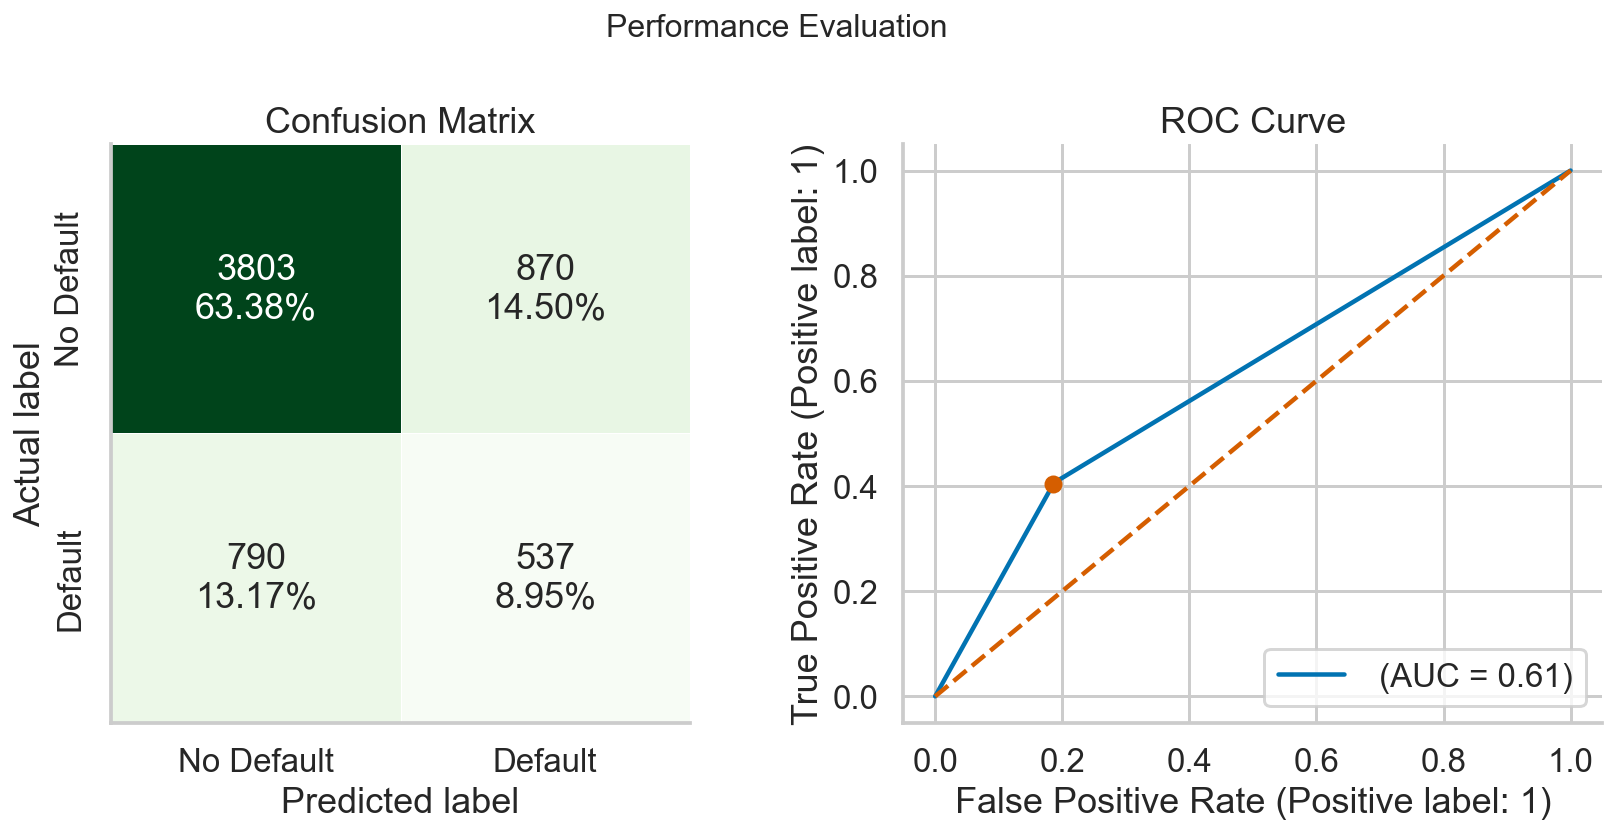

In [12]:
LABELS = ["No Default", "Default"]
tree_perf = performance_evaluation_report(tree_pipeline, X_test, 
                                          y_test, labels=LABELS, 
                                          show_plot=True)

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_13_23", dpi=200)

In [13]:
tree_perf

{'accuracy': 0.7233333333333334,
 'precision': 0.3816631130063966,
 'recall': 0.4046721929163527,
 'specificity': 0.8138240958698909,
 'f1_score': 0.3928310168251646,
 'cohens_kappa': 0.21388003714653614,
 'matthews_corr_coeff': 0.2140336931441623,
 'roc_auc': 0.6095279347712678,
 'pr_auc': 0.4589251149708047,
 'average_precision': 0.28616835280766334}

### There's more

#### Adding custom transformers to a pipeline

1. Import the base estimator and transformer classes from `sklearn`: 

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

2. Define the `OutlierRemover` class:

In [15]:
class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, n_std=3):
        self.n_std = n_std
    
    def fit(self, X, y = None):
        if np.isnan(X).any(axis=None):
            raise ValueError("""There are missing values in the array! 
                                Please remove them.""")

        mean_vec = np.mean(X, axis=0)
        std_vec = np.std(X, axis=0)
        
        self.upper_band_ = pd.Series(mean_vec + self.n_std * std_vec)
        self.upper_band_ = self.upper_band_.to_frame().transpose()
        self.lower_band_ = pd.Series(mean_vec - self.n_std * std_vec)
        self.lower_band_ = self.lower_band_.to_frame().transpose()
        self.n_features_ = len(self.upper_band_.columns)
        
        return self 
    
    def transform(self, X, y = None):
        X_copy = pd.DataFrame(X.copy())
        
        upper_band = pd.concat(
            [self.upper_band_] * len(X_copy), 
            ignore_index=True
        )
        lower_band = pd.concat(
            [self.lower_band_] * len(X_copy), 
            ignore_index=True
        )
        
        X_copy[X_copy >= upper_band] = upper_band
        X_copy[X_copy <= lower_band] = lower_band
        
        return X_copy.values

3. Add the `OutlierRemover` to the numerical pipeline:

In [16]:
num_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("outliers", OutlierRemover())
])

4. Execute the rest of the pipeline to compare the results: 

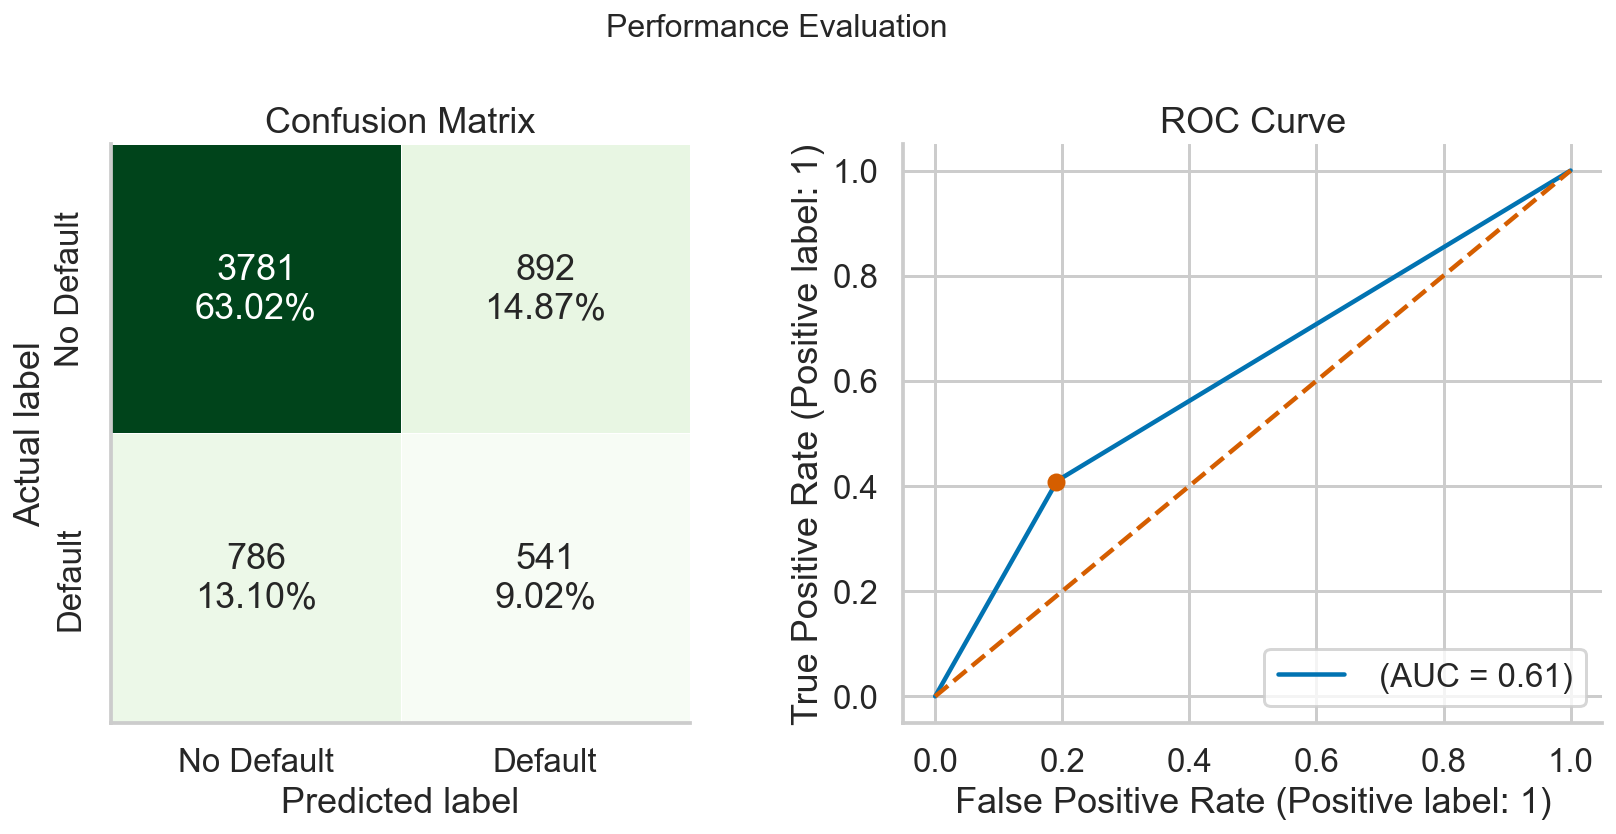

In [17]:
preprocessor = ColumnTransformer(transformers=[
    ("numerical", num_pipeline, num_features),
    ("categorical", cat_pipeline, cat_features)],
    remainder="drop")

dec_tree = DecisionTreeClassifier(random_state=42)

tree_pipeline = Pipeline(steps=[("preprocessor", preprocessor),
                                ("classifier", dec_tree)])

tree_pipeline.fit(X_train, y_train)

tree_perf = performance_evaluation_report(tree_pipeline, X_test, 
                                          y_test, labels=LABELS, 
                                          show_plot=True)

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_13_24", dpi=200)

In [18]:
tree_perf

{'accuracy': 0.7203333333333334,
 'precision': 0.377529658060014,
 'recall': 0.4076865109269028,
 'specificity': 0.8091161994436122,
 'f1_score': 0.39202898550724635,
 'cohens_kappa': 0.21077497538963086,
 'matthews_corr_coeff': 0.2110374148258694,
 'roc_auc': 0.608982787005664,
 'pr_auc': 0.4582134167657523,
 'average_precision': 0.2850810668089482}

#### Accessing the elements of the pipeline

1. Display the structure of the pipeline:

In [19]:
tree_pipeline.named_steps

{'preprocessor': ColumnTransformer(transformers=[('numerical',
                                  Pipeline(steps=[('imputer',
                                                   SimpleImputer(strategy='median')),
                                                  ('outliers',
                                                   OutlierRemover())]),
                                  ['limit_bal', 'age', 'bill_statement_sep',
                                   'bill_statement_aug', 'bill_statement_jul',
                                   'bill_statement_jun', 'bill_statement_may',
                                   'bill_statement_apr', 'previous_payment_sep',
                                   'previous_payment_aug',
                                   'previous_payment_jul...
                                                                              'months',
                                                                              'Payment '
                                          

2. Access the estimator at the end of the pipeline:

In [20]:
tree_pipeline.named_steps["classifier"]

DecisionTreeClassifier(random_state=42)

3. Access the upper thresholds of the fitted `OutlierRemover` transformer:

In [21]:
(
    tree_pipeline
    .named_steps["preprocessor"]
    .named_transformers_["numerical"]["outliers"]
    .upper_band_
)

0          1              2              3              4   \
0  555890.511578  62.945993  271626.004006  261528.147261  252069.405868   

             5             6              7             8             9   \
0  235292.85113  222044.17518  216598.486524  54067.496948  66637.658658   

           10            11            12            13  
0  57755.3464  49971.471286  49914.412427  58779.830767

In [22]:
( 
    tree_pipeline
    .named_steps["preprocessor"]
    .transformers_[0][1]["outliers"]
    .upper_band_
)

0          1              2              3              4   \
0  555890.511578  62.945993  271626.004006  261528.147261  252069.405868   

             5             6              7             8             9   \
0  235292.85113  222044.17518  216598.486524  54067.496948  66637.658658   

           10            11            12            13  
0  57755.3464  49971.471286  49914.412427  58779.830767

## 13.8 Tuning hyperparameters using grid search and cross-validation

### Getting ready

Please execute the code from the previous recipe before running this one!

### How to do it...

1. Import the libraries:

In [29]:
from sklearn.model_selection import (
    GridSearchCV, cross_val_score, 
    RandomizedSearchCV, cross_validate, 
    StratifiedKFold
)
from sklearn import metrics

2. Define the cross-validation scheme:

In [30]:
k_fold = StratifiedKFold(5, shuffle=True, random_state=42)

3. Evaluate the pipeline using cross-validation:

In [31]:
cross_val_score(tree_pipeline, X_train, y_train, cv=k_fold)

array([0.72333333, 0.72958333, 0.71375   , 0.723125  , 0.72      ])

4. Add extra metrics to cross-validation:

In [32]:
cv_scores = cross_validate(tree_pipeline, X_train, y_train, cv=k_fold, 
                           scoring=["accuracy", "precision", "recall", 
                                    "roc_auc"])
pd.DataFrame(cv_scores)

fit_time  score_time  test_accuracy  test_precision  test_recall  \
0  0.772163    0.227986       0.723333        0.385604     0.424128   
1  0.784956    0.224507       0.729583        0.395575     0.420904   
2  0.764176    0.223117       0.713750        0.369783     0.417137   
3  0.758147    0.226915       0.723125        0.386383     0.427495   
4  0.756567    0.223108       0.720000        0.376748     0.405838   

   test_roc_auc  
0      0.616333  
1      0.618938  
2      0.607940  
3      0.618066  
4      0.607129

5. Define the parameter grid:

In [33]:
param_grid = {
    "classifier__criterion": ["entropy", "gini"],
    "classifier__max_depth": range(3, 11),
    "classifier__min_samples_leaf": range(2, 11), 
    "preprocessor__numerical__outliers__n_std": [3, 4]
}

6. Run the exhaustive grid search: 

In [34]:
classifier_gs = GridSearchCV(tree_pipeline, param_grid, 
                             scoring="recall", cv=k_fold, 
                             n_jobs=-1, verbose=1)

classifier_gs.fit(X_train, y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('outliers',
                                                                                          OutlierRemover())]),
                                                                         ['limit_bal',
                                                                          'age',
                                                                          'bill_statement_sep',
                                                                          'bill_statement_aug',
                                                                          'bill_statement_jul',
                                                                          'bill_statement...
                                                                          'payment_status_jul',
                                                                          'payment_status_jun',
                                                                          'payment_status_may',
                                                                          'payment_status_apr'])])),
                                       ('classifier',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__criterion': ['entropy', 'gini'],
                         'classifier__max_depth': range(3, 11),
                         'classifier__min_samples_leaf': range(2, 11),
                         'preprocessor__numerical__outliers__n_std': [3, 4]},
             scoring='recall', verbose=1)

In [35]:
print(f"Best parameters: {classifier_gs.best_params_}") 
print(f"Recall (Training set): {classifier_gs.best_score_:.4f}") 
print(f"Recall (Test set): {metrics.recall_score(y_test, classifier_gs.predict(X_test)):.4f}")

Best parameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 7, 'preprocessor__numerical__outliers__n_std': 4}
Recall (Training set): 0.3858
Recall (Test set): 0.3775


7. Evaluate the performance of the tuned pipeline:

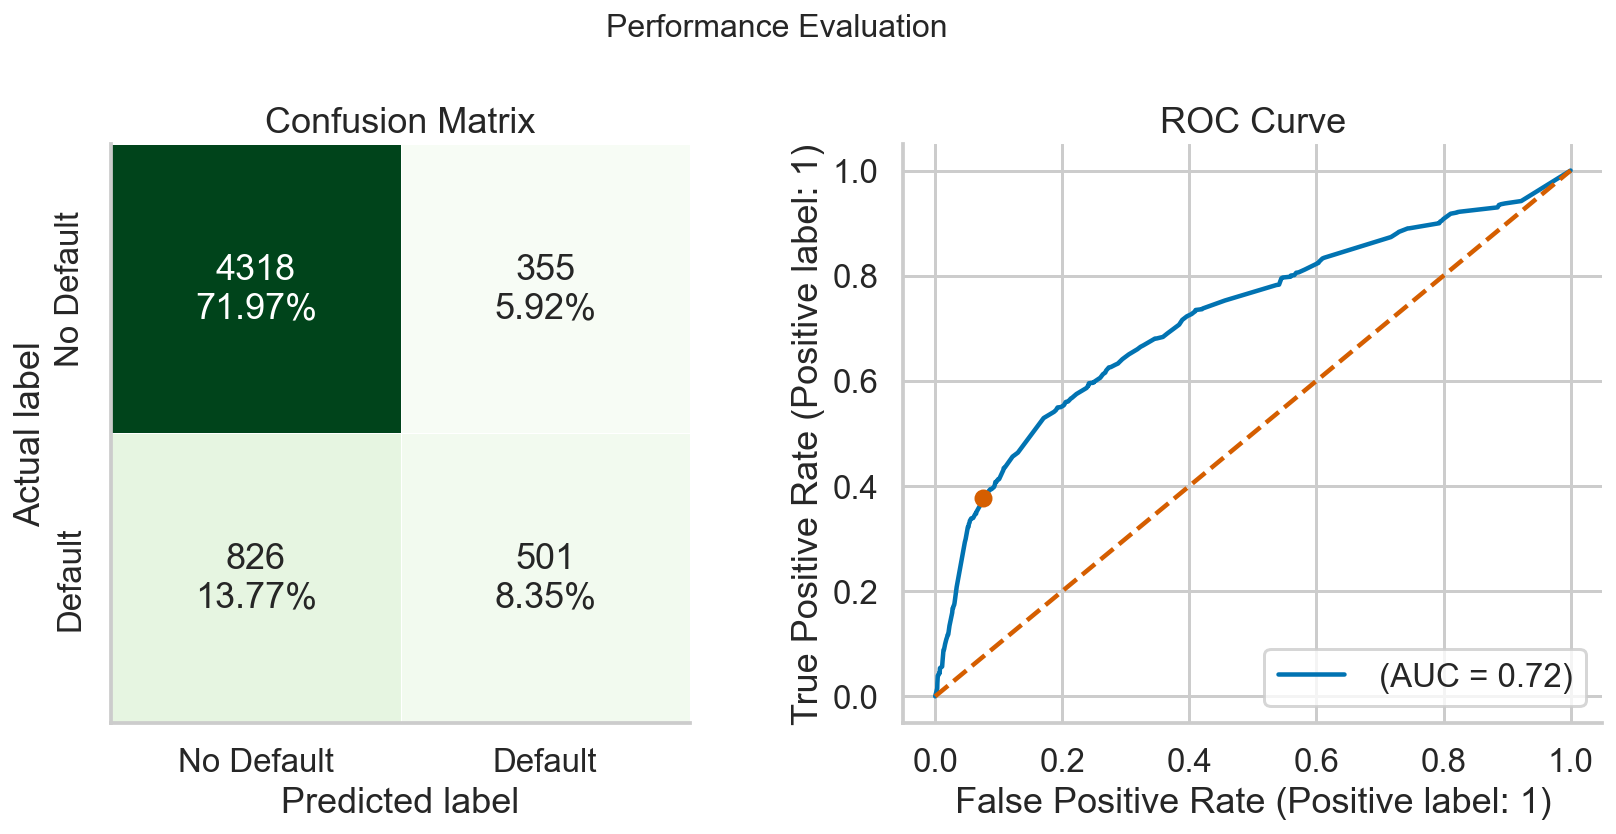

In [36]:
LABELS = ["No Default", "Default"]
tree_gs_perf = performance_evaluation_report(classifier_gs, X_test, 
                                             y_test, labels=LABELS, 
                                             show_plot=True)

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_13_26", dpi=200)

In [40]:
tree_gs_perf

{'accuracy': 0.8031666666666667,
 'precision': 0.5852803738317757,
 'recall': 0.3775433308214017,
 'specificity': 0.9240316713032314,
 'f1_score': 0.45900137425561155,
 'cohens_kappa': 0.34547526291831954,
 'matthews_corr_coeff': 0.35788321424347136,
 'roc_auc': 0.7205480311384921,
 'pr_auc': 0.4698784893189859,
 'average_precision': 0.4652985864969478}

8. Run the randomized grid search: 

In [38]:
classifier_rs = RandomizedSearchCV(tree_pipeline, param_grid, 
                                   scoring="recall", cv=k_fold, 
                                   n_jobs=-1, verbose=1, 
                                   n_iter=100, random_state=42)
classifier_rs.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('numerical',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('outliers',
                                                                                                OutlierRemover())]),
                                                                               ['limit_bal',
                                                                                'age',
                                                                                'bill_statement_sep',
                                                                                'bill_statement_aug',
                                                                                'bill_statement_jul',
                                                                                'bill_sta...
                                                                                'payment_status_may',
                                                                                'payment_status_apr'])])),
                                             ('classifier',
                                              DecisionTreeClassifier(random_state=42))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'classifier__criterion': ['entropy',
                                                                  'gini'],
                                        'classifier__max_depth': range(3, 11),
                                        'classifier__min_samples_leaf': range(2, 11),
                                        'preprocessor__numerical__outliers__n_std': [3,
                                                                                     4]},
                   random_state=42, scoring='recall', verbose=1)

In [39]:
print(f"Best parameters: {classifier_rs.best_params_}") 
print(f"Recall (Training set): {classifier_rs.best_score_:.4f}") 
print(f"Recall (Test set): {metrics.recall_score(y_test, classifier_rs.predict(X_test)):.4f}")

Best parameters: {'preprocessor__numerical__outliers__n_std': 3, 'classifier__min_samples_leaf': 7, 'classifier__max_depth': 10, 'classifier__criterion': 'gini'}
Recall (Training set): 0.3854
Recall (Test set): 0.3760


9. Evaluate the performance of the Randomized Grid Search:

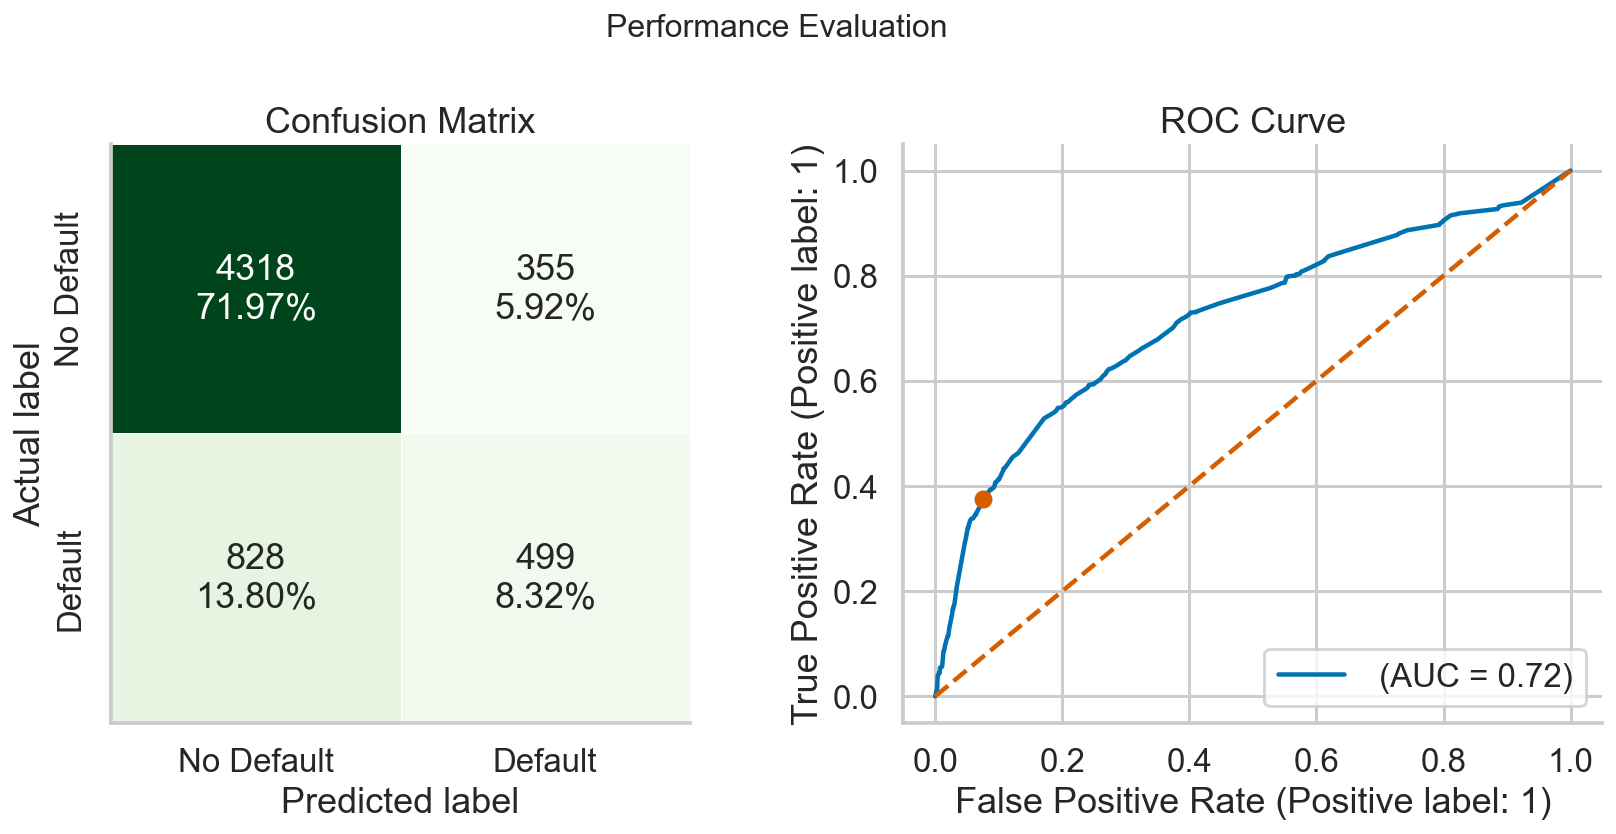

In [34]:
tree_rs_perf = performance_evaluation_report(classifier_rs, X_test, 
                                             y_test, labels=LABELS, 
                                             show_plot=True)

sns.despine()
plt.tight_layout()

In [35]:
tree_rs_perf

{'accuracy': 0.8028333333333333,
 'precision': 0.5843091334894613,
 'recall': 0.3760361718161266,
 'specificity': 0.9240316713032314,
 'f1_score': 0.45758826226501603,
 'cohens_kappa': 0.3439613201516819,
 'matthews_corr_coeff': 0.3564420906256157,
 'roc_auc': 0.7188330048148133,
 'pr_auc': 0.4686663337519278,
 'average_precision': 0.46397440653315936}

### There's more

#### Faster search with successive halving

In [36]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

# using the default values for min_resources and factor
classifier_sh = HalvingGridSearchCV(tree_pipeline, param_grid, 
                                    scoring="recall", cv=k_fold, 
                                    n_jobs=-1, verbose=1, 
                                    min_resources="exhaust", factor=3)

classifier_sh.fit(X_train, y_train)


n_iterations: 6
n_required_iterations: 6
n_possible_iterations: 6
min_resources_: 98
max_resources_: 24000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 288
n_resources: 98
Fitting 5 folds for each of 288 candidates, totalling 1440 fits
----------
iter: 1
n_candidates: 96
n_resources: 294
Fitting 5 folds for each of 96 candidates, totalling 480 fits
----------
iter: 2
n_candidates: 32
n_resources: 882
Fitting 5 folds for each of 32 candidates, totalling 160 fits
----------
iter: 3
n_candidates: 11
n_resources: 2646
Fitting 5 folds for each of 11 candidates, totalling 55 fits
----------
iter: 4
n_candidates: 4
n_resources: 7938
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 5
n_candidates: 2
n_resources: 23814
Fitting 5 folds for each of 2 candidates, totalling 10 fits


HalvingGridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                    estimator=Pipeline(steps=[('preprocessor',
                                               ColumnTransformer(transformers=[('numerical',
                                                                                Pipeline(steps=[('imputer',
                                                                                                 SimpleImputer(strategy='median')),
                                                                                                ('outliers',
                                                                                                 OutlierRemover())]),
                                                                                ['limit_bal',
                                                                                 'age',
                                                                                 'bill_statement_sep',
                                                                                 'bill_statement_aug',
                                                                                 'bill_statement_jul',
                                                                                 'bill_st...
                                                                                 'payment_status_jul',
                                                                                 'payment_status_jun',
                                                                                 'payment_status_may',
                                                                                 'payment_status_apr'])])),
                                              ('classifier',
                                               DecisionTreeClassifier(random_state=42))]),
                    n_jobs=-1,
                    param_grid={'classifier__criterion': ['entropy', 'gini'],
                                'classifier__max_depth': range(3, 11),
                                'classifier__min_samples_leaf': range(2, 11),
                                'preprocessor__numerical__outliers__n_std': [3,
                                                                             4]},
                    scoring='recall', verbose=1)

In [37]:
print(f"Best parameters: {classifier_sh.best_params_}") 
print(f"Recall (Training set): {classifier_sh.best_score_:.4f}") 
print(f"Recall (Test set): {metrics.recall_score(y_test, classifier_sh.predict(X_test)):.4f}")

Best parameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 6, 'preprocessor__numerical__outliers__n_std': 4}
Recall (Training set): 0.3782
Recall (Test set): 0.3760


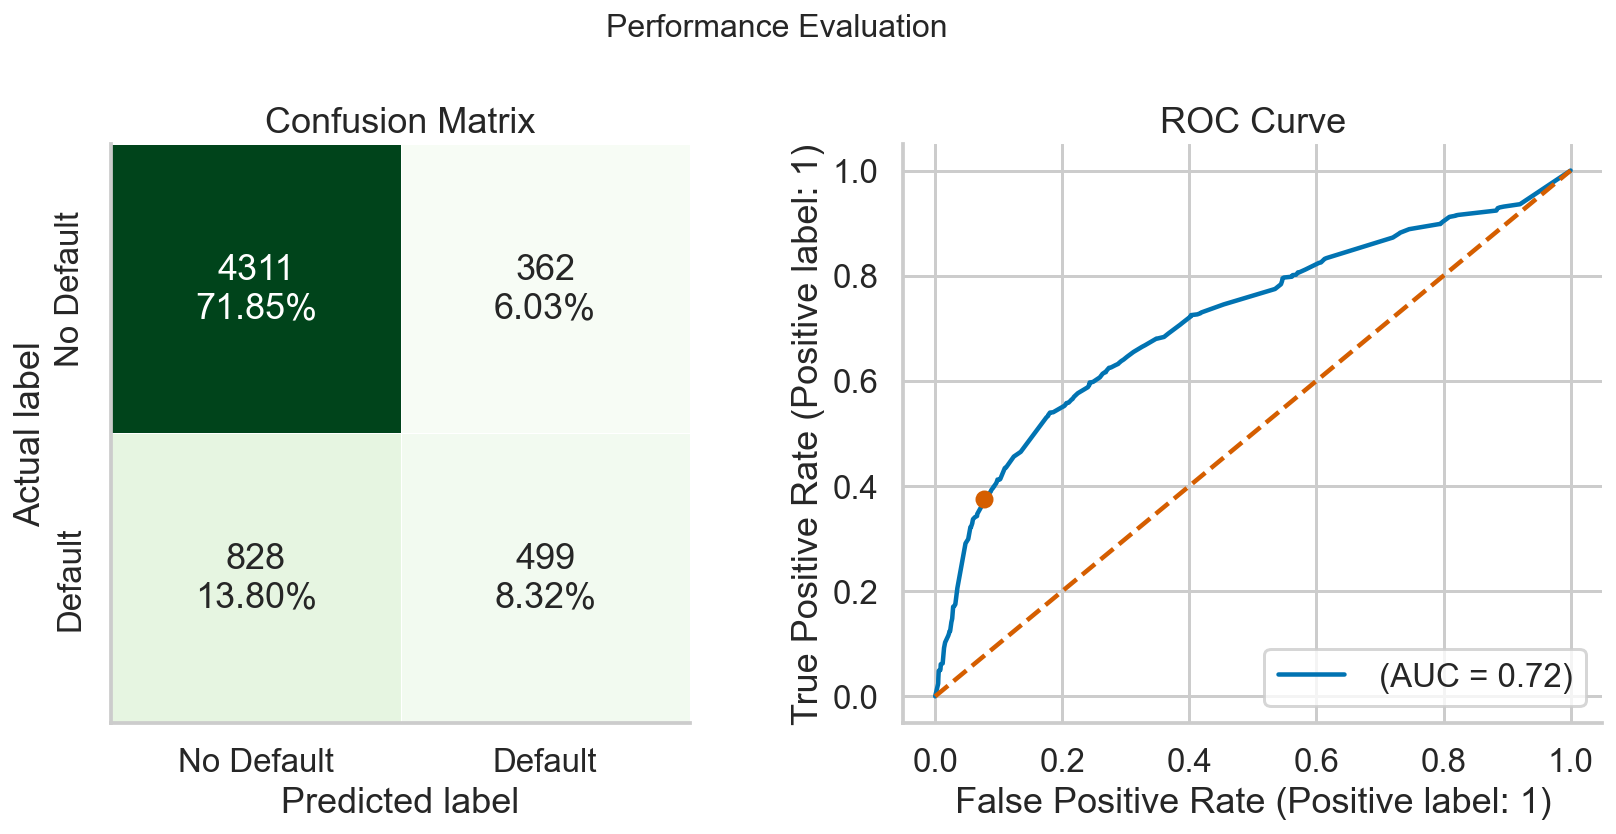

In [38]:
tree_sh_perf = performance_evaluation_report(classifier_sh, X_test, 
                                             y_test, labels=LABELS, 
                                             show_plot=True)

sns.despine()
plt.tight_layout()

In [44]:
pd.DataFrame(
    data = [
        classifier_gs.best_params_, 
        classifier_rs.best_params_, 
        classifier_sh.best_params_
    ],
    index = ["grid_search", "randomized_search", "halving_search"]
)

classifier__criterion  classifier__max_depth  \
grid_search                        gini                     10   
randomized_search                  gini                     10   
halving_search                     gini                     10   

                   classifier__min_samples_leaf  \
grid_search                                   7   
randomized_search                             7   
halving_search                                6   

                   preprocessor__numerical__outliers__n_std  
grid_search                                               4  
randomized_search                                         3  
halving_search                                            4

In [45]:
pd.DataFrame(
    data = [tree_gs_perf, tree_rs_perf, tree_sh_perf],
    index = ["grid_search", "randomized_search", "halving_search"]
).round(3)

accuracy  precision  recall  specificity  f1_score  \
grid_search           0.803      0.585   0.378        0.924     0.459   
randomized_search     0.803      0.584   0.376        0.924     0.458   
halving_search        0.802      0.580   0.376        0.923     0.456   

                   cohens_kappa  matthews_corr_coeff  roc_auc  pr_auc  \
grid_search               0.345                0.358    0.721   0.470   
randomized_search         0.344                0.356    0.719   0.469   
halving_search            0.342                0.353    0.717   0.466   

                   average_precision  
grid_search                    0.465  
randomized_search              0.464  
halving_search                 0.460

#### Grid search with multiple classifiers

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
param_grid = [
    {"classifier": [RandomForestClassifier(random_state=42)],
     "classifier__n_estimators": np.linspace(100, 500, 10, dtype=int),
     "classifier__max_depth": range(3, 11),
     "preprocessor__numerical__outliers__n_std": [3, 4]},
    {"classifier": [DecisionTreeClassifier(random_state=42)],
     "classifier__criterion": ["entropy", "gini"],
     "classifier__max_depth": range(3, 11),
     "classifier__min_samples_leaf": range(2, 11),
     "preprocessor__numerical__outliers__n_std": [3, 4]}
]

In [ ]:
classifier_gs_2 = GridSearchCV(tree_pipeline, param_grid, 
                               scoring="recall", cv=k_fold, 
                               n_jobs=-1, verbose=1)

classifier_gs_2.fit(X_train, y_train)

print(f"Best parameters: {classifier_gs_2.best_params_}") 
print(f"Recall (Training set): {classifier_gs_2.best_score_:.4f}") 
print(f"Recall (Test set): {metrics.recall_score(y_test, classifier_gs_2.predict(X_test)):.4f}")

In [ ]:
pd.DataFrame(classifier_gs_2.cv_results_).sort_values("rank_test_score")